#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os,sys
import numpy as np
import random
from copy import deepcopy
import math
import torch
import torch.nn as nn
from torch.optim import Optimizer
from tqdm import tqdm
from torch._six import inf
import pandas as pd
from PIL import Image
from sklearn.feature_extraction import image
import torchvision.transforms.functional as tvF
import torchvision.transforms as transforms
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

#Data

In [5]:
def get(seed=0, fixed_order=False, pc_valid=0, tasknum = 5):
    if tasknum>5:
        tasknum = 5
    data = {}
    taskcla = []
    size = [1, 28, 28]
    path = "/content/drive/MyDrive/Code/Project_1/data_mnist"
    
    # Pre-load
    # MNIST
    mean = (0.1307,)
    std = (0.3081,)
    if not os.path.isdir(path):
        print("1")
        os.makedirs(path)
        dat = {}
        dat['train'] = datasets.MNIST(path, train=True, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        dat['test'] = datasets.MNIST(path, train=False, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        for i in range(5):
            data[i] = {}
            data[i]['name'] = 'split_mnist-{:d}'.format(i)
            data[i]['ncla'] = 2
            data[i]['train'] = {'x': [], 'y': []}
            data[i]['test'] = {'x': [], 'y': []}
        for s in ['train', 'test']:
            loader = torch.utils.data.DataLoader(dat[s], batch_size=1, shuffle=False)
            for image, target in loader:
                task_idx = target.numpy()[0] // 2
                data[task_idx][s]['x'].append(image)
                data[task_idx][s]['y'].append(target.numpy()[0]%2)

        for i in range(5):
            for s in ['train', 'test']:
                data[i][s]['x'] = torch.stack(data[i][s]['x'])
                data[i][s]['y'] = torch.LongTensor(np.array(data[i][s]['y'], dtype=int)).view(-1)
                torch.save(data[i][s]['x'],os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'x.bin'))
                torch.save(data[i][s]['y'],os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'y.bin'))
    else:
        print("2")
        # Load binary files
        for i in range(5):
            data[i] = dict.fromkeys(['name', 'ncla', 'train', 'test'])
            data[i]['ncla'] = 2
            data[i]['name'] = 'split_mnist-{:d}'.format(i)

            # Load
            for s in ['train', 'test']:
                data[i][s] = {'x': [], 'y': []}
                data[i][s]['x'] = torch.load(os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'x.bin'))
                data[i][s]['y'] = torch.load(os.path.join(os.path.expanduser(path), 'data'+ str(i) + s + 'y.bin'))
        
    for t in range(tasknum):
        data[t]['valid'] = {}
        data[t]['valid']['x'] = data[t]['train']['x'].clone()
        data[t]['valid']['y'] = data[t]['train']['y'].clone()

    # Others
    n = 0
    for t in range(tasknum):
        taskcla.append((t, data[t]['ncla']))
        n += data[t]['ncla']
    data['ncla'] = n
    
    return data, taskcla, size

In [6]:
def get_cifar100(seed=0,pc_valid=0.10, tasknum = 20):
    data={}
    taskcla=[]
    size=[3,32,32]
    path = "/content/drive/MyDrive/Code/Project_1/data_cifar100"

    if not os.path.isdir(path):
        os.makedirs(path)

        mean=[x/255 for x in [125.3,123.0,113.9]]
        std=[x/255 for x in [63.0,62.1,66.7]]
        
        # CIFAR100
        dat={}
        
        dat['train']=datasets.CIFAR100('/content/drive/MyDrive/Code/Project_1/',train=True,download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        dat['test']=datasets.CIFAR100('/content/drive/MyDrive/Code/Project_1/',train=False,download=True,
                                       transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))
        for n in range(10):
            data[n]={}
            data[n]['name']='cifar100'
            data[n]['ncla']=10
            data[n]['train']={'x': [],'y': []}
            data[n]['test']={'x': [],'y': []}
        for s in ['train','test']:
            loader=torch.utils.data.DataLoader(dat[s],batch_size=1,shuffle=False)
            for image,target in loader:
                task_idx = target.cpu().numpy()[0] // 10
                data[task_idx][s]['x'].append(image)
                data[task_idx][s]['y'].append(target.cpu().numpy()[0]%10)

        # "Unify" and save
        for t in range(10):
            for s in ['train','test']:
                data[t][s]['x']=torch.stack(data[t][s]['x']).view(-1,size[0],size[1],size[2])
                data[t][s]['y']=torch.LongTensor(np.array(data[t][s]['y'],dtype=int)).view(-1)
                torch.save(data[t][s]['x'], os.path.join(os.path.expanduser(path),
                                                         'data'+str(t+1)+s+'x.bin'))
                torch.save(data[t][s]['y'], os.path.join(os.path.expanduser(path),
                                                         'data'+str(t+1)+s+'y.bin'))
    
    # Load binary files
    data={}
    data[0] = dict.fromkeys(['name','ncla','train','test'])
    ids=list(shuffle(np.arange(10),random_state=seed)+1)
    print('Task order =',ids)
    for i in range(10):
        data[i] = dict.fromkeys(['name','ncla','train','test'])
        for s in ['train','test']:
            data[i][s]={'x':[],'y':[]}
            data[i][s]['x']=torch.load(os.path.join(os.path.expanduser(path),
                                                    'data'+str(ids[i])+s+'x.bin'))
            data[i][s]['y']=torch.load(os.path.join(os.path.expanduser(path),
                                                    'data'+str(ids[i])+s+'y.bin'))
        data[i]['ncla']=len(np.unique(data[i]['train']['y'].numpy()))
        data[i]['name']='cifar100-'+str(ids[i-1])
            
    # Validation
    for t in range(10):
        r=np.arange(data[t]['train']['x'].size(0))
        r=np.array(shuffle(r,random_state=seed),dtype=int)
        nvalid=int(pc_valid * len(r))
        ivalid=torch.LongTensor(r[:nvalid])
        itrain=torch.LongTensor(r[nvalid:])
        data[t]['valid']={}
        data[t]['valid']['x']=data[t]['train']['x'][ivalid].clone()
        data[t]['valid']['y']=data[t]['train']['y'][ivalid].clone()
        data[t]['train']['x']=data[t]['train']['x'][itrain].clone()
        data[t]['train']['y']=data[t]['train']['y'][itrain].clone()

    # Others
    n=0
    for t in range(10):
        taskcla.append((t,data[t]['ncla']))
        n+=data[t]['ncla']
    data['ncla']=n

    return data,taskcla,size

In [ ]:
data, taskcla, size = get()

In [ ]:
size

[1, 28, 28]

In [ ]:
data_cf100[0]['ncla']

10

# Network

### MLP



In [18]:
class MLP(torch.nn.Module):
    def __init__(self, inputsize, taskcla, num_units=400, split=True):
        super(MLP, self).__init__()
        n_channels, size, _ = input_size
        self.task_cla = task_cla
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.3)
        self.layer_1 = Linear(n_channels * size * size, num_units) 
        self.layer_2 = Linear(num_units, num_units)
        self.split = split

        if self.split: 
            self.last = torch.nn.ModuleList()
            for t, n in self.task_cla:
                self.last.append(Linear(num_units, n))
    
    def forward(self, x):
        h = x.view(x.size(0), -1)
        h = self.drop(F.relu(self.layer_1(h)))
        h = self.drop(F.relu(self.layer_2(h)))

        if self.split:
            y = []
            for t, i in self.task_cla:
                y.append(self.last[t](h))
        
        return y 
    @property
    def device(self):
        return next(self.parameters()).device
    

In [ ]:
mlp1 = MLP(
    input_size= size,
    task_cla = task_cla
)


## ConvNet

In [8]:
def compute_conv_output_size(Lin,kernel_size,stride=1,padding=0,dilation=1):
    return int(np.floor((Lin+2*padding-dilation*(kernel_size-1)-1)/float(stride)+1))

In [63]:
class ConvNet(nn.Module):
    def __init__(self, inputsize, taskcla):
        super().__init__()
        
        ncha,size,_=inputsize
        self.taskcla = taskcla
        
        self.conv1 = nn.Conv2d(ncha,32,kernel_size=3,padding=1)
        s = compute_conv_output_size(size,3, padding=1) # 32
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 32
        s = s//2 # 16
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 16
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 16
        s = s//2 # 8
        self.conv5 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 8
        self.conv6 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        s = compute_conv_output_size(s,3, padding=1) # 8
#         self.conv7 = nn.Conv2d(128,128,kernel_size=3,padding=1)
#         s = compute_conv_output_size(s,3, padding=1) # 8
        s = s//2 # 4
        self.fc1 = nn.Linear(s*s*128,256) # 2048
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.MaxPool = torch.nn.MaxPool2d(2)
        
        self.last=torch.nn.ModuleList()
        
        for t,n in self.taskcla:
            self.last.append(torch.nn.Linear(256,n))
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h=self.relu(self.conv1(x))
        h=self.relu(self.conv2(h))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv3(h))
        h=self.relu(self.conv4(h))
        h=self.drop1(self.MaxPool(h))
        h=self.relu(self.conv5(h))
        h=self.relu(self.conv6(h))
#         h=self.relu(self.conv7(h))
        h=self.drop1(self.MaxPool(h))
        h=h.view(x.shape[0],-1)
        h = self.drop2(self.relu(self.fc1(h)))
        y = []
        for t,i in self.taskcla:
            y.append(self.last[t](h))
        
        return y

#Method

In [55]:
def get_model(model):
    return deepcopy(model.state_dict())

def set_model_(model,state_dict):
    model.load_state_dict(deepcopy(state_dict))
    return

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return
def fisher_matrix_diag(t, x, y, model, criterion, batch_size):
        fisher = {}

        for n, p in model.named_parameters():
            fisher[n] = 0 * p.data

        model.train()
        
        for i in tqdm(range(0, x.size(0), batch_size), desc="Fisher diagonal", ncols=100, ascii=True):
            b = torch.LongTensor(np.arange(i, np.min([i + batch_size, x.size(0)]))).to(device)
            x_b = x[b]
            y_b = y[b]
        
            model.zero_grad()

            out = model.forward(x_b)[t]
            loss = criterion(t, out, y_b)
            loss.backward()

            for n, p in model.named_parameters():
                if p.grad is not None:
                    fisher[n] += batch_size * p.grad.data.pow(2)
        
        with torch.no_grad():
            for n, _ in model.named_parameters():
                fisher[n] = fisher[n] / x.size(0)
        return fisher


class EWC():
    def __init__(
        self,
        model,
        c,
        num_epochs=20,
        batch_size=256,
        lr= 0.001,
        lr_min=1e-6,
        
        lr_factor=3,lr_patience=5,clipgrad=100, split=False
    ):
        self.model = model
        self.old_model = model
        self.batch_size = batch_size
        self.num_epochs = num_epochs 
        self.lr = lr 
        self.lr_min = lr_min
        self.lr_factor = lr_factor
        self.split = split 
        self.lr_patience = lr_patience
        self.ce = torch.nn.CrossEntropyLoss()
        self.optimizer = self._get_optimizer()
        self.c = c 
        # self.eps = 0.01 
        # self.omega = {}
        # self.W = {}
        # self.p_old = {}
        self.fisher = None

        n = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                n = n.replace('.', '__')
                self.model.register_buffer('{}_SI_prev_task'.format(n), p.data.clone())
        return

    def _get_optimizer(self, lr=None):
        if lr is None:
            lr = self.lr
        return torch.optim.Adam(self.model.parameters(), lr=lr)
        
    def train(self, t, x_train, y_train, x_val, y_val, data, input_size, task_cla):
        best_loss = np.inf
        best_model = deepcopy(self.
                              model.state_dict())
        lr = self.lr
        patience = self.lr_patience
        self.optimizer = self._get_optimizer(lr)

        
        for ep in tqdm(range(self.num_epochs)):
            num_batch = x_train.size(0)
            self.train_epoch(t, x_train, y_train)

            train_loss, train_acc = self.eval(t, x_train, y_train)
            print('train_loss: {:.4f}, train_acc: {:.4f}'.format(train_loss, train_acc))
            val_loss, val_acc = self.eval(t, x_val, y_val)
            print('val_loss: {:.4f}, val_acc: {:.4f}'.format(val_loss, val_acc))

            for task in range(t):
                x_val_t = data[task]['valid']['x'].cuda()
                y_val_t = data[task]['valid']['y'].cuda()

                val_loss_t, val_acc_t = self.eval(task, x_val_t, y_val_t)
                # self.logger.add(
                #     epoch= (t * self.num_epochs) + ep,
                #     task_num= task + 1,
                #     valid_loss= val_loss_t,
                #     valid_acc=val_acc_t 
                # )

            if val_loss < best_loss:
                best_loss = val_loss
                best_model = get_model(self.model)
                patience = self.lr_patience
                print(' *', end='')
            else:
                patience -= 1
                if patience <= 0:
                    lr /= self.lr_factor
                    # print(' lr={:.1e}'.format(lr), end='')
                    if lr < self.lr_min:
                        lr = self.lr_min
                            
                    patience = self.lr_patience
                    self.optimizer = self._get_optimizer(lr)
            
        set_model_(self.model, best_model)


            # self.logger.save()
        self.old_model = deepcopy(self.model)
        freeze_model(self.old_model)

        if t > 0:
            fisher_old = {}
            for n, p in self.model.named_parameters():
                fisher_old[n] = self.fisher[n].clone()
        self.fisher = fisher_matrix_diag(t, x_train, y_train, self.model, self.criterion, self.batch_size)
        if t > 0:
            for n, p in self.model.named_parameters():
                self.fisher[n] = (self.fisher[n] + fisher_old[n]*t) / (t+1)



    
        

    def train_epoch(self, t, x, y):
        self.model.train()

        r = np.arange(x.size(0))
        np.random.shuffle(r)
        r = torch.LongTensor(r).to(device)

        for i in range(0, len(r), self.batch_size):
            if i + self.batch_size <= len(r):
                b = r[i: i + self.batch_size]
            else:
                b = r[i:]
            
            x_batch = x[b]
            y_batch = y[b]

            if self.split:
                output = self.model.forward(x_batch)[t]
            
            # print(type(output))
            # print(type(y_batch))

            loss = self.criterion(t, output, y_batch)
            n = 0
            #backward
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return
    
    def eval(self, t, x, y):
        total_loss = 0
        total_acc = 0
        total_num = 0
        self.model.eval()

        r = np.arange(x.size(0))
        r = torch.LongTensor(r).cuda()

        # Loop batches
        for i in range(0,len(r),self.batch_size):
            if i + self.batch_size <= len(r): b=r[i : i + self.batch_size]
            else: b=r[i:]
            x_batch = x[b]
            y_batch = y[b]
            
            # Forward
            if self.split:
                output = self.model.forward(x_batch)[t]
            else:
                output = self.model.forward(x_batch)
                
            loss = self.criterion(t,output,y_batch)
            _, pred = output.max(1)
            hits = (pred == y_batch).float()

            total_loss += loss.data.cpu().numpy() * len(b)
            total_acc += hits.sum().data.cpu().numpy()
            total_num += len(b)

        return total_loss/total_num ,total_acc/total_num
    def criterion(self, t, output, targets):
        loss_reg = 0
        if (t > 0):
            for (n, p), (n_, p_) in zip(self.model.named_parameters(), self.old_model.named_parameters()):
                loss_reg += torch.sum(self.fisher[n] * (p_ - p).pow(2)) / 2

        
        return self.ce(output, targets) + self.c * loss_reg

    # def update_omega(self, W, eps):
    #     for n, p in self.model.named_parameters():
    #         if p.requires_grad:
    #             n = n.replace('.', '__')

    #             p_prev = getattr(self.model, '{}_SI_prev_task'.format(n))
    #             p_current = p.detach().clone()
    #             p_change = p_current - p_prev 

    #             omega_add = W[n] / (p_change ** 2 + eps)

    #             try:
    #                 omega = getattr(self.model, '{}_SI_omega'.format(n))
    #             except AttributeError:
    #                 omega = p.detach().clone().zero_()
    #             omega_new = omega + omega_add
    #             self.model.register_buffer('{}_SI_prev_task'.format(n), p_current)
    #             self.model.register_buffer('{}_SI_omega'.format(n), omega_new)


    # def surrogate_loss(self):
    #     try:
    #         losses = []
    #         for n, p in self.model.named_parameters():
    #             if p.requires_grad:
    #                 n = n.replace('.', '__')
    #                 prev_values = getattr(self.model, '{}_SI_prev_task'.format(n))
    #                 omega = getattr(self.model, '{}_SI_omega'.format(n))
    #                 losses.append((omega * (p - prev_values) ** 2).sum())
    #         return sum(losses)
    #     except AttributeError:
    #         return 0

In [ ]:
model = MLP()

#Training and experiments

##Training on MLP network and MNIST dataset

In [11]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [13]:
data_mnist, task_cla_mnist, input_size_mnist = get()

2


In [56]:
def train_mode(c, input_size, task_cla, data, model_name):
    if model_name == 'conv':
        model = ConvNet(
        inputsize= input_size,
        taskcla = task_cla
        ).to(device)
    elif model_name == 'mlp':
        model = MLP(
        inputsize= input_size,
        taskcla = task_cla
        ).to(device)

    ewc = EWC(model, split=True, c= c, num_epochs=50)

    acc_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)
    loss_res = np.zeros((len(task_cla), len(task_cla)), dtype=np)

    for t, n_class in task_cla:
        print("Task {:d}:, data name: {:s}".format(t, data[t]['name']))
        
        x_train = data[t]['train']['x'].to(device)
        y_train = data[t]['train']['y'].to(device)
        x_val = data[t]['valid']['x'].to(device)
        y_val = data[t]['valid']['y'].to(device)
        # x_train = data[t]['train']['x']
        # y_train = data[t]['train']['y']
        # x_val = data[t]['valid']['x']
        # y_val = data[t]['valid']['y']
        task = t

        #train
        print('TRAINING PHASE...')
        ewc.train(
            task,
            x_train= x_train, 
            y_train= y_train,
            x_val= x_val,
            y_val= y_val,
            data= data, input_size= input_size, task_cla= task_cla,
        )

        #test
        print('TESTING PHASE...')
        for u in range(t + 1):
            x_test = data[u]['test']['x'].to(device)
            y_test = data[u]['test']['y'].to(device)

            test_loss, test_acc = ewc.eval(u, x_test, y_test)
            print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                        100 * test_acc))

            acc_res[t, u] = test_acc
            loss_res[t, u] = test_loss
    
    return acc_res, loss_res

In [57]:
acc_res_with_consolidation, loss_res_with_consolidation = train_mode(
    c = 0.7, 
    input_size= input_size_mnist,
    task_cla=task_cla_mnist,
    data= data_mnist,
    model_name='mlp'
)


Task 0:, data name: split_mnist-0
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

train_loss: 0.0052, train_acc: 0.9987
val_loss: 0.0052, val_acc: 0.9987
 *

  4%|▍         | 2/50 [00:00<00:06,  7.00it/s]

train_loss: 0.0020, train_acc: 0.9992
val_loss: 0.0020, val_acc: 0.9992
 *

  6%|▌         | 3/50 [00:00<00:06,  7.09it/s]

train_loss: 0.0013, train_acc: 0.9994
val_loss: 0.0013, val_acc: 0.9994
 *

  8%|▊         | 4/50 [00:00<00:06,  7.10it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998
 *

 10%|█         | 5/50 [00:00<00:06,  6.93it/s]

train_loss: 0.0038, train_acc: 0.9986
val_loss: 0.0038, val_acc: 0.9986


 12%|█▏        | 6/50 [00:00<00:06,  7.04it/s]

train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998


 14%|█▍        | 7/50 [00:00<00:06,  6.96it/s]

train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999
 *

 16%|█▌        | 8/50 [00:01<00:05,  7.05it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 18%|█▊        | 9/50 [00:01<00:05,  6.92it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999
 *

 20%|██        | 10/50 [00:01<00:05,  7.01it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *

 22%|██▏       | 11/50 [00:01<00:05,  7.03it/s]

train_loss: 0.0021, train_acc: 0.9993
val_loss: 0.0021, val_acc: 0.9993


 24%|██▍       | 12/50 [00:01<00:05,  7.01it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 26%|██▌       | 13/50 [00:01<00:05,  6.82it/s]

train_loss: 0.0036, train_acc: 0.9989
val_loss: 0.0036, val_acc: 0.9989


 28%|██▊       | 14/50 [00:02<00:05,  6.75it/s]

train_loss: 0.0005, train_acc: 0.9997
val_loss: 0.0005, val_acc: 0.9997


 30%|███       | 15/50 [00:02<00:05,  6.82it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 32%|███▏      | 16/50 [00:02<00:04,  6.92it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 34%|███▍      | 17/50 [00:02<00:04,  7.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 36%|███▌      | 18/50 [00:02<00:04,  7.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 38%|███▊      | 19/50 [00:02<00:04,  7.05it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 40%|████      | 20/50 [00:02<00:04,  7.02it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 42%|████▏     | 21/50 [00:03<00:04,  7.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:03<00:03,  7.16it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 46%|████▌     | 23/50 [00:03<00:03,  7.14it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 48%|████▊     | 24/50 [00:03<00:03,  7.16it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 25/50 [00:03<00:03,  7.21it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:03<00:03,  7.22it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:03<00:03,  7.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 56%|█████▌    | 28/50 [00:03<00:03,  7.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 58%|█████▊    | 29/50 [00:04<00:02,  7.11it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 30/50 [00:04<00:02,  7.13it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:04<00:02,  7.17it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:04<00:02,  7.15it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 66%|██████▌   | 33/50 [00:04<00:02,  7.15it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 68%|██████▊   | 34/50 [00:04<00:02,  7.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 70%|███████   | 35/50 [00:04<00:02,  7.05it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 72%|███████▏  | 36/50 [00:05<00:01,  7.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:05<00:01,  7.11it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:05<00:01,  7.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:05<00:01,  7.14it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:05<00:01,  7.14it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 82%|████████▏ | 41/50 [00:05<00:01,  6.91it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:05<00:01,  6.99it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:06<00:01,  6.98it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:06<00:00,  7.02it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 90%|█████████ | 45/50 [00:06<00:00,  7.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:06<00:00,  7.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:06<00:00,  7.04it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:06<00:00,  6.97it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:06<00:00,  6.98it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 50/50 [00:00<00:00, 647.92it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.004, acc=100.0% <<<
Task 1:, data name: split_mnist-1
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:20,  2.40it/s]

train_loss: 0.0540, train_acc: 0.9812
val_loss: 0.0540, val_acc: 0.9812
 *

  4%|▍         | 2/50 [00:00<00:20,  2.33it/s]

train_loss: 0.0269, train_acc: 0.9914
val_loss: 0.0269, val_acc: 0.9914
 *

  6%|▌         | 3/50 [00:01<00:19,  2.38it/s]

train_loss: 0.0169, train_acc: 0.9943
val_loss: 0.0169, val_acc: 0.9943
 *

  8%|▊         | 4/50 [00:01<00:19,  2.36it/s]

train_loss: 0.0138, train_acc: 0.9957
val_loss: 0.0138, val_acc: 0.9957
 *

 10%|█         | 5/50 [00:02<00:18,  2.39it/s]

train_loss: 0.0072, train_acc: 0.9985
val_loss: 0.0072, val_acc: 0.9985
 *

 12%|█▏        | 6/50 [00:02<00:18,  2.40it/s]

train_loss: 0.0057, train_acc: 0.9985
val_loss: 0.0057, val_acc: 0.9985
 *

 14%|█▍        | 7/50 [00:02<00:17,  2.39it/s]

train_loss: 0.0034, train_acc: 0.9991
val_loss: 0.0034, val_acc: 0.9991
 *

 16%|█▌        | 8/50 [00:03<00:17,  2.41it/s]

train_loss: 0.0030, train_acc: 0.9997
val_loss: 0.0030, val_acc: 0.9997
 *

 18%|█▊        | 9/50 [00:03<00:17,  2.38it/s]

train_loss: 0.0020, train_acc: 0.9996
val_loss: 0.0020, val_acc: 0.9996
 *

 20%|██        | 10/50 [00:04<00:16,  2.41it/s]

train_loss: 0.0028, train_acc: 0.9993
val_loss: 0.0028, val_acc: 0.9993


 22%|██▏       | 11/50 [00:04<00:16,  2.41it/s]

train_loss: 0.0013, train_acc: 0.9998
val_loss: 0.0013, val_acc: 0.9998
 *

 24%|██▍       | 12/50 [00:05<00:15,  2.39it/s]

train_loss: 0.0028, train_acc: 0.9990
val_loss: 0.0028, val_acc: 0.9990


 26%|██▌       | 13/50 [00:05<00:15,  2.40it/s]

train_loss: 0.0021, train_acc: 0.9995
val_loss: 0.0021, val_acc: 0.9995


 28%|██▊       | 14/50 [00:05<00:15,  2.38it/s]

train_loss: 0.0011, train_acc: 0.9995
val_loss: 0.0011, val_acc: 0.9995
 *

 30%|███       | 15/50 [00:06<00:14,  2.37it/s]

train_loss: 0.0028, train_acc: 0.9991
val_loss: 0.0028, val_acc: 0.9991


 32%|███▏      | 16/50 [00:06<00:14,  2.32it/s]

train_loss: 0.0012, train_acc: 0.9995
val_loss: 0.0012, val_acc: 0.9995


 34%|███▍      | 17/50 [00:07<00:14,  2.35it/s]

train_loss: 0.0009, train_acc: 0.9999
val_loss: 0.0009, val_acc: 0.9999
 *

 36%|███▌      | 18/50 [00:07<00:13,  2.36it/s]

train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999
 *

 38%|███▊      | 19/50 [00:07<00:13,  2.36it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000
 *

 40%|████      | 20/50 [00:08<00:12,  2.37it/s]

train_loss: 0.0006, train_acc: 0.9999
val_loss: 0.0006, val_acc: 0.9999


 42%|████▏     | 21/50 [00:08<00:12,  2.33it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000
 *

 44%|████▍     | 22/50 [00:09<00:11,  2.35it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *

 46%|████▌     | 23/50 [00:09<00:11,  2.35it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000


 48%|████▊     | 24/50 [00:10<00:10,  2.37it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 50%|█████     | 25/50 [00:10<00:10,  2.39it/s]

train_loss: 0.0022, train_acc: 0.9993
val_loss: 0.0022, val_acc: 0.9993


 52%|█████▏    | 26/50 [00:10<00:10,  2.38it/s]

train_loss: 0.0010, train_acc: 0.9998
val_loss: 0.0010, val_acc: 0.9998


 54%|█████▍    | 27/50 [00:11<00:09,  2.39it/s]

train_loss: 0.0020, train_acc: 0.9992
val_loss: 0.0020, val_acc: 0.9992


 56%|█████▌    | 28/50 [00:11<00:09,  2.40it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 58%|█████▊    | 29/50 [00:12<00:08,  2.37it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 60%|██████    | 30/50 [00:12<00:08,  2.31it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 62%|██████▏   | 31/50 [00:13<00:08,  2.34it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 64%|██████▍   | 32/50 [00:13<00:07,  2.37it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:13<00:07,  2.38it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 68%|██████▊   | 34/50 [00:14<00:06,  2.39it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 70%|███████   | 35/50 [00:14<00:06,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:15<00:05,  2.38it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 74%|███████▍  | 37/50 [00:15<00:05,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:16<00:05,  2.38it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 78%|███████▊  | 39/50 [00:16<00:04,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:16<00:04,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:17<00:03,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:17<00:03,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 86%|████████▌ | 43/50 [00:18<00:02,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 88%|████████▊ | 44/50 [00:18<00:02,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:18<00:02,  2.38it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 92%|█████████▏| 46/50 [00:19<00:01,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:19<00:01,  2.38it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 96%|█████████▌| 48/50 [00:20<00:00,  2.37it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:20<00:00,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 48/48 [00:00<00:00, 246.65it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.006, acc= 99.9% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.008, acc= 99.7% <<<
Task 2:, data name: split_mnist-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:22,  2.15it/s]

train_loss: 0.0078, train_acc: 0.9977
val_loss: 0.0078, val_acc: 0.9977
 *

  4%|▍         | 2/50 [00:00<00:22,  2.12it/s]

train_loss: 0.0024, train_acc: 0.9991
val_loss: 0.0024, val_acc: 0.9991
 *train_loss: 0.0011, train_acc: 0.9998
val_loss: 0.0011, val_acc: 0.9998


  6%|▌         | 3/50 [00:01<00:22,  2.07it/s]

 *train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999


  8%|▊         | 4/50 [00:01<00:22,  2.04it/s]

 *

 10%|█         | 5/50 [00:02<00:22,  2.03it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000
 *train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 12%|█▏        | 6/50 [00:02<00:22,  2.00it/s]

 *

 14%|█▍        | 7/50 [00:03<00:21,  2.03it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 18%|█▊        | 9/50 [00:04<00:19,  2.07it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998
train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 22%|██▏       | 11/50 [00:05<00:18,  2.10it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 24%|██▍       | 12/50 [00:05<00:18,  2.10it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 26%|██▌       | 13/50 [00:06<00:17,  2.10it/s]

 *

 28%|██▊       | 14/50 [00:06<00:17,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0004, train_acc: 0.9997
val_loss: 0.0004, val_acc: 0.9997


 32%|███▏      | 16/50 [00:07<00:16,  2.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 36%|███▌      | 18/50 [00:08<00:15,  2.08it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 38%|███▊      | 19/50 [00:09<00:14,  2.07it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 42%|████▏     | 21/50 [00:10<00:13,  2.08it/s]

train_loss: 0.0002, train_acc: 0.9998
val_loss: 0.0002, val_acc: 0.9998
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:10<00:13,  2.08it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 46%|████▌     | 23/50 [00:11<00:13,  2.07it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 48%|████▊     | 24/50 [00:11<00:12,  2.05it/s]

 *

 50%|█████     | 25/50 [00:12<00:12,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:12<00:11,  2.06it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:13<00:11,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:13<00:10,  2.06it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 58%|█████▊    | 29/50 [00:14<00:10,  2.05it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 30/50 [00:14<00:09,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:15<00:08,  2.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:15<00:08,  2.07it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:16<00:07,  2.08it/s]

 *

 70%|███████   | 35/50 [00:16<00:07,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:17<00:06,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:18<00:05,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:18<00:05,  2.08it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:19<00:04,  2.07it/s]

 *

 82%|████████▏ | 41/50 [00:19<00:04,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 84%|████████▍ | 42/50 [00:20<00:03,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:20<00:03,  2.08it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:21<00:02,  2.08it/s]

 *

 90%|█████████ | 45/50 [00:21<00:02,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:22<00:01,  2.07it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:22<00:01,  2.03it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:23<00:00,  2.05it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:23<00:00,  2.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 44/44 [00:00<00:00, 237.82it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.010, acc= 99.7% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.246, acc= 96.8% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.001, acc= 99.9% <<<
Task 3:, data name: split_mnist-3
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.0028, train_acc: 0.9992
val_loss: 0.0028, val_acc: 0.9992


  2%|▏         | 1/50 [00:00<00:28,  1.72it/s]

 *train_loss: 0.0007, train_acc: 0.9999
val_loss: 0.0007, val_acc: 0.9999


  4%|▍         | 2/50 [00:01<00:28,  1.66it/s]

 *train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999


  6%|▌         | 3/50 [00:01<00:28,  1.66it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


  8%|▊         | 4/50 [00:02<00:27,  1.66it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 10%|█         | 5/50 [00:03<00:27,  1.65it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 12%|█▏        | 6/50 [00:03<00:26,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 14%|█▍        | 7/50 [00:04<00:25,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 16%|█▌        | 8/50 [00:04<00:25,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 18%|█▊        | 9/50 [00:05<00:24,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 20%|██        | 10/50 [00:05<00:23,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 22%|██▏       | 11/50 [00:06<00:23,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 26%|██▌       | 13/50 [00:07<00:21,  1.70it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 28%|██▊       | 14/50 [00:08<00:21,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 30%|███       | 15/50 [00:08<00:21,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 32%|███▏      | 16/50 [00:09<00:20,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 34%|███▍      | 17/50 [00:10<00:19,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 36%|███▌      | 18/50 [00:10<00:19,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 38%|███▊      | 19/50 [00:11<00:18,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 40%|████      | 20/50 [00:11<00:17,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 42%|████▏     | 21/50 [00:12<00:17,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:13<00:16,  1.68it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 46%|████▌     | 23/50 [00:13<00:15,  1.70it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 48%|████▊     | 24/50 [00:14<00:15,  1.69it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 25/50 [00:14<00:15,  1.66it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:15<00:14,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:16<00:13,  1.66it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:16<00:13,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 58%|█████▊    | 29/50 [00:17<00:12,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 30/50 [00:17<00:11,  1.70it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:18<00:11,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:19<00:10,  1.66it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:19<00:10,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:20<00:09,  1.66it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:20<00:08,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:21<00:08,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:22<00:07,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:22<00:07,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:23<00:06,  1.69it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:23<00:05,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:24<00:05,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:25<00:04,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:25<00:04,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:26<00:03,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:26<00:02,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:27<00:02,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:28<00:01,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:28<00:01,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:29<00:00,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 48/48 [00:00<00:00, 222.50it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.206, acc= 93.9% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.275, acc= 95.9% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.147, acc= 98.0% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.001, acc= 99.9% <<<
Task 4:, data name: split_mnist-4
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.0353, train_acc: 0.9889
val_loss: 0.0353, val_acc: 0.9889


  2%|▏         | 1/50 [00:00<00:32,  1.49it/s]

 *train_loss: 0.0189, train_acc: 0.9936
val_loss: 0.0189, val_acc: 0.9936


  4%|▍         | 2/50 [00:01<00:32,  1.46it/s]

 *train_loss: 0.0108, train_acc: 0.9972
val_loss: 0.0108, val_acc: 0.9972


  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

 *train_loss: 0.0096, train_acc: 0.9971
val_loss: 0.0096, val_acc: 0.9971


  8%|▊         | 4/50 [00:02<00:32,  1.43it/s]

 *train_loss: 0.0072, train_acc: 0.9981
val_loss: 0.0072, val_acc: 0.9981


 10%|█         | 5/50 [00:03<00:31,  1.45it/s]

 *train_loss: 0.0047, train_acc: 0.9984
val_loss: 0.0047, val_acc: 0.9984


 12%|█▏        | 6/50 [00:04<00:30,  1.46it/s]

 *train_loss: 0.0040, train_acc: 0.9988
val_loss: 0.0040, val_acc: 0.9988


 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

 *train_loss: 0.0019, train_acc: 0.9996
val_loss: 0.0019, val_acc: 0.9996


 16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

 *train_loss: 0.0016, train_acc: 0.9998
val_loss: 0.0016, val_acc: 0.9998


 18%|█▊        | 9/50 [00:06<00:27,  1.47it/s]

 *train_loss: 0.0010, train_acc: 0.9999
val_loss: 0.0010, val_acc: 0.9999


 20%|██        | 10/50 [00:06<00:27,  1.48it/s]

 *train_loss: 0.0010, train_acc: 0.9999
val_loss: 0.0010, val_acc: 0.9999


 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

train_loss: 0.0007, train_acc: 0.9999
val_loss: 0.0007, val_acc: 0.9999


 24%|██▍       | 12/50 [00:08<00:25,  1.47it/s]

 *train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999


 26%|██▌       | 13/50 [00:08<00:25,  1.47it/s]

 *train_loss: 0.0004, train_acc: 1.0000
val_loss: 0.0004, val_acc: 1.0000


 28%|██▊       | 14/50 [00:09<00:24,  1.47it/s]

train_loss: 0.0004, train_acc: 1.0000
val_loss: 0.0004, val_acc: 1.0000


 30%|███       | 15/50 [00:10<00:23,  1.48it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 32%|███▏      | 16/50 [00:10<00:22,  1.48it/s]

 *train_loss: 0.0004, train_acc: 1.0000
val_loss: 0.0004, val_acc: 1.0000


 34%|███▍      | 17/50 [00:11<00:22,  1.48it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000


 36%|███▌      | 18/50 [00:12<00:21,  1.47it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 38%|███▊      | 19/50 [00:12<00:21,  1.47it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 40%|████      | 20/50 [00:13<00:20,  1.48it/s]

train_loss: 0.0005, train_acc: 0.9998
val_loss: 0.0005, val_acc: 0.9998


 42%|████▏     | 21/50 [00:14<00:19,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:14<00:18,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 46%|████▌     | 23/50 [00:15<00:18,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 48%|████▊     | 24/50 [00:16<00:17,  1.50it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 25/50 [00:16<00:16,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:17<00:16,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:18<00:15,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:18<00:14,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 58%|█████▊    | 29/50 [00:19<00:14,  1.49it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 60%|██████    | 30/50 [00:20<00:13,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:21<00:12,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:21<00:12,  1.47it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:22<00:11,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:23<00:10,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:23<00:10,  1.48it/s]

train_loss: 0.0006, train_acc: 0.9997
val_loss: 0.0006, val_acc: 0.9997


 72%|███████▏  | 36/50 [00:24<00:09,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:25<00:08,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:25<00:08,  1.49it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:26<00:07,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:27<00:06,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:27<00:06,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:28<00:05,  1.46it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998


 86%|████████▌ | 43/50 [00:29<00:04,  1.47it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:29<00:04,  1.46it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:30<00:03,  1.47it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:31<00:02,  1.47it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:31<00:02,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:32<00:01,  1.47it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:33<00:00,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


 *

Fisher diagonal: 100%|#############################################| 47/47 [00:00<00:00, 217.84it/s]

TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.096, acc= 97.9% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.690, acc= 90.7% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.072, acc= 98.8% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.046, acc= 98.8% <<<
>>> Test on task  4 - split_mnist-4  : loss=0.015, acc= 99.8% <<<


In [58]:
acc_res_without_consolidation, loss_res_without_consolidation = train_mode(
    c = 0, 
    input_size= input_size_mnist,
    task_cla=task_cla_mnist,
    data= data_mnist,
    model_name='mlp'
)

Task 0:, data name: split_mnist-0
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

train_loss: 0.0031, train_acc: 0.9994
val_loss: 0.0031, val_acc: 0.9994
 *

  4%|▍         | 2/50 [00:00<00:07,  6.61it/s]

train_loss: 0.0015, train_acc: 0.9995
val_loss: 0.0015, val_acc: 0.9995
 *

  6%|▌         | 3/50 [00:00<00:07,  6.68it/s]

train_loss: 0.0011, train_acc: 0.9997
val_loss: 0.0011, val_acc: 0.9997
 *

  8%|▊         | 4/50 [00:00<00:07,  6.55it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998
 *

 10%|█         | 5/50 [00:00<00:06,  6.53it/s]

train_loss: 0.0036, train_acc: 0.9986
val_loss: 0.0036, val_acc: 0.9986


 12%|█▏        | 6/50 [00:00<00:06,  6.56it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998
 *

 14%|█▍        | 7/50 [00:01<00:06,  6.73it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *

 16%|█▌        | 8/50 [00:01<00:06,  6.77it/s]

train_loss: 0.0007, train_acc: 0.9996
val_loss: 0.0007, val_acc: 0.9996


 18%|█▊        | 9/50 [00:01<00:06,  6.81it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998


 20%|██        | 10/50 [00:01<00:05,  6.86it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 22%|██▏       | 11/50 [00:01<00:05,  6.99it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 24%|██▍       | 12/50 [00:01<00:05,  6.98it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 26%|██▌       | 13/50 [00:01<00:05,  6.89it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 28%|██▊       | 14/50 [00:02<00:05,  6.94it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 30%|███       | 15/50 [00:02<00:05,  6.96it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 32%|███▏      | 16/50 [00:02<00:04,  6.89it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 34%|███▍      | 17/50 [00:02<00:04,  6.97it/s]

train_loss: 0.0053, train_acc: 0.9989
val_loss: 0.0053, val_acc: 0.9989


 36%|███▌      | 18/50 [00:02<00:04,  7.07it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 38%|███▊      | 19/50 [00:02<00:04,  7.07it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 40%|████      | 20/50 [00:02<00:04,  6.99it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 42%|████▏     | 21/50 [00:03<00:04,  7.01it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:03<00:03,  7.04it/s]

train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998


 46%|████▌     | 23/50 [00:03<00:03,  6.83it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 48%|████▊     | 24/50 [00:03<00:03,  6.96it/s]

train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 50%|█████     | 25/50 [00:03<00:03,  7.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:03<00:03,  7.05it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 54%|█████▍    | 27/50 [00:03<00:03,  6.92it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 56%|█████▌    | 28/50 [00:04<00:03,  6.94it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 58%|█████▊    | 29/50 [00:04<00:03,  6.97it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 30/50 [00:04<00:02,  6.94it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:04<00:02,  6.73it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:04<00:02,  6.76it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:04<00:02,  6.87it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:04<00:02,  6.81it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 70%|███████   | 35/50 [00:05<00:02,  6.87it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:05<00:02,  6.93it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:05<00:01,  6.93it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:05<00:01,  6.95it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:05<00:01,  7.01it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 80%|████████  | 40/50 [00:05<00:01,  7.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:05<00:01,  6.96it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 84%|████████▍ | 42/50 [00:06<00:01,  7.01it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:06<00:00,  7.04it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 88%|████████▊ | 44/50 [00:06<00:00,  6.97it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:06<00:00,  6.92it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:06<00:00,  6.93it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:06<00:00,  7.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:06<00:00,  7.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:07<00:00,  7.12it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

Fisher diagonal: 100%|#############################################| 50/50 [00:00<00:00, 621.93it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.006, acc=100.0% <<<
Task 1:, data name: split_mnist-1
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:19,  2.47it/s]

train_loss: 0.0509, train_acc: 0.9826
val_loss: 0.0509, val_acc: 0.9826
 *

  4%|▍         | 2/50 [00:00<00:20,  2.38it/s]

train_loss: 0.0245, train_acc: 0.9929
val_loss: 0.0245, val_acc: 0.9929
 *

  6%|▌         | 3/50 [00:01<00:19,  2.39it/s]

train_loss: 0.0205, train_acc: 0.9926
val_loss: 0.0205, val_acc: 0.9926
 *

  8%|▊         | 4/50 [00:01<00:19,  2.40it/s]

train_loss: 0.0084, train_acc: 0.9975
val_loss: 0.0084, val_acc: 0.9975
 *

 10%|█         | 5/50 [00:02<00:18,  2.40it/s]

train_loss: 0.0047, train_acc: 0.9992
val_loss: 0.0047, val_acc: 0.9992
 *

 12%|█▏        | 6/50 [00:02<00:18,  2.41it/s]

train_loss: 0.0039, train_acc: 0.9992
val_loss: 0.0039, val_acc: 0.9992
 *

 14%|█▍        | 7/50 [00:02<00:17,  2.40it/s]

train_loss: 0.0045, train_acc: 0.9986
val_loss: 0.0045, val_acc: 0.9986


 16%|█▌        | 8/50 [00:03<00:17,  2.36it/s]

train_loss: 0.0021, train_acc: 0.9996
val_loss: 0.0021, val_acc: 0.9996
 *

 18%|█▊        | 9/50 [00:03<00:17,  2.34it/s]

train_loss: 0.0013, train_acc: 0.9998
val_loss: 0.0013, val_acc: 0.9998
 *

 20%|██        | 10/50 [00:04<00:17,  2.35it/s]

train_loss: 0.0019, train_acc: 0.9993
val_loss: 0.0019, val_acc: 0.9993


 22%|██▏       | 11/50 [00:04<00:16,  2.37it/s]

train_loss: 0.0062, train_acc: 0.9978
val_loss: 0.0062, val_acc: 0.9978


 24%|██▍       | 12/50 [00:05<00:15,  2.39it/s]

train_loss: 0.0012, train_acc: 0.9998
val_loss: 0.0012, val_acc: 0.9998
 *

 26%|██▌       | 13/50 [00:05<00:15,  2.39it/s]

train_loss: 0.0026, train_acc: 0.9993
val_loss: 0.0026, val_acc: 0.9993


 28%|██▊       | 14/50 [00:05<00:15,  2.40it/s]

train_loss: 0.0011, train_acc: 0.9999
val_loss: 0.0011, val_acc: 0.9999
 *

 30%|███       | 15/50 [00:06<00:14,  2.39it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998
 *

 32%|███▏      | 16/50 [00:06<00:14,  2.40it/s]

train_loss: 0.0009, train_acc: 0.9999
val_loss: 0.0009, val_acc: 0.9999


 34%|███▍      | 17/50 [00:07<00:13,  2.40it/s]

train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998


 36%|███▌      | 18/50 [00:07<00:13,  2.41it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000
 *

 38%|███▊      | 19/50 [00:07<00:12,  2.40it/s]

train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999


 40%|████      | 20/50 [00:08<00:12,  2.40it/s]

train_loss: 0.0005, train_acc: 0.9998
val_loss: 0.0005, val_acc: 0.9998


 42%|████▏     | 21/50 [00:08<00:12,  2.39it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 44%|████▍     | 22/50 [00:09<00:11,  2.39it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *

 46%|████▌     | 23/50 [00:09<00:11,  2.40it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *

 48%|████▊     | 24/50 [00:10<00:10,  2.40it/s]

train_loss: 0.0009, train_acc: 0.9997
val_loss: 0.0009, val_acc: 0.9997


 50%|█████     | 25/50 [00:10<00:10,  2.40it/s]

train_loss: 0.0011, train_acc: 0.9998
val_loss: 0.0011, val_acc: 0.9998


 52%|█████▏    | 26/50 [00:10<00:09,  2.41it/s]

train_loss: 0.0009, train_acc: 0.9998
val_loss: 0.0009, val_acc: 0.9998


 54%|█████▍    | 27/50 [00:11<00:09,  2.40it/s]

train_loss: 0.0008, train_acc: 0.9999
val_loss: 0.0008, val_acc: 0.9999


 56%|█████▌    | 28/50 [00:11<00:09,  2.41it/s]

train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998


 58%|█████▊    | 29/50 [00:12<00:08,  2.42it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 60%|██████    | 30/50 [00:12<00:08,  2.41it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 62%|██████▏   | 31/50 [00:12<00:07,  2.42it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:13<00:07,  2.38it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:13<00:07,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 68%|██████▊   | 34/50 [00:14<00:06,  2.41it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:14<00:06,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:15<00:05,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 74%|███████▍  | 37/50 [00:15<00:05,  2.39it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:15<00:05,  2.40it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:16<00:04,  2.40it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:16<00:04,  2.41it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:17<00:03,  2.42it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:17<00:03,  2.36it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 86%|████████▌ | 43/50 [00:17<00:02,  2.35it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 88%|████████▊ | 44/50 [00:18<00:02,  2.36it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:18<00:02,  2.34it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 92%|█████████▏| 46/50 [00:19<00:01,  2.36it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:19<00:01,  2.37it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:20<00:00,  2.35it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:20<00:00,  2.35it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 48/48 [00:00<00:00, 240.97it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.017, acc= 99.7% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.013, acc= 99.7% <<<
Task 2:, data name: split_mnist-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:23,  2.10it/s]

train_loss: 0.0087, train_acc: 0.9976
val_loss: 0.0087, val_acc: 0.9976
 *

  4%|▍         | 2/50 [00:00<00:22,  2.11it/s]

train_loss: 0.0040, train_acc: 0.9988
val_loss: 0.0040, val_acc: 0.9988
 *

  6%|▌         | 3/50 [00:01<00:22,  2.10it/s]

train_loss: 0.0038, train_acc: 0.9986
val_loss: 0.0038, val_acc: 0.9986
 *train_loss: 0.0010, train_acc: 0.9999
val_loss: 0.0010, val_acc: 0.9999


  8%|▊         | 4/50 [00:01<00:22,  2.04it/s]

 *

 10%|█         | 5/50 [00:02<00:22,  2.04it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000
 *

 12%|█▏        | 6/50 [00:02<00:21,  2.06it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000
 *

 14%|█▍        | 7/50 [00:03<00:20,  2.07it/s]

train_loss: 0.0004, train_acc: 0.9999
val_loss: 0.0004, val_acc: 0.9999


 16%|█▌        | 8/50 [00:03<00:20,  2.09it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 20%|██        | 10/50 [00:04<00:19,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 24%|██▍       | 12/50 [00:05<00:18,  2.10it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000
train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 26%|██▌       | 13/50 [00:06<00:17,  2.07it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 28%|██▊       | 14/50 [00:06<00:17,  2.03it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 30%|███       | 15/50 [00:07<00:17,  2.02it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 32%|███▏      | 16/50 [00:07<00:16,  2.03it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 36%|███▌      | 18/50 [00:08<00:15,  2.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 38%|███▊      | 19/50 [00:09<00:14,  2.09it/s]

train_loss: 0.0010, train_acc: 0.9997
val_loss: 0.0010, val_acc: 0.9997
train_loss: 0.0005, train_acc: 0.9998
val_loss: 0.0005, val_acc: 0.9998


 42%|████▏     | 21/50 [00:10<00:13,  2.09it/s]

train_loss: 0.0003, train_acc: 0.9999
val_loss: 0.0003, val_acc: 0.9999


 44%|████▍     | 22/50 [00:10<00:13,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 46%|████▌     | 23/50 [00:11<00:12,  2.10it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 48%|████▊     | 24/50 [00:11<00:12,  2.10it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *

 50%|█████     | 25/50 [00:12<00:11,  2.10it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:12<00:11,  2.06it/s]

 *

 54%|█████▍    | 27/50 [00:13<00:11,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:13<00:10,  2.07it/s]

 *

 58%|█████▊    | 29/50 [00:13<00:10,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:14<00:09,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:15<00:08,  2.09it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:16<00:07,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:17<00:06,  2.08it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:17<00:06,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:18<00:05,  2.04it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:19<00:04,  2.05it/s]

 *

 82%|████████▏ | 41/50 [00:19<00:04,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:20<00:03,  2.08it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:21<00:02,  2.10it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000
 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:21<00:02,  2.08it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:22<00:01,  2.06it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:22<00:01,  2.06it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:23<00:00,  2.06it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:23<00:00,  2.07it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


 *

Fisher diagonal: 100%|#############################################| 44/44 [00:00<00:00, 233.67it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.001, acc=100.0% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.353, acc= 95.8% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.000, acc= 99.9% <<<
Task 3:, data name: split_mnist-3
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.0021, train_acc: 0.9995
val_loss: 0.0021, val_acc: 0.9995


  2%|▏         | 1/50 [00:00<00:29,  1.68it/s]

 *train_loss: 0.0008, train_acc: 0.9998
val_loss: 0.0008, val_acc: 0.9998


  4%|▍         | 2/50 [00:01<00:28,  1.67it/s]

 *train_loss: 0.0003, train_acc: 0.9998
val_loss: 0.0003, val_acc: 0.9998


  6%|▌         | 3/50 [00:01<00:27,  1.68it/s]

 *train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


  8%|▊         | 4/50 [00:02<00:27,  1.67it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 10%|█         | 5/50 [00:02<00:26,  1.67it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 12%|█▏        | 6/50 [00:03<00:26,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 14%|█▍        | 7/50 [00:04<00:25,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 16%|█▌        | 8/50 [00:04<00:25,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 18%|█▊        | 9/50 [00:05<00:24,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 20%|██        | 10/50 [00:05<00:24,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 22%|██▏       | 11/50 [00:06<00:23,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 24%|██▍       | 12/50 [00:07<00:22,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 26%|██▌       | 13/50 [00:07<00:22,  1.65it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 28%|██▊       | 14/50 [00:08<00:21,  1.65it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 30%|███       | 15/50 [00:09<00:20,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 32%|███▏      | 16/50 [00:09<00:20,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 34%|███▍      | 17/50 [00:10<00:19,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 36%|███▌      | 18/50 [00:10<00:19,  1.68it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 38%|███▊      | 19/50 [00:11<00:18,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 40%|████      | 20/50 [00:11<00:17,  1.70it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 42%|████▏     | 21/50 [00:12<00:17,  1.69it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 44%|████▍     | 22/50 [00:13<00:16,  1.70it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 46%|████▌     | 23/50 [00:13<00:15,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 48%|████▊     | 24/50 [00:14<00:15,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 25/50 [00:14<00:14,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:15<00:14,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:16<00:13,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:16<00:13,  1.67it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 58%|█████▊    | 29/50 [00:17<00:12,  1.69it/s]

train_loss: 0.0018, train_acc: 0.9993
val_loss: 0.0018, val_acc: 0.9993


 60%|██████    | 30/50 [00:17<00:11,  1.70it/s]

train_loss: 0.0002, train_acc: 0.9999
val_loss: 0.0002, val_acc: 0.9999


 62%|██████▏   | 31/50 [00:18<00:11,  1.69it/s]

train_loss: 0.0025, train_acc: 0.9990
val_loss: 0.0025, val_acc: 0.9990


 64%|██████▍   | 32/50 [00:19<00:10,  1.70it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:19<00:09,  1.71it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:20<00:09,  1.71it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:20<00:08,  1.71it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:21<00:08,  1.71it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:22<00:07,  1.71it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:22<00:07,  1.69it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:23<00:06,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:23<00:06,  1.65it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:24<00:05,  1.66it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:25<00:04,  1.66it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:25<00:04,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:26<00:03,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:26<00:02,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:27<00:02,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 94%|█████████▍| 47/50 [00:28<00:01,  1.67it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:28<00:01,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:29<00:00,  1.68it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


 *

Fisher diagonal: 100%|#############################################| 48/48 [00:00<00:00, 218.66it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.048, acc= 98.1% <<<
>>> Test on task  1 - split_mnist-1  : loss=1.229, acc= 88.1% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.132, acc= 98.0% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.003, acc= 99.9% <<<
Task 4:, data name: split_mnist-4
TRAINING PHASE...


  0%|          | 0/50 [00:00<?, ?it/s]

train_loss: 0.0335, train_acc: 0.9896
val_loss: 0.0335, val_acc: 0.9896


  2%|▏         | 1/50 [00:00<00:33,  1.48it/s]

 *train_loss: 0.0198, train_acc: 0.9936
val_loss: 0.0198, val_acc: 0.9936


  4%|▍         | 2/50 [00:01<00:32,  1.49it/s]

 *train_loss: 0.0148, train_acc: 0.9950
val_loss: 0.0148, val_acc: 0.9950


  6%|▌         | 3/50 [00:02<00:32,  1.46it/s]

 *train_loss: 0.0087, train_acc: 0.9978
val_loss: 0.0087, val_acc: 0.9978


  8%|▊         | 4/50 [00:02<00:31,  1.46it/s]

 *train_loss: 0.0078, train_acc: 0.9976
val_loss: 0.0078, val_acc: 0.9976


 10%|█         | 5/50 [00:03<00:30,  1.45it/s]

 *train_loss: 0.0043, train_acc: 0.9989
val_loss: 0.0043, val_acc: 0.9989


 12%|█▏        | 6/50 [00:04<00:30,  1.44it/s]

 *train_loss: 0.0048, train_acc: 0.9984
val_loss: 0.0048, val_acc: 0.9984


 14%|█▍        | 7/50 [00:04<00:29,  1.46it/s]

train_loss: 0.0034, train_acc: 0.9989
val_loss: 0.0034, val_acc: 0.9989


 16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

 *train_loss: 0.0018, train_acc: 0.9997
val_loss: 0.0018, val_acc: 0.9997


 18%|█▊        | 9/50 [00:06<00:27,  1.49it/s]

 *train_loss: 0.0014, train_acc: 0.9996
val_loss: 0.0014, val_acc: 0.9996


 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

 *train_loss: 0.0016, train_acc: 0.9995
val_loss: 0.0016, val_acc: 0.9995


 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

train_loss: 0.0018, train_acc: 0.9995
val_loss: 0.0018, val_acc: 0.9995


 24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999


 26%|██▌       | 13/50 [00:08<00:25,  1.48it/s]

 *train_loss: 0.0005, train_acc: 0.9999
val_loss: 0.0005, val_acc: 0.9999


 28%|██▊       | 14/50 [00:09<00:24,  1.48it/s]

train_loss: 0.0002, train_acc: 1.0000
val_loss: 0.0002, val_acc: 1.0000


 30%|███       | 15/50 [00:10<00:23,  1.49it/s]

 *train_loss: 0.0006, train_acc: 0.9998
val_loss: 0.0006, val_acc: 0.9998


 32%|███▏      | 16/50 [00:10<00:22,  1.48it/s]

train_loss: 0.0005, train_acc: 0.9998
val_loss: 0.0005, val_acc: 0.9998


 34%|███▍      | 17/50 [00:11<00:22,  1.48it/s]

train_loss: 0.0013, train_acc: 0.9997
val_loss: 0.0013, val_acc: 0.9997


 36%|███▌      | 18/50 [00:12<00:21,  1.48it/s]

train_loss: 0.0016, train_acc: 0.9995
val_loss: 0.0016, val_acc: 0.9995


 38%|███▊      | 19/50 [00:12<00:20,  1.49it/s]

train_loss: 0.0003, train_acc: 1.0000
val_loss: 0.0003, val_acc: 1.0000


 40%|████      | 20/50 [00:13<00:20,  1.49it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 42%|████▏     | 21/50 [00:14<00:19,  1.47it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 44%|████▍     | 22/50 [00:14<00:18,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 46%|████▌     | 23/50 [00:15<00:18,  1.49it/s]

 *train_loss: 0.0001, train_acc: 0.9999
val_loss: 0.0001, val_acc: 0.9999


 48%|████▊     | 24/50 [00:16<00:17,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 50%|█████     | 25/50 [00:16<00:16,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 52%|█████▏    | 26/50 [00:17<00:16,  1.49it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 54%|█████▍    | 27/50 [00:18<00:15,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 56%|█████▌    | 28/50 [00:18<00:14,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 58%|█████▊    | 29/50 [00:19<00:14,  1.49it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 60%|██████    | 30/50 [00:20<00:13,  1.47it/s]

 *train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 62%|██████▏   | 31/50 [00:20<00:12,  1.47it/s]

train_loss: 0.0001, train_acc: 1.0000
val_loss: 0.0001, val_acc: 1.0000


 64%|██████▍   | 32/50 [00:21<00:12,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 66%|██████▌   | 33/50 [00:22<00:11,  1.49it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 68%|██████▊   | 34/50 [00:22<00:10,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 70%|███████   | 35/50 [00:23<00:10,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 72%|███████▏  | 36/50 [00:24<00:09,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 74%|███████▍  | 37/50 [00:25<00:08,  1.46it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 76%|███████▌  | 38/50 [00:25<00:08,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 78%|███████▊  | 39/50 [00:26<00:07,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 80%|████████  | 40/50 [00:27<00:06,  1.48it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 82%|████████▏ | 41/50 [00:27<00:06,  1.46it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 84%|████████▍ | 42/50 [00:28<00:05,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 86%|████████▌ | 43/50 [00:29<00:04,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 88%|████████▊ | 44/50 [00:29<00:04,  1.47it/s]

 *train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 90%|█████████ | 45/50 [00:30<00:03,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 92%|█████████▏| 46/50 [00:31<00:02,  1.48it/s]

train_loss: 0.0009, train_acc: 0.9997
val_loss: 0.0009, val_acc: 0.9997


 94%|█████████▍| 47/50 [00:31<00:02,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 96%|█████████▌| 48/50 [00:32<00:01,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


 98%|█████████▊| 49/50 [00:33<00:00,  1.48it/s]

train_loss: 0.0000, train_acc: 1.0000
val_loss: 0.0000, val_acc: 1.0000


Fisher diagonal: 100%|#############################################| 47/47 [00:00<00:00, 237.60it/s]


TESTING PHASE...
>>> Test on task  0 - split_mnist-0  : loss=0.166, acc= 95.3% <<<
>>> Test on task  1 - split_mnist-1  : loss=0.279, acc= 94.6% <<<
>>> Test on task  2 - split_mnist-2  : loss=0.046, acc= 98.7% <<<
>>> Test on task  3 - split_mnist-3  : loss=0.025, acc= 99.3% <<<
>>> Test on task  4 - split_mnist-4  : loss=0.020, acc= 99.5% <<<


In [ ]:
acc_res_without_consolidation

array([[0.9995271867612293, 0, 0, 0, 0],
       [0.9995271867612293, 0.9965719882468168, 0, 0, 0],
       [0.933806146572104, 0.9647404505386875, 0.9983991462113126, 0, 0],
       [0.909692671394799, 0.9240940254652301, 0.9855923159018143, 1.0,
        0],
       [0.9640661938534278, 0.9564152791380999, 0.9866595517609391,
        0.9843907351460222, 0.9974785678265254]], dtype=object)

##Experiments on MLP network and MNIST dataset

In [59]:
def avg_acc(acc_res):
  res = []
  for i in range(len(acc_res)):
    x = [t for t in acc_res[i] if t != 0]
    res.append(np.mean(x))
  return res

In [ ]:
avg_acc(acc_res_without_consolidation)

[0.961323877068558,
 0.9604554358472086,
 0.9902170046246886,
 0.9921953675730111,
 0.9974785678265254]

In [60]:
def plot_res(task_cla, acc_w_c, acc_wo_c, loss_w_c, loss_wo_c):
  for i in range(len(task_cla)):
      fig, axs = plt.subplots(1, 2)
      axs[0].plot(acc_w_c[:, i], color='blue')
      axs[0].plot(acc_wo_c[:, i], color='orange')
      axs[0].legend(['c=1', 'c=0'])
      axs[0].set_title("Accuracy over tasks of task {}".format(i+1))
      axs[1].plot(loss_w_c[:, i], color='red')
      axs[1].plot(loss_wo_c[:, i], color='green')
      axs[1].set_title("Loss over tasks of task {}".format(i+1))
      plt.show()

  plt.plot(avg_acc(acc_w_c), color='blue')
  plt.plot(avg_acc(acc_wo_c), color='orange')
  plt.legend(['c=1', 'c=0'])
  plt.title("Average accuracy")
  plt.show()


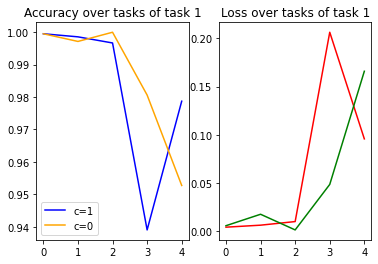

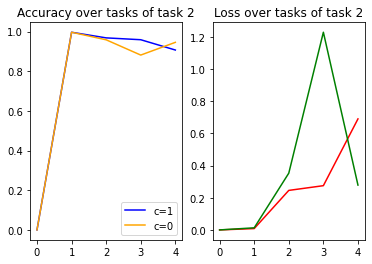

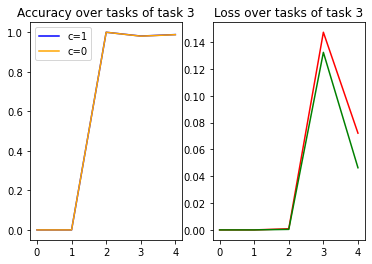

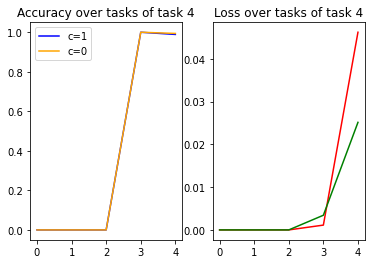

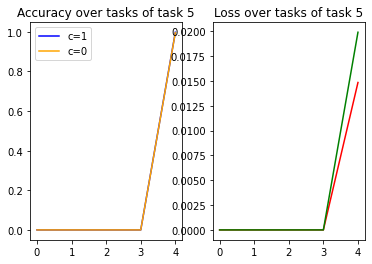

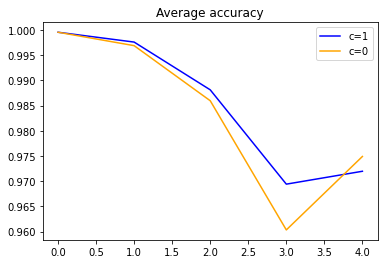

In [61]:
plot_res(
    task_cla,
    acc_res_with_consolidation,
    acc_res_without_consolidation,
    loss_res_with_consolidation,
    loss_res_without_consolidation
)

##Training on ConvNet network and CIFAR100 dataset

In [65]:
data_cf100, task_cla_cf100, input_size_cf100 = get_cifar100()

Task order = [3, 9, 5, 10, 2, 7, 8, 4, 1, 6]


In [67]:
cf100_acc_w_c, cf100_loss_w_c = train_mode(
    c=1,
    input_size=input_size_cf100,
    task_cla=task_cla_cf100,
    data= data_cf100,
    model_name='conv'
)

Task 0:, data name: cifar100-6
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:37,  1.29it/s]

train_loss: 2.1091, train_acc: 0.2153
val_loss: 2.0933, val_acc: 0.2080
 *

  4%|▍         | 2/50 [00:01<00:30,  1.55it/s]

train_loss: 1.9382, train_acc: 0.3004
val_loss: 1.9239, val_acc: 0.2980
 *

  6%|▌         | 3/50 [00:01<00:28,  1.66it/s]

train_loss: 1.7379, train_acc: 0.4096
val_loss: 1.7570, val_acc: 0.3960
 *

  8%|▊         | 4/50 [00:02<00:26,  1.71it/s]

train_loss: 1.6060, train_acc: 0.4536
val_loss: 1.6141, val_acc: 0.4560
 *

 10%|█         | 5/50 [00:02<00:25,  1.74it/s]

train_loss: 1.4261, train_acc: 0.5173
val_loss: 1.4764, val_acc: 0.5080
 *

 12%|█▏        | 6/50 [00:03<00:25,  1.76it/s]

train_loss: 1.3468, train_acc: 0.5384
val_loss: 1.4661, val_acc: 0.5040
 *

 14%|█▍        | 7/50 [00:04<00:24,  1.78it/s]

train_loss: 1.2123, train_acc: 0.5884
val_loss: 1.3523, val_acc: 0.5520
 *

 16%|█▌        | 8/50 [00:04<00:23,  1.78it/s]

train_loss: 1.1309, train_acc: 0.6344
val_loss: 1.2757, val_acc: 0.5780
 *

 18%|█▊        | 9/50 [00:05<00:22,  1.79it/s]

train_loss: 0.9903, train_acc: 0.6707
val_loss: 1.2093, val_acc: 0.5920
 *

 20%|██        | 10/50 [00:05<00:22,  1.79it/s]

train_loss: 0.9236, train_acc: 0.7051
val_loss: 1.1584, val_acc: 0.6280
 *

 22%|██▏       | 11/50 [00:06<00:21,  1.80it/s]

train_loss: 0.8617, train_acc: 0.7102
val_loss: 1.1939, val_acc: 0.6200


 24%|██▍       | 12/50 [00:06<00:21,  1.80it/s]

train_loss: 0.7942, train_acc: 0.7376
val_loss: 1.1272, val_acc: 0.6400
 *

 26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

train_loss: 0.7437, train_acc: 0.7560
val_loss: 1.1114, val_acc: 0.6480
 *

 28%|██▊       | 14/50 [00:07<00:20,  1.80it/s]

train_loss: 0.6571, train_acc: 0.7878
val_loss: 1.0781, val_acc: 0.6620
 *

 30%|███       | 15/50 [00:08<00:19,  1.80it/s]

train_loss: 0.6425, train_acc: 0.7851
val_loss: 1.1310, val_acc: 0.6460


 32%|███▏      | 16/50 [00:09<00:18,  1.80it/s]

train_loss: 0.6016, train_acc: 0.8002
val_loss: 1.1063, val_acc: 0.6660


 34%|███▍      | 17/50 [00:09<00:18,  1.81it/s]

train_loss: 0.5619, train_acc: 0.8084
val_loss: 1.1030, val_acc: 0.6680


 36%|███▌      | 18/50 [00:10<00:17,  1.81it/s]

train_loss: 0.5169, train_acc: 0.8327
val_loss: 1.0287, val_acc: 0.6700
 *

 38%|███▊      | 19/50 [00:10<00:17,  1.81it/s]

train_loss: 0.4109, train_acc: 0.8584
val_loss: 1.0829, val_acc: 0.6880


 40%|████      | 20/50 [00:11<00:16,  1.81it/s]

train_loss: 0.3542, train_acc: 0.8882
val_loss: 1.0251, val_acc: 0.7020
 *

 42%|████▏     | 21/50 [00:11<00:16,  1.81it/s]

train_loss: 0.3710, train_acc: 0.8767
val_loss: 1.1448, val_acc: 0.6860


 44%|████▍     | 22/50 [00:12<00:15,  1.81it/s]

train_loss: 0.3421, train_acc: 0.9009
val_loss: 1.0430, val_acc: 0.6840


 46%|████▌     | 23/50 [00:12<00:14,  1.81it/s]

train_loss: 0.2881, train_acc: 0.9062
val_loss: 1.1216, val_acc: 0.6880


 48%|████▊     | 24/50 [00:13<00:14,  1.81it/s]

train_loss: 0.2077, train_acc: 0.9400
val_loss: 1.0964, val_acc: 0.7040


 50%|█████     | 25/50 [00:14<00:13,  1.81it/s]

train_loss: 0.2035, train_acc: 0.9369
val_loss: 1.0960, val_acc: 0.7020


 52%|█████▏    | 26/50 [00:14<00:13,  1.81it/s]

train_loss: 0.1692, train_acc: 0.9549
val_loss: 1.1140, val_acc: 0.7060


 54%|█████▍    | 27/50 [00:15<00:12,  1.81it/s]

train_loss: 0.1381, train_acc: 0.9638
val_loss: 1.1409, val_acc: 0.7140


 56%|█████▌    | 28/50 [00:15<00:12,  1.82it/s]

train_loss: 0.1216, train_acc: 0.9693
val_loss: 1.1693, val_acc: 0.6980


 58%|█████▊    | 29/50 [00:16<00:11,  1.82it/s]

train_loss: 0.1101, train_acc: 0.9742
val_loss: 1.1726, val_acc: 0.7000


 60%|██████    | 30/50 [00:16<00:11,  1.81it/s]

train_loss: 0.1074, train_acc: 0.9776
val_loss: 1.1733, val_acc: 0.7040


 62%|██████▏   | 31/50 [00:17<00:10,  1.81it/s]

train_loss: 0.0942, train_acc: 0.9780
val_loss: 1.2098, val_acc: 0.7080


 64%|██████▍   | 32/50 [00:17<00:09,  1.81it/s]

train_loss: 0.0896, train_acc: 0.9804
val_loss: 1.2195, val_acc: 0.7060


 66%|██████▌   | 33/50 [00:18<00:09,  1.81it/s]

train_loss: 0.0825, train_acc: 0.9822
val_loss: 1.2740, val_acc: 0.7080


 68%|██████▊   | 34/50 [00:19<00:08,  1.81it/s]

train_loss: 0.0799, train_acc: 0.9820
val_loss: 1.2459, val_acc: 0.7160


 70%|███████   | 35/50 [00:19<00:08,  1.82it/s]

train_loss: 0.0782, train_acc: 0.9822
val_loss: 1.2694, val_acc: 0.7120


 72%|███████▏  | 36/50 [00:20<00:07,  1.81it/s]

train_loss: 0.0755, train_acc: 0.9847
val_loss: 1.2677, val_acc: 0.7120


 74%|███████▍  | 37/50 [00:20<00:07,  1.81it/s]

train_loss: 0.0729, train_acc: 0.9851
val_loss: 1.2549, val_acc: 0.7180


 76%|███████▌  | 38/50 [00:21<00:06,  1.81it/s]

train_loss: 0.0726, train_acc: 0.9853
val_loss: 1.2640, val_acc: 0.7120


 78%|███████▊  | 39/50 [00:21<00:06,  1.82it/s]

train_loss: 0.0714, train_acc: 0.9853
val_loss: 1.2693, val_acc: 0.7100


 80%|████████  | 40/50 [00:22<00:05,  1.82it/s]

train_loss: 0.0690, train_acc: 0.9856
val_loss: 1.2713, val_acc: 0.7160


 82%|████████▏ | 41/50 [00:22<00:04,  1.82it/s]

train_loss: 0.0692, train_acc: 0.9858
val_loss: 1.2823, val_acc: 0.7120


 84%|████████▍ | 42/50 [00:23<00:04,  1.82it/s]

train_loss: 0.0688, train_acc: 0.9858
val_loss: 1.2796, val_acc: 0.7160


 86%|████████▌ | 43/50 [00:23<00:03,  1.81it/s]

train_loss: 0.0683, train_acc: 0.9856
val_loss: 1.2730, val_acc: 0.7180


 88%|████████▊ | 44/50 [00:24<00:03,  1.81it/s]

train_loss: 0.0687, train_acc: 0.9864
val_loss: 1.2786, val_acc: 0.7160


 90%|█████████ | 45/50 [00:25<00:02,  1.81it/s]

train_loss: 0.0682, train_acc: 0.9864
val_loss: 1.2646, val_acc: 0.7180


 92%|█████████▏| 46/50 [00:25<00:02,  1.81it/s]

train_loss: 0.0678, train_acc: 0.9864
val_loss: 1.2692, val_acc: 0.7200


 94%|█████████▍| 47/50 [00:26<00:01,  1.81it/s]

train_loss: 0.0678, train_acc: 0.9858
val_loss: 1.2781, val_acc: 0.7160


 96%|█████████▌| 48/50 [00:26<00:01,  1.81it/s]

train_loss: 0.0676, train_acc: 0.9853
val_loss: 1.2799, val_acc: 0.7160


 98%|█████████▊| 49/50 [00:27<00:00,  1.81it/s]

train_loss: 0.0676, train_acc: 0.9864
val_loss: 1.2819, val_acc: 0.7160


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


train_loss: 0.0676, train_acc: 0.9860
val_loss: 1.2792, val_acc: 0.7160


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 47.97it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=0.895, acc= 72.1% <<<
Task 1:, data name: cifar100-3
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:31,  1.53it/s]

train_loss: 1.8516, train_acc: 0.3784
val_loss: 1.8826, val_acc: 0.3540
 *

  4%|▍         | 2/50 [00:01<00:31,  1.53it/s]

train_loss: 1.4770, train_acc: 0.4942
val_loss: 1.5765, val_acc: 0.4620
 *

  6%|▌         | 3/50 [00:01<00:30,  1.53it/s]

train_loss: 1.2573, train_acc: 0.5778
val_loss: 1.4066, val_acc: 0.5040
 *

  8%|▊         | 4/50 [00:02<00:30,  1.53it/s]

train_loss: 1.1196, train_acc: 0.6300
val_loss: 1.2998, val_acc: 0.5560
 *

 10%|█         | 5/50 [00:03<00:29,  1.53it/s]

train_loss: 1.0551, train_acc: 0.6647
val_loss: 1.2782, val_acc: 0.5640
 *

 12%|█▏        | 6/50 [00:03<00:28,  1.53it/s]

train_loss: 0.9153, train_acc: 0.7071
val_loss: 1.1636, val_acc: 0.5900
 *

 14%|█▍        | 7/50 [00:04<00:28,  1.53it/s]

train_loss: 0.8741, train_acc: 0.6953
val_loss: 1.1719, val_acc: 0.5720


 16%|█▌        | 8/50 [00:05<00:27,  1.53it/s]

train_loss: 0.7528, train_acc: 0.7611
val_loss: 1.0783, val_acc: 0.6300
 *

 18%|█▊        | 9/50 [00:05<00:26,  1.53it/s]

train_loss: 0.7252, train_acc: 0.7644
val_loss: 1.0714, val_acc: 0.6540
 *

 20%|██        | 10/50 [00:06<00:26,  1.53it/s]

train_loss: 0.5806, train_acc: 0.8136
val_loss: 1.0067, val_acc: 0.6640
 *

 22%|██▏       | 11/50 [00:07<00:25,  1.53it/s]

train_loss: 0.5348, train_acc: 0.8353
val_loss: 0.9947, val_acc: 0.6860
 *

 24%|██▍       | 12/50 [00:07<00:24,  1.53it/s]

train_loss: 0.5169, train_acc: 0.8440
val_loss: 0.9798, val_acc: 0.6640
 *

 26%|██▌       | 13/50 [00:08<00:24,  1.53it/s]

train_loss: 0.4234, train_acc: 0.8693
val_loss: 0.9769, val_acc: 0.7040
 *

 28%|██▊       | 14/50 [00:09<00:23,  1.53it/s]

train_loss: 0.3628, train_acc: 0.8876
val_loss: 1.0228, val_acc: 0.6820


 30%|███       | 15/50 [00:09<00:22,  1.53it/s]

train_loss: 0.3308, train_acc: 0.9089
val_loss: 0.9608, val_acc: 0.6920
 *

 32%|███▏      | 16/50 [00:10<00:22,  1.53it/s]

train_loss: 0.2806, train_acc: 0.9142
val_loss: 1.0067, val_acc: 0.6960


 34%|███▍      | 17/50 [00:11<00:21,  1.53it/s]

train_loss: 0.2411, train_acc: 0.9280
val_loss: 1.0063, val_acc: 0.6880


 36%|███▌      | 18/50 [00:11<00:20,  1.54it/s]

train_loss: 0.2236, train_acc: 0.9387
val_loss: 0.9865, val_acc: 0.7000


 38%|███▊      | 19/50 [00:12<00:20,  1.54it/s]

train_loss: 0.2025, train_acc: 0.9424
val_loss: 1.0176, val_acc: 0.7140


 40%|████      | 20/50 [00:13<00:19,  1.54it/s]

train_loss: 0.1976, train_acc: 0.9411
val_loss: 1.0180, val_acc: 0.6940


 42%|████▏     | 21/50 [00:13<00:18,  1.54it/s]

train_loss: 0.1283, train_acc: 0.9678
val_loss: 1.0198, val_acc: 0.7220


 44%|████▍     | 22/50 [00:14<00:18,  1.54it/s]

train_loss: 0.1093, train_acc: 0.9718
val_loss: 1.0417, val_acc: 0.7180


 46%|████▌     | 23/50 [00:14<00:17,  1.54it/s]

train_loss: 0.0961, train_acc: 0.9769
val_loss: 1.0436, val_acc: 0.7260


 48%|████▊     | 24/50 [00:15<00:16,  1.54it/s]

train_loss: 0.0954, train_acc: 0.9782
val_loss: 1.0545, val_acc: 0.7300


 50%|█████     | 25/50 [00:16<00:16,  1.54it/s]

train_loss: 0.0829, train_acc: 0.9829
val_loss: 1.0629, val_acc: 0.7160


 52%|█████▏    | 26/50 [00:16<00:15,  1.54it/s]

train_loss: 0.0695, train_acc: 0.9851
val_loss: 1.0878, val_acc: 0.7220


 54%|█████▍    | 27/50 [00:17<00:14,  1.54it/s]

train_loss: 0.0679, train_acc: 0.9878
val_loss: 1.0485, val_acc: 0.7240


 56%|█████▌    | 28/50 [00:18<00:14,  1.54it/s]

train_loss: 0.0703, train_acc: 0.9844
val_loss: 1.1010, val_acc: 0.7140


 58%|█████▊    | 29/50 [00:18<00:13,  1.54it/s]

train_loss: 0.0706, train_acc: 0.9849
val_loss: 1.1034, val_acc: 0.7160


 60%|██████    | 30/50 [00:19<00:13,  1.54it/s]

train_loss: 0.0626, train_acc: 0.9891
val_loss: 1.0788, val_acc: 0.7200


 62%|██████▏   | 31/50 [00:20<00:12,  1.54it/s]

train_loss: 0.0604, train_acc: 0.9891
val_loss: 1.0916, val_acc: 0.7260


 64%|██████▍   | 32/50 [00:20<00:11,  1.54it/s]

train_loss: 0.0580, train_acc: 0.9898
val_loss: 1.0968, val_acc: 0.7300


 66%|██████▌   | 33/50 [00:21<00:11,  1.54it/s]

train_loss: 0.0571, train_acc: 0.9916
val_loss: 1.0958, val_acc: 0.7340


 68%|██████▊   | 34/50 [00:22<00:10,  1.54it/s]

train_loss: 0.0549, train_acc: 0.9907
val_loss: 1.1017, val_acc: 0.7340


 70%|███████   | 35/50 [00:22<00:09,  1.54it/s]

train_loss: 0.0540, train_acc: 0.9909
val_loss: 1.1025, val_acc: 0.7320


 72%|███████▏  | 36/50 [00:23<00:09,  1.54it/s]

train_loss: 0.0543, train_acc: 0.9911
val_loss: 1.1048, val_acc: 0.7300


 74%|███████▍  | 37/50 [00:24<00:08,  1.54it/s]

train_loss: 0.0551, train_acc: 0.9907
val_loss: 1.1069, val_acc: 0.7300


 76%|███████▌  | 38/50 [00:24<00:07,  1.53it/s]

train_loss: 0.0538, train_acc: 0.9911
val_loss: 1.1065, val_acc: 0.7280


 78%|███████▊  | 39/50 [00:25<00:07,  1.54it/s]

train_loss: 0.0530, train_acc: 0.9911
val_loss: 1.1013, val_acc: 0.7280


 80%|████████  | 40/50 [00:26<00:06,  1.53it/s]

train_loss: 0.0533, train_acc: 0.9904
val_loss: 1.1066, val_acc: 0.7280


 82%|████████▏ | 41/50 [00:26<00:05,  1.54it/s]

train_loss: 0.0534, train_acc: 0.9909
val_loss: 1.1037, val_acc: 0.7300


 84%|████████▍ | 42/50 [00:27<00:05,  1.54it/s]

train_loss: 0.0533, train_acc: 0.9909
val_loss: 1.1039, val_acc: 0.7280


 86%|████████▌ | 43/50 [00:28<00:04,  1.54it/s]

train_loss: 0.0532, train_acc: 0.9913
val_loss: 1.1042, val_acc: 0.7280


 88%|████████▊ | 44/50 [00:28<00:03,  1.54it/s]

train_loss: 0.0530, train_acc: 0.9916
val_loss: 1.1035, val_acc: 0.7300


 90%|█████████ | 45/50 [00:29<00:03,  1.54it/s]

train_loss: 0.0530, train_acc: 0.9916
val_loss: 1.1025, val_acc: 0.7300


 92%|█████████▏| 46/50 [00:29<00:02,  1.54it/s]

train_loss: 0.0529, train_acc: 0.9911
val_loss: 1.1027, val_acc: 0.7320


 94%|█████████▍| 47/50 [00:30<00:01,  1.54it/s]

train_loss: 0.0530, train_acc: 0.9916
val_loss: 1.1033, val_acc: 0.7300


 96%|█████████▌| 48/50 [00:31<00:01,  1.54it/s]

train_loss: 0.0530, train_acc: 0.9913
val_loss: 1.1040, val_acc: 0.7300


 98%|█████████▊| 49/50 [00:31<00:00,  1.54it/s]

train_loss: 0.0531, train_acc: 0.9913
val_loss: 1.1049, val_acc: 0.7280


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


train_loss: 0.0531, train_acc: 0.9913
val_loss: 1.1057, val_acc: 0.7280


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.01it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.671, acc= 41.8% <<<
>>> Test on task  1 - cifar100-3     : loss=0.897, acc= 72.0% <<<
Task 2:, data name: cifar100-9
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:32,  1.49it/s]

train_loss: 1.5134, train_acc: 0.4811
val_loss: 1.4807, val_acc: 0.4780
 *

  4%|▍         | 2/50 [00:01<00:32,  1.49it/s]

train_loss: 1.1821, train_acc: 0.5989
val_loss: 1.1889, val_acc: 0.5900
 *

  6%|▌         | 3/50 [00:02<00:31,  1.49it/s]

train_loss: 1.0600, train_acc: 0.6316
val_loss: 1.1107, val_acc: 0.6100
 *

  8%|▊         | 4/50 [00:02<00:30,  1.49it/s]

train_loss: 0.8688, train_acc: 0.7147
val_loss: 0.9353, val_acc: 0.7100
 *

 10%|█         | 5/50 [00:03<00:30,  1.49it/s]

train_loss: 0.8218, train_acc: 0.7333
val_loss: 0.9407, val_acc: 0.6860


 12%|█▏        | 6/50 [00:04<00:29,  1.49it/s]

train_loss: 0.7308, train_acc: 0.7584
val_loss: 0.8896, val_acc: 0.6820
 *

 14%|█▍        | 7/50 [00:04<00:28,  1.49it/s]

train_loss: 0.6399, train_acc: 0.7889
val_loss: 0.8395, val_acc: 0.7160
 *

 16%|█▌        | 8/50 [00:05<00:28,  1.49it/s]

train_loss: 0.5571, train_acc: 0.8111
val_loss: 0.8046, val_acc: 0.7320
 *

 18%|█▊        | 9/50 [00:06<00:27,  1.49it/s]

train_loss: 0.4812, train_acc: 0.8413
val_loss: 0.7807, val_acc: 0.7320
 *

 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

train_loss: 0.4284, train_acc: 0.8616
val_loss: 0.7554, val_acc: 0.7480
 *

 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

train_loss: 0.3825, train_acc: 0.8791
val_loss: 0.7786, val_acc: 0.7420


 24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

train_loss: 0.3618, train_acc: 0.8876
val_loss: 0.7561, val_acc: 0.7680


 26%|██▌       | 13/50 [00:08<00:24,  1.49it/s]

train_loss: 0.3633, train_acc: 0.8900
val_loss: 0.7909, val_acc: 0.7440


 28%|██▊       | 14/50 [00:09<00:24,  1.49it/s]

train_loss: 0.2737, train_acc: 0.9162
val_loss: 0.7841, val_acc: 0.7400


 30%|███       | 15/50 [00:10<00:23,  1.49it/s]

train_loss: 0.2955, train_acc: 0.9080
val_loss: 0.7942, val_acc: 0.7360


 32%|███▏      | 16/50 [00:10<00:22,  1.49it/s]

train_loss: 0.2183, train_acc: 0.9349
val_loss: 0.7803, val_acc: 0.7480


 34%|███▍      | 17/50 [00:11<00:22,  1.49it/s]

train_loss: 0.1778, train_acc: 0.9491
val_loss: 0.7712, val_acc: 0.7580


 36%|███▌      | 18/50 [00:12<00:21,  1.50it/s]

train_loss: 0.1660, train_acc: 0.9511
val_loss: 0.7759, val_acc: 0.7500


 38%|███▊      | 19/50 [00:12<00:20,  1.49it/s]

train_loss: 0.1601, train_acc: 0.9567
val_loss: 0.7539, val_acc: 0.7600
 *

 40%|████      | 20/50 [00:13<00:20,  1.50it/s]

train_loss: 0.1502, train_acc: 0.9578
val_loss: 0.8024, val_acc: 0.7540


 42%|████▏     | 21/50 [00:14<00:19,  1.49it/s]

train_loss: 0.1314, train_acc: 0.9644
val_loss: 0.7669, val_acc: 0.7560


 44%|████▍     | 22/50 [00:14<00:18,  1.49it/s]

train_loss: 0.1235, train_acc: 0.9702
val_loss: 0.7924, val_acc: 0.7540


 46%|████▌     | 23/50 [00:15<00:18,  1.50it/s]

train_loss: 0.1152, train_acc: 0.9756
val_loss: 0.8140, val_acc: 0.7540


 48%|████▊     | 24/50 [00:16<00:17,  1.50it/s]

train_loss: 0.1025, train_acc: 0.9773
val_loss: 0.7978, val_acc: 0.7600


 50%|█████     | 25/50 [00:16<00:16,  1.50it/s]

train_loss: 0.1099, train_acc: 0.9716
val_loss: 0.7967, val_acc: 0.7640


 52%|█████▏    | 26/50 [00:17<00:16,  1.50it/s]

train_loss: 0.1027, train_acc: 0.9751
val_loss: 0.8175, val_acc: 0.7520


 54%|█████▍    | 27/50 [00:18<00:15,  1.50it/s]

train_loss: 0.0955, train_acc: 0.9764
val_loss: 0.8049, val_acc: 0.7560


 56%|█████▌    | 28/50 [00:18<00:14,  1.50it/s]

train_loss: 0.0911, train_acc: 0.9780
val_loss: 0.7911, val_acc: 0.7540


 58%|█████▊    | 29/50 [00:19<00:14,  1.50it/s]

train_loss: 0.0853, train_acc: 0.9813
val_loss: 0.8098, val_acc: 0.7600


 60%|██████    | 30/50 [00:20<00:13,  1.50it/s]

train_loss: 0.0849, train_acc: 0.9824
val_loss: 0.8137, val_acc: 0.7640


 62%|██████▏   | 31/50 [00:20<00:12,  1.50it/s]

train_loss: 0.0805, train_acc: 0.9831
val_loss: 0.8117, val_acc: 0.7640


 64%|██████▍   | 32/50 [00:21<00:12,  1.50it/s]

train_loss: 0.0791, train_acc: 0.9838
val_loss: 0.8152, val_acc: 0.7700


 66%|██████▌   | 33/50 [00:22<00:11,  1.50it/s]

train_loss: 0.0783, train_acc: 0.9842
val_loss: 0.8089, val_acc: 0.7660


 68%|██████▊   | 34/50 [00:22<00:10,  1.50it/s]

train_loss: 0.0766, train_acc: 0.9842
val_loss: 0.8137, val_acc: 0.7680


 70%|███████   | 35/50 [00:23<00:10,  1.50it/s]

train_loss: 0.0791, train_acc: 0.9836
val_loss: 0.8213, val_acc: 0.7640


 72%|███████▏  | 36/50 [00:24<00:09,  1.50it/s]

train_loss: 0.0754, train_acc: 0.9836
val_loss: 0.8187, val_acc: 0.7640


 74%|███████▍  | 37/50 [00:24<00:08,  1.50it/s]

train_loss: 0.0762, train_acc: 0.9836
val_loss: 0.8208, val_acc: 0.7620


 76%|███████▌  | 38/50 [00:25<00:08,  1.50it/s]

train_loss: 0.0759, train_acc: 0.9838
val_loss: 0.8178, val_acc: 0.7660


 78%|███████▊  | 39/50 [00:26<00:07,  1.50it/s]

train_loss: 0.0764, train_acc: 0.9836
val_loss: 0.8182, val_acc: 0.7700


 80%|████████  | 40/50 [00:26<00:06,  1.50it/s]

train_loss: 0.0755, train_acc: 0.9844
val_loss: 0.8192, val_acc: 0.7700


 82%|████████▏ | 41/50 [00:27<00:06,  1.50it/s]

train_loss: 0.0752, train_acc: 0.9844
val_loss: 0.8188, val_acc: 0.7680


 84%|████████▍ | 42/50 [00:28<00:05,  1.49it/s]

train_loss: 0.0749, train_acc: 0.9847
val_loss: 0.8184, val_acc: 0.7680


 86%|████████▌ | 43/50 [00:28<00:04,  1.49it/s]

train_loss: 0.0752, train_acc: 0.9847
val_loss: 0.8195, val_acc: 0.7680


 88%|████████▊ | 44/50 [00:29<00:04,  1.50it/s]

train_loss: 0.0745, train_acc: 0.9847
val_loss: 0.8197, val_acc: 0.7680


 90%|█████████ | 45/50 [00:30<00:03,  1.50it/s]

train_loss: 0.0745, train_acc: 0.9849
val_loss: 0.8203, val_acc: 0.7680


 92%|█████████▏| 46/50 [00:30<00:02,  1.50it/s]

train_loss: 0.0747, train_acc: 0.9849
val_loss: 0.8201, val_acc: 0.7680


 94%|█████████▍| 47/50 [00:31<00:02,  1.50it/s]

train_loss: 0.0749, train_acc: 0.9849
val_loss: 0.8204, val_acc: 0.7680


 96%|█████████▌| 48/50 [00:32<00:01,  1.50it/s]

train_loss: 0.0750, train_acc: 0.9847
val_loss: 0.8209, val_acc: 0.7680


 98%|█████████▊| 49/50 [00:32<00:00,  1.50it/s]

train_loss: 0.0748, train_acc: 0.9847
val_loss: 0.8206, val_acc: 0.7680


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


train_loss: 0.0752, train_acc: 0.9847
val_loss: 0.8214, val_acc: 0.7680


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.00it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.544, acc= 30.3% <<<
>>> Test on task  1 - cifar100-3     : loss=1.970, acc= 44.4% <<<
>>> Test on task  2 - cifar100-9     : loss=0.855, acc= 75.2% <<<
Task 3:, data name: cifar100-5
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

train_loss: 1.3442, train_acc: 0.5556
val_loss: 1.3712, val_acc: 0.5200
 *

  4%|▍         | 2/50 [00:01<00:33,  1.45it/s]

train_loss: 1.0465, train_acc: 0.6636
val_loss: 1.1262, val_acc: 0.6300
 *

  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

train_loss: 0.8989, train_acc: 0.7233
val_loss: 1.0255, val_acc: 0.6760
 *

  8%|▊         | 4/50 [00:02<00:31,  1.45it/s]

train_loss: 0.7485, train_acc: 0.7676
val_loss: 0.9344, val_acc: 0.7080
 *

 10%|█         | 5/50 [00:03<00:31,  1.45it/s]

train_loss: 0.6402, train_acc: 0.7940
val_loss: 0.8488, val_acc: 0.7220
 *

 12%|█▏        | 6/50 [00:04<00:30,  1.45it/s]

train_loss: 0.5573, train_acc: 0.8182
val_loss: 0.8504, val_acc: 0.7100


 14%|█▍        | 7/50 [00:04<00:29,  1.45it/s]

train_loss: 0.4752, train_acc: 0.8442
val_loss: 0.8218, val_acc: 0.7360
 *

 16%|█▌        | 8/50 [00:05<00:28,  1.45it/s]

train_loss: 0.4320, train_acc: 0.8591
val_loss: 0.8137, val_acc: 0.7420
 *

 18%|█▊        | 9/50 [00:06<00:28,  1.45it/s]

train_loss: 0.4116, train_acc: 0.8747
val_loss: 0.7871, val_acc: 0.7400
 *

 20%|██        | 10/50 [00:06<00:27,  1.45it/s]

train_loss: 0.3177, train_acc: 0.9031
val_loss: 0.7539, val_acc: 0.7560
 *

 22%|██▏       | 11/50 [00:07<00:26,  1.45it/s]

train_loss: 0.2611, train_acc: 0.9211
val_loss: 0.7453, val_acc: 0.7560
 *

 24%|██▍       | 12/50 [00:08<00:26,  1.45it/s]

train_loss: 0.2534, train_acc: 0.9231
val_loss: 0.7893, val_acc: 0.7620


 26%|██▌       | 13/50 [00:08<00:25,  1.45it/s]

train_loss: 0.2027, train_acc: 0.9456
val_loss: 0.7010, val_acc: 0.7840
 *

 28%|██▊       | 14/50 [00:09<00:24,  1.45it/s]

train_loss: 0.1732, train_acc: 0.9458
val_loss: 0.8216, val_acc: 0.7540


 30%|███       | 15/50 [00:10<00:24,  1.45it/s]

train_loss: 0.1507, train_acc: 0.9589
val_loss: 0.7749, val_acc: 0.7580


 32%|███▏      | 16/50 [00:11<00:23,  1.45it/s]

train_loss: 0.1256, train_acc: 0.9671
val_loss: 0.8133, val_acc: 0.7680


 34%|███▍      | 17/50 [00:11<00:22,  1.46it/s]

train_loss: 0.1145, train_acc: 0.9693
val_loss: 0.8663, val_acc: 0.7680


 36%|███▌      | 18/50 [00:12<00:21,  1.46it/s]

train_loss: 0.1139, train_acc: 0.9693
val_loss: 0.8368, val_acc: 0.7580


 38%|███▊      | 19/50 [00:13<00:21,  1.46it/s]

train_loss: 0.0718, train_acc: 0.9836
val_loss: 0.7832, val_acc: 0.7900


 40%|████      | 20/50 [00:13<00:20,  1.46it/s]

train_loss: 0.0577, train_acc: 0.9873
val_loss: 0.8246, val_acc: 0.7960


 42%|████▏     | 21/50 [00:14<00:19,  1.46it/s]

train_loss: 0.0517, train_acc: 0.9889
val_loss: 0.8268, val_acc: 0.7800


 44%|████▍     | 22/50 [00:15<00:19,  1.46it/s]

train_loss: 0.0497, train_acc: 0.9898
val_loss: 0.8258, val_acc: 0.8000


 46%|████▌     | 23/50 [00:15<00:18,  1.46it/s]

train_loss: 0.0446, train_acc: 0.9907
val_loss: 0.8558, val_acc: 0.7900


 48%|████▊     | 24/50 [00:16<00:17,  1.46it/s]

train_loss: 0.0401, train_acc: 0.9907
val_loss: 0.8592, val_acc: 0.7920


 50%|█████     | 25/50 [00:17<00:17,  1.46it/s]

train_loss: 0.0346, train_acc: 0.9931
val_loss: 0.8416, val_acc: 0.7880


 52%|█████▏    | 26/50 [00:17<00:16,  1.46it/s]

train_loss: 0.0334, train_acc: 0.9931
val_loss: 0.8294, val_acc: 0.7960


 54%|█████▍    | 27/50 [00:18<00:15,  1.46it/s]

train_loss: 0.0328, train_acc: 0.9929
val_loss: 0.8543, val_acc: 0.7860


 56%|█████▌    | 28/50 [00:19<00:15,  1.46it/s]

train_loss: 0.0304, train_acc: 0.9936
val_loss: 0.8585, val_acc: 0.7980


 58%|█████▊    | 29/50 [00:19<00:14,  1.46it/s]

train_loss: 0.0290, train_acc: 0.9940
val_loss: 0.8515, val_acc: 0.7960


 60%|██████    | 30/50 [00:20<00:13,  1.46it/s]

train_loss: 0.0282, train_acc: 0.9938
val_loss: 0.8829, val_acc: 0.7880


 62%|██████▏   | 31/50 [00:21<00:13,  1.46it/s]

train_loss: 0.0275, train_acc: 0.9940
val_loss: 0.8601, val_acc: 0.7920


 64%|██████▍   | 32/50 [00:22<00:12,  1.46it/s]

train_loss: 0.0274, train_acc: 0.9940
val_loss: 0.8865, val_acc: 0.7960


 66%|██████▌   | 33/50 [00:22<00:11,  1.46it/s]

train_loss: 0.0273, train_acc: 0.9942
val_loss: 0.8663, val_acc: 0.8020


 68%|██████▊   | 34/50 [00:23<00:10,  1.46it/s]

train_loss: 0.0265, train_acc: 0.9951
val_loss: 0.8700, val_acc: 0.7940


 70%|███████   | 35/50 [00:24<00:10,  1.46it/s]

train_loss: 0.0265, train_acc: 0.9949
val_loss: 0.8714, val_acc: 0.7940


 72%|███████▏  | 36/50 [00:24<00:09,  1.46it/s]

train_loss: 0.0264, train_acc: 0.9949
val_loss: 0.8779, val_acc: 0.7920


 74%|███████▍  | 37/50 [00:25<00:08,  1.46it/s]

train_loss: 0.0261, train_acc: 0.9949
val_loss: 0.8773, val_acc: 0.7900


 76%|███████▌  | 38/50 [00:26<00:08,  1.46it/s]

train_loss: 0.0255, train_acc: 0.9951
val_loss: 0.8667, val_acc: 0.7900


 78%|███████▊  | 39/50 [00:26<00:07,  1.46it/s]

train_loss: 0.0253, train_acc: 0.9951
val_loss: 0.8660, val_acc: 0.7900


 80%|████████  | 40/50 [00:27<00:06,  1.46it/s]

train_loss: 0.0252, train_acc: 0.9951
val_loss: 0.8704, val_acc: 0.7920


 82%|████████▏ | 41/50 [00:28<00:06,  1.46it/s]

train_loss: 0.0253, train_acc: 0.9953
val_loss: 0.8731, val_acc: 0.7900


 84%|████████▍ | 42/50 [00:28<00:05,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9951
val_loss: 0.8714, val_acc: 0.7900


 86%|████████▌ | 43/50 [00:29<00:04,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9949
val_loss: 0.8719, val_acc: 0.7920


 88%|████████▊ | 44/50 [00:30<00:04,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9951
val_loss: 0.8719, val_acc: 0.7920


 90%|█████████ | 45/50 [00:30<00:03,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9951
val_loss: 0.8721, val_acc: 0.7900


 92%|█████████▏| 46/50 [00:31<00:02,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9951
val_loss: 0.8727, val_acc: 0.7920


 94%|█████████▍| 47/50 [00:32<00:02,  1.46it/s]

train_loss: 0.0252, train_acc: 0.9947
val_loss: 0.8727, val_acc: 0.7920


 96%|█████████▌| 48/50 [00:32<00:01,  1.46it/s]

train_loss: 0.0252, train_acc: 0.9947
val_loss: 0.8729, val_acc: 0.7900


 98%|█████████▊| 49/50 [00:33<00:00,  1.46it/s]

train_loss: 0.0251, train_acc: 0.9949
val_loss: 0.8728, val_acc: 0.7900


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


train_loss: 0.0251, train_acc: 0.9949
val_loss: 0.8730, val_acc: 0.7880


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.10it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.518, acc= 23.3% <<<
>>> Test on task  1 - cifar100-3     : loss=1.756, acc= 40.3% <<<
>>> Test on task  2 - cifar100-9     : loss=1.279, acc= 58.2% <<<
>>> Test on task  3 - cifar100-5     : loss=0.678, acc= 79.1% <<<
Task 4:, data name: cifar100-10
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:34,  1.42it/s]

train_loss: 1.7868, train_acc: 0.4438
val_loss: 1.7997, val_acc: 0.4300
 *

  4%|▍         | 2/50 [00:01<00:33,  1.41it/s]

train_loss: 1.2635, train_acc: 0.5829
val_loss: 1.2717, val_acc: 0.5840
 *

  6%|▌         | 3/50 [00:02<00:33,  1.41it/s]

train_loss: 1.0568, train_acc: 0.6411
val_loss: 1.1090, val_acc: 0.6220
 *

  8%|▊         | 4/50 [00:02<00:32,  1.41it/s]

train_loss: 0.9263, train_acc: 0.7044
val_loss: 1.0596, val_acc: 0.6440
 *

 10%|█         | 5/50 [00:03<00:31,  1.41it/s]

train_loss: 0.8462, train_acc: 0.7256
val_loss: 1.0305, val_acc: 0.6380
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.41it/s]

train_loss: 0.7544, train_acc: 0.7611
val_loss: 0.9644, val_acc: 0.6360
 *

 14%|█▍        | 7/50 [00:04<00:30,  1.41it/s]

train_loss: 0.6455, train_acc: 0.7951
val_loss: 0.9114, val_acc: 0.6880
 *

 16%|█▌        | 8/50 [00:05<00:29,  1.41it/s]

train_loss: 0.6164, train_acc: 0.8087
val_loss: 0.9256, val_acc: 0.6560


 18%|█▊        | 9/50 [00:06<00:28,  1.42it/s]

train_loss: 0.5362, train_acc: 0.8247
val_loss: 0.9217, val_acc: 0.6920


 20%|██        | 10/50 [00:07<00:28,  1.42it/s]

train_loss: 0.4728, train_acc: 0.8447
val_loss: 0.9150, val_acc: 0.6940


 22%|██▏       | 11/50 [00:07<00:27,  1.42it/s]

train_loss: 0.3991, train_acc: 0.8802
val_loss: 0.8940, val_acc: 0.6860
 *

 24%|██▍       | 12/50 [00:08<00:26,  1.42it/s]

train_loss: 0.3728, train_acc: 0.8871
val_loss: 0.9274, val_acc: 0.6780


 26%|██▌       | 13/50 [00:09<00:26,  1.42it/s]

train_loss: 0.3254, train_acc: 0.9051
val_loss: 0.9286, val_acc: 0.6980


 28%|██▊       | 14/50 [00:09<00:25,  1.42it/s]

train_loss: 0.2850, train_acc: 0.9204
val_loss: 0.9421, val_acc: 0.7000


 30%|███       | 15/50 [00:10<00:24,  1.42it/s]

train_loss: 0.2544, train_acc: 0.9287
val_loss: 0.9464, val_acc: 0.7040


 32%|███▏      | 16/50 [00:11<00:23,  1.42it/s]

train_loss: 0.2306, train_acc: 0.9402
val_loss: 0.9546, val_acc: 0.6980


 34%|███▍      | 17/50 [00:12<00:23,  1.42it/s]

train_loss: 0.1561, train_acc: 0.9631
val_loss: 0.9443, val_acc: 0.7140


 36%|███▌      | 18/50 [00:12<00:22,  1.42it/s]

train_loss: 0.1461, train_acc: 0.9660
val_loss: 0.9482, val_acc: 0.7220


 38%|███▊      | 19/50 [00:13<00:21,  1.42it/s]

train_loss: 0.1312, train_acc: 0.9680
val_loss: 0.9981, val_acc: 0.7180


 40%|████      | 20/50 [00:14<00:21,  1.42it/s]

train_loss: 0.1225, train_acc: 0.9729
val_loss: 0.9976, val_acc: 0.7140


 42%|████▏     | 21/50 [00:14<00:20,  1.42it/s]

train_loss: 0.1038, train_acc: 0.9758
val_loss: 1.0192, val_acc: 0.7120


 44%|████▍     | 22/50 [00:15<00:19,  1.42it/s]

train_loss: 0.0978, train_acc: 0.9796
val_loss: 0.9951, val_acc: 0.7180


 46%|████▌     | 23/50 [00:16<00:19,  1.42it/s]

train_loss: 0.0914, train_acc: 0.9798
val_loss: 1.0127, val_acc: 0.7200


 48%|████▊     | 24/50 [00:16<00:18,  1.42it/s]

train_loss: 0.0886, train_acc: 0.9813
val_loss: 1.0120, val_acc: 0.7080


 50%|█████     | 25/50 [00:17<00:17,  1.42it/s]

train_loss: 0.0867, train_acc: 0.9833
val_loss: 1.0039, val_acc: 0.7240


 52%|█████▏    | 26/50 [00:18<00:16,  1.42it/s]

train_loss: 0.0847, train_acc: 0.9822
val_loss: 1.0295, val_acc: 0.7140


 54%|█████▍    | 27/50 [00:19<00:16,  1.42it/s]

train_loss: 0.0799, train_acc: 0.9842
val_loss: 1.0175, val_acc: 0.7220


 56%|█████▌    | 28/50 [00:19<00:15,  1.42it/s]

train_loss: 0.0794, train_acc: 0.9844
val_loss: 1.0086, val_acc: 0.7200


 58%|█████▊    | 29/50 [00:20<00:14,  1.42it/s]

train_loss: 0.0789, train_acc: 0.9849
val_loss: 1.0168, val_acc: 0.7220


 60%|██████    | 30/50 [00:21<00:14,  1.42it/s]

train_loss: 0.0775, train_acc: 0.9853
val_loss: 1.0197, val_acc: 0.7160


 62%|██████▏   | 31/50 [00:21<00:13,  1.42it/s]

train_loss: 0.0759, train_acc: 0.9862
val_loss: 1.0156, val_acc: 0.7200


 64%|██████▍   | 32/50 [00:22<00:12,  1.42it/s]

train_loss: 0.0754, train_acc: 0.9858
val_loss: 1.0209, val_acc: 0.7140


 66%|██████▌   | 33/50 [00:23<00:11,  1.42it/s]

train_loss: 0.0749, train_acc: 0.9858
val_loss: 1.0196, val_acc: 0.7160


 68%|██████▊   | 34/50 [00:23<00:11,  1.42it/s]

train_loss: 0.0746, train_acc: 0.9858
val_loss: 1.0201, val_acc: 0.7200


 70%|███████   | 35/50 [00:24<00:10,  1.42it/s]

train_loss: 0.0743, train_acc: 0.9856
val_loss: 1.0221, val_acc: 0.7200


 72%|███████▏  | 36/50 [00:25<00:09,  1.42it/s]

train_loss: 0.0740, train_acc: 0.9858
val_loss: 1.0251, val_acc: 0.7200


 74%|███████▍  | 37/50 [00:26<00:09,  1.42it/s]

train_loss: 0.0737, train_acc: 0.9860
val_loss: 1.0250, val_acc: 0.7200


 76%|███████▌  | 38/50 [00:26<00:08,  1.42it/s]

train_loss: 0.0735, train_acc: 0.9862
val_loss: 1.0231, val_acc: 0.7240


 78%|███████▊  | 39/50 [00:27<00:07,  1.42it/s]

train_loss: 0.0735, train_acc: 0.9860
val_loss: 1.0236, val_acc: 0.7260


 80%|████████  | 40/50 [00:28<00:07,  1.42it/s]

train_loss: 0.0735, train_acc: 0.9860
val_loss: 1.0249, val_acc: 0.7280


 82%|████████▏ | 41/50 [00:28<00:06,  1.42it/s]

train_loss: 0.0733, train_acc: 0.9860
val_loss: 1.0244, val_acc: 0.7240


 84%|████████▍ | 42/50 [00:29<00:05,  1.42it/s]

train_loss: 0.0732, train_acc: 0.9860
val_loss: 1.0246, val_acc: 0.7260


 86%|████████▌ | 43/50 [00:30<00:04,  1.42it/s]

train_loss: 0.0732, train_acc: 0.9862
val_loss: 1.0247, val_acc: 0.7240


 88%|████████▊ | 44/50 [00:31<00:04,  1.42it/s]

train_loss: 0.0732, train_acc: 0.9860
val_loss: 1.0246, val_acc: 0.7240


 90%|█████████ | 45/50 [00:31<00:03,  1.42it/s]

train_loss: 0.0732, train_acc: 0.9860
val_loss: 1.0246, val_acc: 0.7260


 92%|█████████▏| 46/50 [00:32<00:02,  1.42it/s]

train_loss: 0.0731, train_acc: 0.9864
val_loss: 1.0245, val_acc: 0.7260


 94%|█████████▍| 47/50 [00:33<00:02,  1.42it/s]

train_loss: 0.0730, train_acc: 0.9862
val_loss: 1.0249, val_acc: 0.7240


 96%|█████████▌| 48/50 [00:33<00:01,  1.42it/s]

train_loss: 0.0730, train_acc: 0.9862
val_loss: 1.0253, val_acc: 0.7240


 98%|█████████▊| 49/50 [00:34<00:00,  1.42it/s]

train_loss: 0.0729, train_acc: 0.9862
val_loss: 1.0257, val_acc: 0.7240


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


train_loss: 0.0729, train_acc: 0.9862
val_loss: 1.0257, val_acc: 0.7240


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.91it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.567, acc= 21.7% <<<
>>> Test on task  1 - cifar100-3     : loss=2.020, acc= 32.6% <<<
>>> Test on task  2 - cifar100-9     : loss=1.394, acc= 49.8% <<<
>>> Test on task  3 - cifar100-5     : loss=1.117, acc= 65.1% <<<
>>> Test on task  4 - cifar100-10    : loss=0.903, acc= 69.9% <<<
Task 5:, data name: cifar100-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:35,  1.38it/s]

train_loss: 1.1616, train_acc: 0.5924
val_loss: 1.1967, val_acc: 0.5740
 *

  4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

train_loss: 0.8663, train_acc: 0.6971
val_loss: 0.9271, val_acc: 0.6600
 *

  6%|▌         | 3/50 [00:02<00:34,  1.37it/s]

train_loss: 0.7372, train_acc: 0.7473
val_loss: 0.8496, val_acc: 0.6760
 *

  8%|▊         | 4/50 [00:02<00:33,  1.38it/s]

train_loss: 0.6892, train_acc: 0.7533
val_loss: 0.8989, val_acc: 0.6860


 10%|█         | 5/50 [00:03<00:32,  1.38it/s]

train_loss: 0.6151, train_acc: 0.7836
val_loss: 0.8294, val_acc: 0.6940
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.38it/s]

train_loss: 0.5321, train_acc: 0.8187
val_loss: 0.7870, val_acc: 0.7220
 *

 14%|█▍        | 7/50 [00:05<00:31,  1.38it/s]

train_loss: 0.4874, train_acc: 0.8351
val_loss: 0.7739, val_acc: 0.7320
 *

 16%|█▌        | 8/50 [00:05<00:30,  1.38it/s]

train_loss: 0.4022, train_acc: 0.8653
val_loss: 0.7533, val_acc: 0.7380
 *

 18%|█▊        | 9/50 [00:06<00:29,  1.38it/s]

train_loss: 0.3488, train_acc: 0.8867
val_loss: 0.6864, val_acc: 0.7460
 *

 20%|██        | 10/50 [00:07<00:28,  1.38it/s]

train_loss: 0.2998, train_acc: 0.9022
val_loss: 0.7023, val_acc: 0.7680


 22%|██▏       | 11/50 [00:07<00:28,  1.38it/s]

train_loss: 0.3010, train_acc: 0.8973
val_loss: 0.7813, val_acc: 0.7700


 24%|██▍       | 12/50 [00:08<00:27,  1.38it/s]

train_loss: 0.2335, train_acc: 0.9293
val_loss: 0.6833, val_acc: 0.7740
 *

 26%|██▌       | 13/50 [00:09<00:26,  1.38it/s]

train_loss: 0.1947, train_acc: 0.9373
val_loss: 0.7438, val_acc: 0.7640


 28%|██▊       | 14/50 [00:10<00:26,  1.38it/s]

train_loss: 0.1734, train_acc: 0.9504
val_loss: 0.7474, val_acc: 0.7740


 30%|███       | 15/50 [00:10<00:25,  1.38it/s]

train_loss: 0.1418, train_acc: 0.9609
val_loss: 0.7355, val_acc: 0.7720


 32%|███▏      | 16/50 [00:11<00:24,  1.38it/s]

train_loss: 0.1439, train_acc: 0.9604
val_loss: 0.7480, val_acc: 0.7840


 34%|███▍      | 17/50 [00:12<00:23,  1.38it/s]

train_loss: 0.1117, train_acc: 0.9713
val_loss: 0.7000, val_acc: 0.7920


 36%|███▌      | 18/50 [00:13<00:23,  1.38it/s]

train_loss: 0.0914, train_acc: 0.9796
val_loss: 0.7189, val_acc: 0.7820


 38%|███▊      | 19/50 [00:13<00:22,  1.38it/s]

train_loss: 0.0732, train_acc: 0.9849
val_loss: 0.7487, val_acc: 0.7860


 40%|████      | 20/50 [00:14<00:21,  1.38it/s]

train_loss: 0.0719, train_acc: 0.9840
val_loss: 0.7663, val_acc: 0.7980


 42%|████▏     | 21/50 [00:15<00:20,  1.38it/s]

train_loss: 0.0639, train_acc: 0.9880
val_loss: 0.7630, val_acc: 0.7940


 44%|████▍     | 22/50 [00:15<00:20,  1.38it/s]

train_loss: 0.0560, train_acc: 0.9880
val_loss: 0.7992, val_acc: 0.7920


 46%|████▌     | 23/50 [00:16<00:19,  1.38it/s]

train_loss: 0.0513, train_acc: 0.9902
val_loss: 0.7745, val_acc: 0.8000


 48%|████▊     | 24/50 [00:17<00:18,  1.38it/s]

train_loss: 0.0485, train_acc: 0.9913
val_loss: 0.7837, val_acc: 0.8020


 50%|█████     | 25/50 [00:18<00:18,  1.38it/s]

train_loss: 0.0458, train_acc: 0.9933
val_loss: 0.7903, val_acc: 0.8000


 52%|█████▏    | 26/50 [00:18<00:17,  1.38it/s]

train_loss: 0.0431, train_acc: 0.9924
val_loss: 0.7935, val_acc: 0.7980


 54%|█████▍    | 27/50 [00:19<00:16,  1.38it/s]

train_loss: 0.0443, train_acc: 0.9929
val_loss: 0.8089, val_acc: 0.7960


 56%|█████▌    | 28/50 [00:20<00:15,  1.38it/s]

train_loss: 0.0416, train_acc: 0.9927
val_loss: 0.8168, val_acc: 0.7940


 58%|█████▊    | 29/50 [00:21<00:15,  1.38it/s]

train_loss: 0.0398, train_acc: 0.9938
val_loss: 0.8021, val_acc: 0.7980


 60%|██████    | 30/50 [00:21<00:14,  1.38it/s]

train_loss: 0.0393, train_acc: 0.9933
val_loss: 0.8111, val_acc: 0.7900


 62%|██████▏   | 31/50 [00:22<00:13,  1.38it/s]

train_loss: 0.0386, train_acc: 0.9936
val_loss: 0.8178, val_acc: 0.7920


 64%|██████▍   | 32/50 [00:23<00:13,  1.38it/s]

train_loss: 0.0382, train_acc: 0.9938
val_loss: 0.8261, val_acc: 0.7940


 66%|██████▌   | 33/50 [00:23<00:12,  1.38it/s]

train_loss: 0.0376, train_acc: 0.9944
val_loss: 0.8168, val_acc: 0.7960


 68%|██████▊   | 34/50 [00:24<00:11,  1.38it/s]

train_loss: 0.0375, train_acc: 0.9944
val_loss: 0.8145, val_acc: 0.7940


 70%|███████   | 35/50 [00:25<00:10,  1.38it/s]

train_loss: 0.0378, train_acc: 0.9940
val_loss: 0.8228, val_acc: 0.7960


 72%|███████▏  | 36/50 [00:26<00:10,  1.38it/s]

train_loss: 0.0372, train_acc: 0.9940
val_loss: 0.8212, val_acc: 0.7980


 74%|███████▍  | 37/50 [00:26<00:09,  1.38it/s]

train_loss: 0.0368, train_acc: 0.9944
val_loss: 0.8182, val_acc: 0.7960


 76%|███████▌  | 38/50 [00:27<00:08,  1.38it/s]

train_loss: 0.0370, train_acc: 0.9944
val_loss: 0.8218, val_acc: 0.7960


 78%|███████▊  | 39/50 [00:28<00:07,  1.38it/s]

train_loss: 0.0368, train_acc: 0.9944
val_loss: 0.8202, val_acc: 0.7960


 80%|████████  | 40/50 [00:28<00:07,  1.38it/s]

train_loss: 0.0367, train_acc: 0.9944
val_loss: 0.8184, val_acc: 0.7960


 82%|████████▏ | 41/50 [00:29<00:06,  1.38it/s]

train_loss: 0.0366, train_acc: 0.9944
val_loss: 0.8178, val_acc: 0.7960


 84%|████████▍ | 42/50 [00:30<00:05,  1.38it/s]

train_loss: 0.0365, train_acc: 0.9944
val_loss: 0.8160, val_acc: 0.8000


 86%|████████▌ | 43/50 [00:31<00:05,  1.38it/s]

train_loss: 0.0365, train_acc: 0.9944
val_loss: 0.8172, val_acc: 0.7960


 88%|████████▊ | 44/50 [00:31<00:04,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9947
val_loss: 0.8170, val_acc: 0.7980


 90%|█████████ | 45/50 [00:32<00:03,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9947
val_loss: 0.8165, val_acc: 0.8000


 92%|█████████▏| 46/50 [00:33<00:02,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9947
val_loss: 0.8171, val_acc: 0.7960


 94%|█████████▍| 47/50 [00:34<00:02,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9947
val_loss: 0.8177, val_acc: 0.7960


 96%|█████████▌| 48/50 [00:34<00:01,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9947
val_loss: 0.8172, val_acc: 0.7960


 98%|█████████▊| 49/50 [00:35<00:00,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9944
val_loss: 0.8178, val_acc: 0.7960


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


train_loss: 0.0364, train_acc: 0.9944
val_loss: 0.8182, val_acc: 0.7960


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.18it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.400, acc= 14.9% <<<
>>> Test on task  1 - cifar100-3     : loss=2.518, acc= 25.3% <<<
>>> Test on task  2 - cifar100-9     : loss=1.854, acc= 36.8% <<<
>>> Test on task  3 - cifar100-5     : loss=1.519, acc= 48.0% <<<
>>> Test on task  4 - cifar100-10    : loss=1.489, acc= 49.5% <<<
>>> Test on task  5 - cifar100-2     : loss=0.704, acc= 76.6% <<<
Task 6:, data name: cifar100-7
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:36,  1.34it/s]

train_loss: 1.5264, train_acc: 0.5124
val_loss: 1.5535, val_acc: 0.4980
 *

  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

train_loss: 1.1115, train_acc: 0.6053
val_loss: 1.1959, val_acc: 0.5980
 *

  6%|▌         | 3/50 [00:02<00:35,  1.34it/s]

train_loss: 0.9849, train_acc: 0.6551
val_loss: 1.1043, val_acc: 0.6400
 *

  8%|▊         | 4/50 [00:02<00:34,  1.34it/s]

train_loss: 0.8758, train_acc: 0.6971
val_loss: 1.0066, val_acc: 0.6620
 *

 10%|█         | 5/50 [00:03<00:33,  1.34it/s]

train_loss: 0.7648, train_acc: 0.7473
val_loss: 0.9393, val_acc: 0.6620
 *

 12%|█▏        | 6/50 [00:04<00:32,  1.34it/s]

train_loss: 0.7259, train_acc: 0.7604
val_loss: 0.9500, val_acc: 0.6780


 14%|█▍        | 7/50 [00:05<00:32,  1.34it/s]

train_loss: 0.6317, train_acc: 0.7953
val_loss: 0.8935, val_acc: 0.6900
 *

 16%|█▌        | 8/50 [00:05<00:31,  1.34it/s]

train_loss: 0.5721, train_acc: 0.8207
val_loss: 0.8410, val_acc: 0.6960
 *

 18%|█▊        | 9/50 [00:06<00:30,  1.34it/s]

train_loss: 0.4899, train_acc: 0.8413
val_loss: 0.8113, val_acc: 0.7220
 *

 20%|██        | 10/50 [00:07<00:29,  1.34it/s]

train_loss: 0.4563, train_acc: 0.8500
val_loss: 0.8519, val_acc: 0.7140


 22%|██▏       | 11/50 [00:08<00:29,  1.34it/s]

train_loss: 0.4191, train_acc: 0.8636
val_loss: 0.8681, val_acc: 0.7040


 24%|██▍       | 12/50 [00:08<00:28,  1.34it/s]

train_loss: 0.3643, train_acc: 0.8951
val_loss: 0.8307, val_acc: 0.7160


 26%|██▌       | 13/50 [00:09<00:27,  1.34it/s]

train_loss: 0.3184, train_acc: 0.9004
val_loss: 0.8273, val_acc: 0.7320


 28%|██▊       | 14/50 [00:10<00:26,  1.34it/s]

train_loss: 0.2822, train_acc: 0.9196
val_loss: 0.8024, val_acc: 0.7400
 *

 30%|███       | 15/50 [00:11<00:25,  1.35it/s]

train_loss: 0.2532, train_acc: 0.9271
val_loss: 0.8370, val_acc: 0.7340


 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

train_loss: 0.1974, train_acc: 0.9489
val_loss: 0.8084, val_acc: 0.7460


 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

train_loss: 0.1862, train_acc: 0.9549
val_loss: 0.8122, val_acc: 0.7380


 36%|███▌      | 18/50 [00:13<00:23,  1.35it/s]

train_loss: 0.2069, train_acc: 0.9513
val_loss: 0.8472, val_acc: 0.7200


 38%|███▊      | 19/50 [00:14<00:22,  1.35it/s]

train_loss: 0.1515, train_acc: 0.9618
val_loss: 0.8341, val_acc: 0.7480


 40%|████      | 20/50 [00:14<00:22,  1.35it/s]

train_loss: 0.0951, train_acc: 0.9796
val_loss: 0.8852, val_acc: 0.7560


 42%|████▏     | 21/50 [00:15<00:21,  1.35it/s]

train_loss: 0.0864, train_acc: 0.9829
val_loss: 0.8345, val_acc: 0.7680


 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]

train_loss: 0.0771, train_acc: 0.9853
val_loss: 0.8548, val_acc: 0.7720


 46%|████▌     | 23/50 [00:17<00:20,  1.35it/s]

train_loss: 0.0690, train_acc: 0.9876
val_loss: 0.8518, val_acc: 0.7700


 48%|████▊     | 24/50 [00:17<00:19,  1.35it/s]

train_loss: 0.0672, train_acc: 0.9880
val_loss: 0.8745, val_acc: 0.7680


 50%|█████     | 25/50 [00:18<00:18,  1.35it/s]

train_loss: 0.0596, train_acc: 0.9902
val_loss: 0.8781, val_acc: 0.7640


 52%|█████▏    | 26/50 [00:19<00:17,  1.34it/s]

train_loss: 0.0557, train_acc: 0.9911
val_loss: 0.8727, val_acc: 0.7740


 54%|█████▍    | 27/50 [00:20<00:17,  1.35it/s]

train_loss: 0.0546, train_acc: 0.9904
val_loss: 0.8747, val_acc: 0.7620


 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

train_loss: 0.0514, train_acc: 0.9911
val_loss: 0.8840, val_acc: 0.7760


 58%|█████▊    | 29/50 [00:21<00:15,  1.35it/s]

train_loss: 0.0495, train_acc: 0.9927
val_loss: 0.8971, val_acc: 0.7580


 60%|██████    | 30/50 [00:22<00:14,  1.35it/s]

train_loss: 0.0470, train_acc: 0.9927
val_loss: 0.8924, val_acc: 0.7680


 62%|██████▏   | 31/50 [00:23<00:14,  1.35it/s]

train_loss: 0.0459, train_acc: 0.9922
val_loss: 0.8917, val_acc: 0.7720


 64%|██████▍   | 32/50 [00:23<00:13,  1.35it/s]

train_loss: 0.0455, train_acc: 0.9931
val_loss: 0.9004, val_acc: 0.7680


 66%|██████▌   | 33/50 [00:24<00:12,  1.35it/s]

train_loss: 0.0440, train_acc: 0.9936
val_loss: 0.8968, val_acc: 0.7740


 68%|██████▊   | 34/50 [00:25<00:11,  1.35it/s]

train_loss: 0.0447, train_acc: 0.9931
val_loss: 0.8933, val_acc: 0.7720


 70%|███████   | 35/50 [00:26<00:11,  1.35it/s]

train_loss: 0.0432, train_acc: 0.9929
val_loss: 0.9035, val_acc: 0.7760


 72%|███████▏  | 36/50 [00:26<00:10,  1.35it/s]

train_loss: 0.0427, train_acc: 0.9931
val_loss: 0.9087, val_acc: 0.7780


 74%|███████▍  | 37/50 [00:27<00:09,  1.35it/s]

train_loss: 0.0425, train_acc: 0.9933
val_loss: 0.9073, val_acc: 0.7720


 76%|███████▌  | 38/50 [00:28<00:08,  1.35it/s]

train_loss: 0.0425, train_acc: 0.9936
val_loss: 0.9071, val_acc: 0.7680


 78%|███████▊  | 39/50 [00:28<00:08,  1.35it/s]

train_loss: 0.0425, train_acc: 0.9933
val_loss: 0.9044, val_acc: 0.7720


 80%|████████  | 40/50 [00:29<00:07,  1.35it/s]

train_loss: 0.0423, train_acc: 0.9931
val_loss: 0.9047, val_acc: 0.7720


 82%|████████▏ | 41/50 [00:30<00:06,  1.35it/s]

train_loss: 0.0420, train_acc: 0.9933
val_loss: 0.9068, val_acc: 0.7720


 84%|████████▍ | 42/50 [00:31<00:05,  1.35it/s]

train_loss: 0.0418, train_acc: 0.9933
val_loss: 0.9057, val_acc: 0.7740


 86%|████████▌ | 43/50 [00:31<00:05,  1.35it/s]

train_loss: 0.0417, train_acc: 0.9933
val_loss: 0.9046, val_acc: 0.7720


 88%|████████▊ | 44/50 [00:32<00:04,  1.35it/s]

train_loss: 0.0417, train_acc: 0.9936
val_loss: 0.9031, val_acc: 0.7720


 90%|█████████ | 45/50 [00:33<00:03,  1.35it/s]

train_loss: 0.0417, train_acc: 0.9933
val_loss: 0.9029, val_acc: 0.7740


 92%|█████████▏| 46/50 [00:34<00:02,  1.35it/s]

train_loss: 0.0417, train_acc: 0.9936
val_loss: 0.9031, val_acc: 0.7740


 94%|█████████▍| 47/50 [00:34<00:02,  1.35it/s]

train_loss: 0.0416, train_acc: 0.9936
val_loss: 0.9033, val_acc: 0.7720


 96%|█████████▌| 48/50 [00:35<00:01,  1.35it/s]

train_loss: 0.0416, train_acc: 0.9936
val_loss: 0.9035, val_acc: 0.7740


 98%|█████████▊| 49/50 [00:36<00:00,  1.35it/s]

train_loss: 0.0416, train_acc: 0.9931
val_loss: 0.9037, val_acc: 0.7740


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


train_loss: 0.0415, train_acc: 0.9931
val_loss: 0.9033, val_acc: 0.7740


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.89it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.169, acc= 17.4% <<<
>>> Test on task  1 - cifar100-3     : loss=2.770, acc= 19.5% <<<
>>> Test on task  2 - cifar100-9     : loss=2.092, acc= 30.1% <<<
>>> Test on task  3 - cifar100-5     : loss=1.770, acc= 38.8% <<<
>>> Test on task  4 - cifar100-10    : loss=1.561, acc= 46.5% <<<
>>> Test on task  5 - cifar100-2     : loss=1.078, acc= 62.5% <<<
>>> Test on task  6 - cifar100-7     : loss=0.805, acc= 74.4% <<<
Task 7:, data name: cifar100-8
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

train_loss: 1.7862, train_acc: 0.3818
val_loss: 1.8323, val_acc: 0.3580
 *

  4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

train_loss: 1.3887, train_acc: 0.5389
val_loss: 1.5018, val_acc: 0.4880
 *

  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

train_loss: 1.1561, train_acc: 0.6218
val_loss: 1.2788, val_acc: 0.5260
 *

  8%|▊         | 4/50 [00:03<00:35,  1.31it/s]

train_loss: 0.9867, train_acc: 0.6858
val_loss: 1.1674, val_acc: 0.5800
 *

 10%|█         | 5/50 [00:03<00:34,  1.31it/s]

train_loss: 0.8690, train_acc: 0.7198
val_loss: 1.0615, val_acc: 0.6160
 *

 12%|█▏        | 6/50 [00:04<00:33,  1.31it/s]

train_loss: 0.7866, train_acc: 0.7500
val_loss: 1.0335, val_acc: 0.6420
 *

 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

train_loss: 0.6731, train_acc: 0.7824
val_loss: 0.9612, val_acc: 0.6700
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.31it/s]

train_loss: 0.6338, train_acc: 0.8018
val_loss: 0.9418, val_acc: 0.6640
 *

 18%|█▊        | 9/50 [00:06<00:31,  1.31it/s]

train_loss: 0.6129, train_acc: 0.7989
val_loss: 0.9670, val_acc: 0.6820


 20%|██        | 10/50 [00:07<00:30,  1.31it/s]

train_loss: 0.4711, train_acc: 0.8571
val_loss: 0.8880, val_acc: 0.7180
 *

 22%|██▏       | 11/50 [00:08<00:29,  1.31it/s]

train_loss: 0.4259, train_acc: 0.8651
val_loss: 0.8761, val_acc: 0.7140
 *

 24%|██▍       | 12/50 [00:09<00:29,  1.31it/s]

train_loss: 0.3723, train_acc: 0.9000
val_loss: 0.8368, val_acc: 0.7360
 *

 26%|██▌       | 13/50 [00:09<00:28,  1.31it/s]

train_loss: 0.3770, train_acc: 0.8820
val_loss: 0.9198, val_acc: 0.6880


 28%|██▊       | 14/50 [00:10<00:27,  1.31it/s]

train_loss: 0.2921, train_acc: 0.9238
val_loss: 0.8611, val_acc: 0.7180


 30%|███       | 15/50 [00:11<00:26,  1.31it/s]

train_loss: 0.2420, train_acc: 0.9329
val_loss: 0.8216, val_acc: 0.7300
 *

 32%|███▏      | 16/50 [00:12<00:25,  1.31it/s]

train_loss: 0.2162, train_acc: 0.9442
val_loss: 0.8519, val_acc: 0.7380


 34%|███▍      | 17/50 [00:12<00:25,  1.31it/s]

train_loss: 0.1707, train_acc: 0.9569
val_loss: 0.8918, val_acc: 0.7240


 36%|███▌      | 18/50 [00:13<00:24,  1.31it/s]

train_loss: 0.1538, train_acc: 0.9640
val_loss: 0.8369, val_acc: 0.7380


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

train_loss: 0.1306, train_acc: 0.9749
val_loss: 0.8268, val_acc: 0.7400


 40%|████      | 20/50 [00:15<00:22,  1.32it/s]

train_loss: 0.1194, train_acc: 0.9751
val_loss: 0.8867, val_acc: 0.7380


 42%|████▏     | 21/50 [00:16<00:22,  1.32it/s]

train_loss: 0.0781, train_acc: 0.9844
val_loss: 0.8907, val_acc: 0.7360


 44%|████▍     | 22/50 [00:16<00:21,  1.32it/s]

train_loss: 0.0677, train_acc: 0.9900
val_loss: 0.9189, val_acc: 0.7400


 46%|████▌     | 23/50 [00:17<00:20,  1.32it/s]

train_loss: 0.0596, train_acc: 0.9913
val_loss: 0.9041, val_acc: 0.7420


 48%|████▊     | 24/50 [00:18<00:19,  1.32it/s]

train_loss: 0.0542, train_acc: 0.9913
val_loss: 0.9131, val_acc: 0.7440


 50%|█████     | 25/50 [00:19<00:18,  1.32it/s]

train_loss: 0.0474, train_acc: 0.9940
val_loss: 0.8903, val_acc: 0.7380


 52%|█████▏    | 26/50 [00:19<00:18,  1.32it/s]

train_loss: 0.0432, train_acc: 0.9949
val_loss: 0.9022, val_acc: 0.7420


 54%|█████▍    | 27/50 [00:20<00:17,  1.32it/s]

train_loss: 0.0400, train_acc: 0.9953
val_loss: 0.9039, val_acc: 0.7480


 56%|█████▌    | 28/50 [00:21<00:16,  1.32it/s]

train_loss: 0.0370, train_acc: 0.9969
val_loss: 0.9204, val_acc: 0.7420


 58%|█████▊    | 29/50 [00:22<00:15,  1.32it/s]

train_loss: 0.0373, train_acc: 0.9969
val_loss: 0.9034, val_acc: 0.7440


 60%|██████    | 30/50 [00:22<00:15,  1.32it/s]

train_loss: 0.0340, train_acc: 0.9969
val_loss: 0.9499, val_acc: 0.7420


 62%|██████▏   | 31/50 [00:23<00:14,  1.32it/s]

train_loss: 0.0334, train_acc: 0.9973
val_loss: 0.9347, val_acc: 0.7420


 64%|██████▍   | 32/50 [00:24<00:13,  1.32it/s]

train_loss: 0.0324, train_acc: 0.9978
val_loss: 0.9227, val_acc: 0.7480


 66%|██████▌   | 33/50 [00:25<00:12,  1.32it/s]

train_loss: 0.0313, train_acc: 0.9978
val_loss: 0.9295, val_acc: 0.7480


 68%|██████▊   | 34/50 [00:25<00:12,  1.32it/s]

train_loss: 0.0313, train_acc: 0.9982
val_loss: 0.9246, val_acc: 0.7380


 70%|███████   | 35/50 [00:26<00:11,  1.32it/s]

train_loss: 0.0304, train_acc: 0.9982
val_loss: 0.9327, val_acc: 0.7440


 72%|███████▏  | 36/50 [00:27<00:10,  1.32it/s]

train_loss: 0.0301, train_acc: 0.9982
val_loss: 0.9336, val_acc: 0.7400


 74%|███████▍  | 37/50 [00:28<00:09,  1.32it/s]

train_loss: 0.0299, train_acc: 0.9984
val_loss: 0.9343, val_acc: 0.7420


 76%|███████▌  | 38/50 [00:28<00:09,  1.32it/s]

train_loss: 0.0296, train_acc: 0.9984
val_loss: 0.9346, val_acc: 0.7460


 78%|███████▊  | 39/50 [00:29<00:08,  1.32it/s]

train_loss: 0.0294, train_acc: 0.9984
val_loss: 0.9308, val_acc: 0.7440


 80%|████████  | 40/50 [00:30<00:07,  1.32it/s]

train_loss: 0.0292, train_acc: 0.9982
val_loss: 0.9291, val_acc: 0.7480


 82%|████████▏ | 41/50 [00:31<00:06,  1.32it/s]

train_loss: 0.0292, train_acc: 0.9984
val_loss: 0.9289, val_acc: 0.7460


 84%|████████▍ | 42/50 [00:31<00:06,  1.32it/s]

train_loss: 0.0291, train_acc: 0.9984
val_loss: 0.9288, val_acc: 0.7440


 86%|████████▌ | 43/50 [00:32<00:05,  1.31it/s]

train_loss: 0.0289, train_acc: 0.9982
val_loss: 0.9305, val_acc: 0.7460


 88%|████████▊ | 44/50 [00:33<00:04,  1.32it/s]

train_loss: 0.0289, train_acc: 0.9982
val_loss: 0.9302, val_acc: 0.7460


 90%|█████████ | 45/50 [00:34<00:03,  1.32it/s]

train_loss: 0.0287, train_acc: 0.9984
val_loss: 0.9313, val_acc: 0.7460


 92%|█████████▏| 46/50 [00:34<00:03,  1.32it/s]

train_loss: 0.0287, train_acc: 0.9984
val_loss: 0.9323, val_acc: 0.7440


 94%|█████████▍| 47/50 [00:35<00:02,  1.32it/s]

train_loss: 0.0287, train_acc: 0.9984
val_loss: 0.9325, val_acc: 0.7440


 96%|█████████▌| 48/50 [00:36<00:01,  1.31it/s]

train_loss: 0.0287, train_acc: 0.9984
val_loss: 0.9326, val_acc: 0.7460


 98%|█████████▊| 49/50 [00:37<00:00,  1.32it/s]

train_loss: 0.0286, train_acc: 0.9984
val_loss: 0.9326, val_acc: 0.7460


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


train_loss: 0.0286, train_acc: 0.9984
val_loss: 0.9330, val_acc: 0.7460


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.73it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.924, acc= 15.4% <<<
>>> Test on task  1 - cifar100-3     : loss=3.038, acc= 14.0% <<<
>>> Test on task  2 - cifar100-9     : loss=2.323, acc= 24.7% <<<
>>> Test on task  3 - cifar100-5     : loss=1.912, acc= 34.2% <<<
>>> Test on task  4 - cifar100-10    : loss=1.815, acc= 37.7% <<<
>>> Test on task  5 - cifar100-2     : loss=1.423, acc= 52.3% <<<
>>> Test on task  6 - cifar100-7     : loss=1.484, acc= 50.4% <<<
>>> Test on task  7 - cifar100-8     : loss=0.857, acc= 73.5% <<<
Task 8:, data name: cifar100-4
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:38,  1.29it/s]

train_loss: 1.7824, train_acc: 0.4016
val_loss: 1.7440, val_acc: 0.4180
 *

  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

train_loss: 1.3120, train_acc: 0.5427
val_loss: 1.3348, val_acc: 0.5680
 *

  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

train_loss: 1.1096, train_acc: 0.6333
val_loss: 1.1293, val_acc: 0.6260
 *

  8%|▊         | 4/50 [00:03<00:35,  1.28it/s]

train_loss: 0.9735, train_acc: 0.6744
val_loss: 1.0654, val_acc: 0.6380
 *

 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

train_loss: 0.7789, train_acc: 0.7424
val_loss: 0.8924, val_acc: 0.7000
 *

 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

train_loss: 0.6884, train_acc: 0.7771
val_loss: 0.8636, val_acc: 0.7320
 *

 14%|█▍        | 7/50 [00:05<00:33,  1.28it/s]

train_loss: 0.5770, train_acc: 0.8149
val_loss: 0.7886, val_acc: 0.7340
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.28it/s]

train_loss: 0.4840, train_acc: 0.8484
val_loss: 0.7418, val_acc: 0.7520
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

train_loss: 0.4003, train_acc: 0.8727
val_loss: 0.7073, val_acc: 0.7660
 *

 20%|██        | 10/50 [00:07<00:31,  1.28it/s]

train_loss: 0.3810, train_acc: 0.8796
val_loss: 0.6892, val_acc: 0.7800
 *

 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

train_loss: 0.3242, train_acc: 0.8964
val_loss: 0.6644, val_acc: 0.7920
 *

 24%|██▍       | 12/50 [00:09<00:29,  1.28it/s]

train_loss: 0.2800, train_acc: 0.9211
val_loss: 0.6637, val_acc: 0.7800
 *

 26%|██▌       | 13/50 [00:10<00:28,  1.28it/s]

train_loss: 0.2386, train_acc: 0.9311
val_loss: 0.6562, val_acc: 0.7860
 *

 28%|██▊       | 14/50 [00:10<00:28,  1.28it/s]

train_loss: 0.2130, train_acc: 0.9378
val_loss: 0.6658, val_acc: 0.7880


 30%|███       | 15/50 [00:11<00:27,  1.29it/s]

train_loss: 0.1705, train_acc: 0.9547
val_loss: 0.6563, val_acc: 0.7980


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

train_loss: 0.1476, train_acc: 0.9627
val_loss: 0.6603, val_acc: 0.8160


 34%|███▍      | 17/50 [00:13<00:25,  1.29it/s]

train_loss: 0.1460, train_acc: 0.9598
val_loss: 0.6686, val_acc: 0.7920


 36%|███▌      | 18/50 [00:14<00:24,  1.29it/s]

train_loss: 0.1043, train_acc: 0.9760
val_loss: 0.6510, val_acc: 0.8080
 *

 38%|███▊      | 19/50 [00:14<00:24,  1.28it/s]

train_loss: 0.0958, train_acc: 0.9800
val_loss: 0.6307, val_acc: 0.8080
 *

 40%|████      | 20/50 [00:15<00:23,  1.29it/s]

train_loss: 0.0816, train_acc: 0.9836
val_loss: 0.6414, val_acc: 0.8180


 42%|████▏     | 21/50 [00:16<00:22,  1.29it/s]

train_loss: 0.0773, train_acc: 0.9844
val_loss: 0.7021, val_acc: 0.8000


 44%|████▍     | 22/50 [00:17<00:21,  1.29it/s]

train_loss: 0.0594, train_acc: 0.9858
val_loss: 0.6642, val_acc: 0.8160


 46%|████▌     | 23/50 [00:17<00:20,  1.29it/s]

train_loss: 0.0541, train_acc: 0.9922
val_loss: 0.6770, val_acc: 0.8120


 48%|████▊     | 24/50 [00:18<00:20,  1.29it/s]

train_loss: 0.0621, train_acc: 0.9856
val_loss: 0.7401, val_acc: 0.7980


 50%|█████     | 25/50 [00:19<00:19,  1.29it/s]

train_loss: 0.0284, train_acc: 0.9978
val_loss: 0.6957, val_acc: 0.8120


 52%|█████▏    | 26/50 [00:20<00:18,  1.29it/s]

train_loss: 0.0237, train_acc: 0.9976
val_loss: 0.6982, val_acc: 0.8140


 54%|█████▍    | 27/50 [00:21<00:17,  1.29it/s]

train_loss: 0.0236, train_acc: 0.9971
val_loss: 0.7071, val_acc: 0.8240


 56%|█████▌    | 28/50 [00:21<00:17,  1.29it/s]

train_loss: 0.0263, train_acc: 0.9964
val_loss: 0.7252, val_acc: 0.8060


 58%|█████▊    | 29/50 [00:22<00:16,  1.29it/s]

train_loss: 0.0184, train_acc: 0.9991
val_loss: 0.7317, val_acc: 0.8120


 60%|██████    | 30/50 [00:23<00:15,  1.29it/s]

train_loss: 0.0140, train_acc: 0.9993
val_loss: 0.7029, val_acc: 0.8300


 62%|██████▏   | 31/50 [00:24<00:14,  1.29it/s]

train_loss: 0.0145, train_acc: 0.9996
val_loss: 0.7092, val_acc: 0.8180


 64%|██████▍   | 32/50 [00:24<00:14,  1.29it/s]

train_loss: 0.0130, train_acc: 0.9991
val_loss: 0.7148, val_acc: 0.8240


 66%|██████▌   | 33/50 [00:25<00:13,  1.28it/s]

train_loss: 0.0118, train_acc: 0.9993
val_loss: 0.6989, val_acc: 0.8360


 68%|██████▊   | 34/50 [00:26<00:12,  1.28it/s]

train_loss: 0.0114, train_acc: 0.9996
val_loss: 0.7206, val_acc: 0.8280


 70%|███████   | 35/50 [00:27<00:11,  1.28it/s]

train_loss: 0.0112, train_acc: 0.9996
val_loss: 0.7171, val_acc: 0.8320


 72%|███████▏  | 36/50 [00:28<00:10,  1.28it/s]

train_loss: 0.0109, train_acc: 0.9996
val_loss: 0.7239, val_acc: 0.8300


 74%|███████▍  | 37/50 [00:28<00:10,  1.28it/s]

train_loss: 0.0106, train_acc: 0.9996
val_loss: 0.7136, val_acc: 0.8320


 76%|███████▌  | 38/50 [00:29<00:09,  1.29it/s]

train_loss: 0.0104, train_acc: 0.9996
val_loss: 0.7096, val_acc: 0.8360


 78%|███████▊  | 39/50 [00:30<00:08,  1.29it/s]

train_loss: 0.0105, train_acc: 0.9996
val_loss: 0.7135, val_acc: 0.8280


 80%|████████  | 40/50 [00:31<00:07,  1.28it/s]

train_loss: 0.0101, train_acc: 0.9996
val_loss: 0.7143, val_acc: 0.8320


 82%|████████▏ | 41/50 [00:31<00:06,  1.29it/s]

train_loss: 0.0100, train_acc: 0.9996
val_loss: 0.7144, val_acc: 0.8320


 84%|████████▍ | 42/50 [00:32<00:06,  1.29it/s]

train_loss: 0.0100, train_acc: 0.9996
val_loss: 0.7117, val_acc: 0.8340


 86%|████████▌ | 43/50 [00:33<00:05,  1.29it/s]

train_loss: 0.0101, train_acc: 0.9996
val_loss: 0.7189, val_acc: 0.8340


 88%|████████▊ | 44/50 [00:34<00:04,  1.29it/s]

train_loss: 0.0103, train_acc: 0.9996
val_loss: 0.7243, val_acc: 0.8320


 90%|█████████ | 45/50 [00:35<00:03,  1.29it/s]

train_loss: 0.0100, train_acc: 0.9996
val_loss: 0.7191, val_acc: 0.8300


 92%|█████████▏| 46/50 [00:35<00:03,  1.29it/s]

train_loss: 0.0099, train_acc: 0.9996
val_loss: 0.7168, val_acc: 0.8300


 94%|█████████▍| 47/50 [00:36<00:02,  1.28it/s]

train_loss: 0.0099, train_acc: 0.9996
val_loss: 0.7148, val_acc: 0.8320


 96%|█████████▌| 48/50 [00:37<00:01,  1.29it/s]

train_loss: 0.0098, train_acc: 0.9996
val_loss: 0.7128, val_acc: 0.8320


 98%|█████████▊| 49/50 [00:38<00:00,  1.29it/s]

train_loss: 0.0098, train_acc: 0.9996
val_loss: 0.7132, val_acc: 0.8320


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


train_loss: 0.0098, train_acc: 0.9996
val_loss: 0.7139, val_acc: 0.8320


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.75it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.317, acc= 17.0% <<<
>>> Test on task  1 - cifar100-3     : loss=3.215, acc= 17.7% <<<
>>> Test on task  2 - cifar100-9     : loss=2.860, acc= 19.4% <<<
>>> Test on task  3 - cifar100-5     : loss=2.422, acc= 23.1% <<<
>>> Test on task  4 - cifar100-10    : loss=2.116, acc= 29.9% <<<
>>> Test on task  5 - cifar100-2     : loss=2.042, acc= 36.1% <<<
>>> Test on task  6 - cifar100-7     : loss=2.040, acc= 36.7% <<<
>>> Test on task  7 - cifar100-8     : loss=1.850, acc= 45.5% <<<
>>> Test on task  8 - cifar100-4     : loss=0.737, acc= 77.6% <<<
Task 9:, data name: cifar100-1
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

train_loss: 1.3877, train_acc: 0.4989
val_loss: 1.3767, val_acc: 0.4900
 *

  4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

train_loss: 0.9717, train_acc: 0.6633
val_loss: 0.9666, val_acc: 0.6380
 *

  6%|▌         | 3/50 [00:02<00:37,  1.25it/s]

train_loss: 0.8012, train_acc: 0.7247
val_loss: 0.8213, val_acc: 0.7040
 *

  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

train_loss: 0.6957, train_acc: 0.7538
val_loss: 0.7806, val_acc: 0.7260
 *

 10%|█         | 5/50 [00:03<00:35,  1.25it/s]

train_loss: 0.5972, train_acc: 0.7927
val_loss: 0.6794, val_acc: 0.7700
 *

 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

train_loss: 0.5517, train_acc: 0.8089
val_loss: 0.6775, val_acc: 0.7480
 *

 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

train_loss: 0.4852, train_acc: 0.8284
val_loss: 0.6370, val_acc: 0.7660
 *

 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

train_loss: 0.4518, train_acc: 0.8440
val_loss: 0.6475, val_acc: 0.7800


 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

train_loss: 0.4130, train_acc: 0.8618
val_loss: 0.6345, val_acc: 0.7900
 *

 20%|██        | 10/50 [00:07<00:31,  1.25it/s]

train_loss: 0.3424, train_acc: 0.8813
val_loss: 0.5952, val_acc: 0.7940
 *

 22%|██▏       | 11/50 [00:08<00:31,  1.25it/s]

train_loss: 0.3006, train_acc: 0.8993
val_loss: 0.5448, val_acc: 0.8200
 *

 24%|██▍       | 12/50 [00:09<00:30,  1.25it/s]

train_loss: 0.2767, train_acc: 0.9089
val_loss: 0.5762, val_acc: 0.8000


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

train_loss: 0.2835, train_acc: 0.9027
val_loss: 0.6321, val_acc: 0.7780


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

train_loss: 0.2105, train_acc: 0.9322
val_loss: 0.5649, val_acc: 0.7980


 30%|███       | 15/50 [00:11<00:27,  1.26it/s]

train_loss: 0.1698, train_acc: 0.9500
val_loss: 0.5267, val_acc: 0.8200
 *

 32%|███▏      | 16/50 [00:12<00:27,  1.26it/s]

train_loss: 0.1518, train_acc: 0.9551
val_loss: 0.5555, val_acc: 0.8220


 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

train_loss: 0.1466, train_acc: 0.9516
val_loss: 0.5247, val_acc: 0.8240
 *

 36%|███▌      | 18/50 [00:14<00:25,  1.25it/s]

train_loss: 0.1276, train_acc: 0.9640
val_loss: 0.5819, val_acc: 0.8240


 38%|███▊      | 19/50 [00:15<00:24,  1.25it/s]

train_loss: 0.0903, train_acc: 0.9782
val_loss: 0.5518, val_acc: 0.8360


 40%|████      | 20/50 [00:15<00:23,  1.25it/s]

train_loss: 0.0878, train_acc: 0.9820
val_loss: 0.5563, val_acc: 0.8280


 42%|████▏     | 21/50 [00:16<00:23,  1.26it/s]

train_loss: 0.0699, train_acc: 0.9871
val_loss: 0.5439, val_acc: 0.8160


 44%|████▍     | 22/50 [00:17<00:22,  1.26it/s]

train_loss: 0.0661, train_acc: 0.9836
val_loss: 0.6043, val_acc: 0.8240


 46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]

train_loss: 0.0509, train_acc: 0.9893
val_loss: 0.5595, val_acc: 0.8240


 48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

train_loss: 0.0398, train_acc: 0.9916
val_loss: 0.5802, val_acc: 0.8300


 50%|█████     | 25/50 [00:19<00:19,  1.26it/s]

train_loss: 0.0367, train_acc: 0.9933
val_loss: 0.5899, val_acc: 0.8260


 52%|█████▏    | 26/50 [00:20<00:19,  1.26it/s]

train_loss: 0.0321, train_acc: 0.9947
val_loss: 0.5795, val_acc: 0.8360


 54%|█████▍    | 27/50 [00:21<00:18,  1.26it/s]

train_loss: 0.0352, train_acc: 0.9927
val_loss: 0.6067, val_acc: 0.8240


 56%|█████▌    | 28/50 [00:22<00:17,  1.26it/s]

train_loss: 0.0279, train_acc: 0.9944
val_loss: 0.5990, val_acc: 0.8280


 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

train_loss: 0.0269, train_acc: 0.9958
val_loss: 0.5925, val_acc: 0.8300


 60%|██████    | 30/50 [00:23<00:15,  1.26it/s]

train_loss: 0.0245, train_acc: 0.9964
val_loss: 0.5834, val_acc: 0.8320


 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

train_loss: 0.0229, train_acc: 0.9962
val_loss: 0.6116, val_acc: 0.8360


 64%|██████▍   | 32/50 [00:25<00:14,  1.26it/s]

train_loss: 0.0223, train_acc: 0.9967
val_loss: 0.6039, val_acc: 0.8380


 66%|██████▌   | 33/50 [00:26<00:13,  1.26it/s]

train_loss: 0.0217, train_acc: 0.9967
val_loss: 0.6151, val_acc: 0.8340


 68%|██████▊   | 34/50 [00:27<00:12,  1.26it/s]

train_loss: 0.0210, train_acc: 0.9967
val_loss: 0.6131, val_acc: 0.8300


 70%|███████   | 35/50 [00:27<00:11,  1.26it/s]

train_loss: 0.0199, train_acc: 0.9971
val_loss: 0.6077, val_acc: 0.8320


 72%|███████▏  | 36/50 [00:28<00:11,  1.26it/s]

train_loss: 0.0194, train_acc: 0.9976
val_loss: 0.6125, val_acc: 0.8300


 74%|███████▍  | 37/50 [00:29<00:10,  1.26it/s]

train_loss: 0.0198, train_acc: 0.9969
val_loss: 0.6190, val_acc: 0.8300


 76%|███████▌  | 38/50 [00:30<00:09,  1.26it/s]

train_loss: 0.0194, train_acc: 0.9969
val_loss: 0.6223, val_acc: 0.8320


 78%|███████▊  | 39/50 [00:31<00:08,  1.26it/s]

train_loss: 0.0190, train_acc: 0.9976
val_loss: 0.6184, val_acc: 0.8340


 80%|████████  | 40/50 [00:31<00:07,  1.26it/s]

train_loss: 0.0190, train_acc: 0.9978
val_loss: 0.6170, val_acc: 0.8300


 82%|████████▏ | 41/50 [00:32<00:07,  1.26it/s]

train_loss: 0.0188, train_acc: 0.9978
val_loss: 0.6151, val_acc: 0.8320


 84%|████████▍ | 42/50 [00:33<00:06,  1.26it/s]

train_loss: 0.0184, train_acc: 0.9978
val_loss: 0.6144, val_acc: 0.8360


 86%|████████▌ | 43/50 [00:34<00:05,  1.26it/s]

train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6136, val_acc: 0.8360


 88%|████████▊ | 44/50 [00:35<00:04,  1.26it/s]

train_loss: 0.0181, train_acc: 0.9978
val_loss: 0.6140, val_acc: 0.8340


 90%|█████████ | 45/50 [00:35<00:03,  1.26it/s]

train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6147, val_acc: 0.8380


 92%|█████████▏| 46/50 [00:36<00:03,  1.26it/s]

train_loss: 0.0183, train_acc: 0.9978
val_loss: 0.6151, val_acc: 0.8360


 94%|█████████▍| 47/50 [00:37<00:02,  1.26it/s]

train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6150, val_acc: 0.8360


 96%|█████████▌| 48/50 [00:38<00:01,  1.26it/s]

train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6149, val_acc: 0.8360


 98%|█████████▊| 49/50 [00:39<00:00,  1.26it/s]

train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6151, val_acc: 0.8360


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


train_loss: 0.0182, train_acc: 0.9978
val_loss: 0.6148, val_acc: 0.8360


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.45it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.326, acc= 17.9% <<<
>>> Test on task  1 - cifar100-3     : loss=4.131, acc= 14.7% <<<
>>> Test on task  2 - cifar100-9     : loss=3.541, acc= 16.3% <<<
>>> Test on task  3 - cifar100-5     : loss=3.041, acc= 16.2% <<<
>>> Test on task  4 - cifar100-10    : loss=2.290, acc= 25.2% <<<
>>> Test on task  5 - cifar100-2     : loss=1.876, acc= 37.6% <<<
>>> Test on task  6 - cifar100-7     : loss=2.336, acc= 28.4% <<<
>>> Test on task  7 - cifar100-8     : loss=2.091, acc= 38.7% <<<
>>> Test on task  8 - cifar100-4     : loss=1.331, acc= 58.6% <<<
>>> Test on task  9 - cifar100-1     : loss=0.732, acc= 77.1% <<<


In [69]:
cf100_acc_wo_c, cf100_loss_wo_c = train_mode(
    c=0,
    input_size=input_size_cf100,
    task_cla=task_cla_cf100,
    data= data_cf100,
    model_name='conv'
)

Task 0:, data name: cifar100-6
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:27,  1.76it/s]

train_loss: 2.1013, train_acc: 0.2058
val_loss: 2.1116, val_acc: 0.1860
 *

  4%|▍         | 2/50 [00:01<00:26,  1.78it/s]

train_loss: 1.8851, train_acc: 0.3276
val_loss: 1.8903, val_acc: 0.3400
 *

  6%|▌         | 3/50 [00:01<00:26,  1.79it/s]

train_loss: 1.6906, train_acc: 0.4153
val_loss: 1.7047, val_acc: 0.4080
 *

  8%|▊         | 4/50 [00:02<00:25,  1.79it/s]

train_loss: 1.5488, train_acc: 0.4804
val_loss: 1.5655, val_acc: 0.4880
 *

 10%|█         | 5/50 [00:02<00:25,  1.79it/s]

train_loss: 1.4559, train_acc: 0.5193
val_loss: 1.5103, val_acc: 0.5140
 *

 12%|█▏        | 6/50 [00:03<00:24,  1.80it/s]

train_loss: 1.3421, train_acc: 0.5382
val_loss: 1.4348, val_acc: 0.5440
 *

 14%|█▍        | 7/50 [00:03<00:23,  1.80it/s]

train_loss: 1.2238, train_acc: 0.5996
val_loss: 1.3673, val_acc: 0.5280
 *

 16%|█▌        | 8/50 [00:04<00:23,  1.80it/s]

train_loss: 1.1168, train_acc: 0.6307
val_loss: 1.2676, val_acc: 0.5840
 *

 18%|█▊        | 9/50 [00:05<00:22,  1.80it/s]

train_loss: 1.0467, train_acc: 0.6636
val_loss: 1.2210, val_acc: 0.6120
 *

 20%|██        | 10/50 [00:05<00:22,  1.80it/s]

train_loss: 0.9270, train_acc: 0.7029
val_loss: 1.1352, val_acc: 0.6240
 *

 22%|██▏       | 11/50 [00:06<00:21,  1.80it/s]

train_loss: 0.8440, train_acc: 0.7282
val_loss: 1.0944, val_acc: 0.6320
 *

 24%|██▍       | 12/50 [00:06<00:21,  1.80it/s]

train_loss: 0.8508, train_acc: 0.7096
val_loss: 1.1172, val_acc: 0.6360


 26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

train_loss: 0.7272, train_acc: 0.7649
val_loss: 1.0332, val_acc: 0.6740
 *

 28%|██▊       | 14/50 [00:07<00:19,  1.80it/s]

train_loss: 0.6760, train_acc: 0.7851
val_loss: 1.0183, val_acc: 0.6660
 *

 30%|███       | 15/50 [00:08<00:19,  1.80it/s]

train_loss: 0.5911, train_acc: 0.8120
val_loss: 1.0118, val_acc: 0.6700
 *

 32%|███▏      | 16/50 [00:08<00:18,  1.80it/s]

train_loss: 0.5883, train_acc: 0.8002
val_loss: 1.0577, val_acc: 0.6760


 34%|███▍      | 17/50 [00:09<00:18,  1.81it/s]

train_loss: 0.5816, train_acc: 0.7940
val_loss: 1.1024, val_acc: 0.6680


 36%|███▌      | 18/50 [00:10<00:17,  1.81it/s]

train_loss: 0.5013, train_acc: 0.8456
val_loss: 0.9922, val_acc: 0.6920
 *

 38%|███▊      | 19/50 [00:10<00:17,  1.81it/s]

train_loss: 0.4436, train_acc: 0.8562
val_loss: 0.9823, val_acc: 0.6960
 *

 40%|████      | 20/50 [00:11<00:16,  1.80it/s]

train_loss: 0.3868, train_acc: 0.8807
val_loss: 0.9768, val_acc: 0.6980
 *

 42%|████▏     | 21/50 [00:11<00:16,  1.80it/s]

train_loss: 0.3307, train_acc: 0.9027
val_loss: 0.9606, val_acc: 0.7080
 *

 44%|████▍     | 22/50 [00:12<00:15,  1.81it/s]

train_loss: 0.3091, train_acc: 0.9076
val_loss: 0.9986, val_acc: 0.7040


 46%|████▌     | 23/50 [00:12<00:14,  1.81it/s]

train_loss: 0.2840, train_acc: 0.9184
val_loss: 0.9966, val_acc: 0.7100


 48%|████▊     | 24/50 [00:13<00:14,  1.81it/s]

train_loss: 0.2459, train_acc: 0.9256
val_loss: 1.0305, val_acc: 0.7020


 50%|█████     | 25/50 [00:13<00:13,  1.81it/s]

train_loss: 0.2388, train_acc: 0.9373
val_loss: 1.0048, val_acc: 0.7140


 52%|█████▏    | 26/50 [00:14<00:13,  1.81it/s]

train_loss: 0.1871, train_acc: 0.9509
val_loss: 1.0200, val_acc: 0.7300


 54%|█████▍    | 27/50 [00:14<00:12,  1.81it/s]

train_loss: 0.1383, train_acc: 0.9649
val_loss: 1.0685, val_acc: 0.7180


 56%|█████▌    | 28/50 [00:15<00:12,  1.81it/s]

train_loss: 0.1233, train_acc: 0.9718
val_loss: 1.0573, val_acc: 0.7280


 58%|█████▊    | 29/50 [00:16<00:11,  1.81it/s]

train_loss: 0.1253, train_acc: 0.9720
val_loss: 1.0615, val_acc: 0.7160


 60%|██████    | 30/50 [00:16<00:11,  1.81it/s]

train_loss: 0.1061, train_acc: 0.9771
val_loss: 1.1196, val_acc: 0.7200


 62%|██████▏   | 31/50 [00:17<00:10,  1.81it/s]

train_loss: 0.0977, train_acc: 0.9796
val_loss: 1.0976, val_acc: 0.7180


 64%|██████▍   | 32/50 [00:17<00:09,  1.81it/s]

train_loss: 0.0853, train_acc: 0.9816
val_loss: 1.1261, val_acc: 0.7300


 66%|██████▌   | 33/50 [00:18<00:09,  1.82it/s]

train_loss: 0.0806, train_acc: 0.9829
val_loss: 1.1414, val_acc: 0.7300


 68%|██████▊   | 34/50 [00:18<00:08,  1.82it/s]

train_loss: 0.0784, train_acc: 0.9820
val_loss: 1.1701, val_acc: 0.7280


 70%|███████   | 35/50 [00:19<00:08,  1.82it/s]

train_loss: 0.0769, train_acc: 0.9840
val_loss: 1.1538, val_acc: 0.7320


 72%|███████▏  | 36/50 [00:19<00:07,  1.82it/s]

train_loss: 0.0747, train_acc: 0.9847
val_loss: 1.1351, val_acc: 0.7320


 74%|███████▍  | 37/50 [00:20<00:07,  1.81it/s]

train_loss: 0.0712, train_acc: 0.9862
val_loss: 1.1367, val_acc: 0.7380


 76%|███████▌  | 38/50 [00:21<00:06,  1.81it/s]

train_loss: 0.0698, train_acc: 0.9869
val_loss: 1.1382, val_acc: 0.7360


 78%|███████▊  | 39/50 [00:21<00:06,  1.82it/s]

train_loss: 0.0686, train_acc: 0.9873
val_loss: 1.1388, val_acc: 0.7320


 80%|████████  | 40/50 [00:22<00:05,  1.82it/s]

train_loss: 0.0665, train_acc: 0.9869
val_loss: 1.1426, val_acc: 0.7340


 82%|████████▏ | 41/50 [00:22<00:04,  1.82it/s]

train_loss: 0.0661, train_acc: 0.9873
val_loss: 1.1518, val_acc: 0.7320


 84%|████████▍ | 42/50 [00:23<00:04,  1.82it/s]

train_loss: 0.0643, train_acc: 0.9869
val_loss: 1.1579, val_acc: 0.7300


 86%|████████▌ | 43/50 [00:23<00:03,  1.82it/s]

train_loss: 0.0639, train_acc: 0.9873
val_loss: 1.1568, val_acc: 0.7300


 88%|████████▊ | 44/50 [00:24<00:03,  1.82it/s]

train_loss: 0.0640, train_acc: 0.9880
val_loss: 1.1577, val_acc: 0.7280


 90%|█████████ | 45/50 [00:24<00:02,  1.82it/s]

train_loss: 0.0635, train_acc: 0.9887
val_loss: 1.1569, val_acc: 0.7300


 92%|█████████▏| 46/50 [00:25<00:02,  1.82it/s]

train_loss: 0.0635, train_acc: 0.9876
val_loss: 1.1604, val_acc: 0.7380


 94%|█████████▍| 47/50 [00:25<00:01,  1.82it/s]

train_loss: 0.0630, train_acc: 0.9887
val_loss: 1.1561, val_acc: 0.7320


 96%|█████████▌| 48/50 [00:26<00:01,  1.82it/s]

train_loss: 0.0630, train_acc: 0.9887
val_loss: 1.1564, val_acc: 0.7320


 98%|█████████▊| 49/50 [00:27<00:00,  1.82it/s]

train_loss: 0.0631, train_acc: 0.9882
val_loss: 1.1581, val_acc: 0.7340


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


train_loss: 0.0626, train_acc: 0.9884
val_loss: 1.1580, val_acc: 0.7320


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 47.91it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=0.920, acc= 71.9% <<<
Task 1:, data name: cifar100-3
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:32,  1.53it/s]

train_loss: 1.9021, train_acc: 0.3664
val_loss: 1.9277, val_acc: 0.3500
 *

  4%|▍         | 2/50 [00:01<00:31,  1.52it/s]

train_loss: 1.5313, train_acc: 0.4664
val_loss: 1.5953, val_acc: 0.4500
 *

  6%|▌         | 3/50 [00:01<00:30,  1.53it/s]

train_loss: 1.3259, train_acc: 0.5589
val_loss: 1.4450, val_acc: 0.5120
 *

  8%|▊         | 4/50 [00:02<00:30,  1.53it/s]

train_loss: 1.1793, train_acc: 0.5953
val_loss: 1.3292, val_acc: 0.5260
 *

 10%|█         | 5/50 [00:03<00:29,  1.53it/s]

train_loss: 1.0384, train_acc: 0.6587
val_loss: 1.2557, val_acc: 0.5700
 *

 12%|█▏        | 6/50 [00:03<00:28,  1.53it/s]

train_loss: 0.9369, train_acc: 0.6929
val_loss: 1.1664, val_acc: 0.5920
 *

 14%|█▍        | 7/50 [00:04<00:28,  1.53it/s]

train_loss: 0.8377, train_acc: 0.7196
val_loss: 1.1395, val_acc: 0.6080
 *

 16%|█▌        | 8/50 [00:05<00:27,  1.53it/s]

train_loss: 0.7993, train_acc: 0.7349
val_loss: 1.1384, val_acc: 0.6060
 *

 18%|█▊        | 9/50 [00:05<00:26,  1.53it/s]

train_loss: 0.7010, train_acc: 0.7776
val_loss: 1.0625, val_acc: 0.6460
 *

 20%|██        | 10/50 [00:06<00:26,  1.53it/s]

train_loss: 0.6653, train_acc: 0.7913
val_loss: 1.0606, val_acc: 0.6480
 *

 22%|██▏       | 11/50 [00:07<00:25,  1.53it/s]

train_loss: 0.5254, train_acc: 0.8340
val_loss: 1.0040, val_acc: 0.6720
 *

 24%|██▍       | 12/50 [00:07<00:24,  1.53it/s]

train_loss: 0.5255, train_acc: 0.8364
val_loss: 1.0810, val_acc: 0.6440


 26%|██▌       | 13/50 [00:08<00:24,  1.53it/s]

train_loss: 0.4445, train_acc: 0.8600
val_loss: 1.0194, val_acc: 0.6620


 28%|██▊       | 14/50 [00:09<00:23,  1.53it/s]

train_loss: 0.3795, train_acc: 0.8873
val_loss: 1.0003, val_acc: 0.6720
 *

 30%|███       | 15/50 [00:09<00:22,  1.53it/s]

train_loss: 0.3826, train_acc: 0.9038
val_loss: 1.0097, val_acc: 0.6500


 32%|███▏      | 16/50 [00:10<00:22,  1.54it/s]

train_loss: 0.2946, train_acc: 0.9060
val_loss: 1.0910, val_acc: 0.6860


 34%|███▍      | 17/50 [00:11<00:21,  1.54it/s]

train_loss: 0.2731, train_acc: 0.9231
val_loss: 1.0720, val_acc: 0.6560


 36%|███▌      | 18/50 [00:11<00:20,  1.54it/s]

train_loss: 0.2094, train_acc: 0.9420
val_loss: 1.0804, val_acc: 0.6820


 38%|███▊      | 19/50 [00:12<00:20,  1.54it/s]

train_loss: 0.1699, train_acc: 0.9567
val_loss: 1.0912, val_acc: 0.6860


 40%|████      | 20/50 [00:13<00:19,  1.54it/s]

train_loss: 0.1429, train_acc: 0.9653
val_loss: 1.0625, val_acc: 0.6900


 42%|████▏     | 21/50 [00:13<00:18,  1.54it/s]

train_loss: 0.1096, train_acc: 0.9769
val_loss: 1.0817, val_acc: 0.6740


 44%|████▍     | 22/50 [00:14<00:18,  1.54it/s]

train_loss: 0.1018, train_acc: 0.9782
val_loss: 1.1084, val_acc: 0.7000


 46%|████▌     | 23/50 [00:15<00:17,  1.54it/s]

train_loss: 0.0934, train_acc: 0.9811
val_loss: 1.1147, val_acc: 0.6700


 48%|████▊     | 24/50 [00:15<00:16,  1.54it/s]

train_loss: 0.0858, train_acc: 0.9831
val_loss: 1.1446, val_acc: 0.6880


 50%|█████     | 25/50 [00:16<00:16,  1.54it/s]

train_loss: 0.0755, train_acc: 0.9836
val_loss: 1.1747, val_acc: 0.6940


 52%|█████▏    | 26/50 [00:16<00:15,  1.54it/s]

train_loss: 0.0706, train_acc: 0.9873
val_loss: 1.1839, val_acc: 0.6860


 54%|█████▍    | 27/50 [00:17<00:14,  1.54it/s]

train_loss: 0.0664, train_acc: 0.9867
val_loss: 1.1774, val_acc: 0.6960


 56%|█████▌    | 28/50 [00:18<00:14,  1.54it/s]

train_loss: 0.0618, train_acc: 0.9882
val_loss: 1.1828, val_acc: 0.6900


 58%|█████▊    | 29/50 [00:18<00:13,  1.54it/s]

train_loss: 0.0634, train_acc: 0.9898
val_loss: 1.1734, val_acc: 0.6860


 60%|██████    | 30/50 [00:19<00:12,  1.54it/s]

train_loss: 0.0601, train_acc: 0.9887
val_loss: 1.1922, val_acc: 0.6960


 62%|██████▏   | 31/50 [00:20<00:12,  1.54it/s]

train_loss: 0.0592, train_acc: 0.9896
val_loss: 1.1721, val_acc: 0.6880


 64%|██████▍   | 32/50 [00:20<00:11,  1.54it/s]

train_loss: 0.0568, train_acc: 0.9904
val_loss: 1.1787, val_acc: 0.6820


 66%|██████▌   | 33/50 [00:21<00:11,  1.54it/s]

train_loss: 0.0576, train_acc: 0.9893
val_loss: 1.1840, val_acc: 0.6820


 68%|██████▊   | 34/50 [00:22<00:10,  1.54it/s]

train_loss: 0.0557, train_acc: 0.9898
val_loss: 1.1779, val_acc: 0.6920


 70%|███████   | 35/50 [00:22<00:09,  1.54it/s]

train_loss: 0.0547, train_acc: 0.9904
val_loss: 1.1863, val_acc: 0.6940


 72%|███████▏  | 36/50 [00:23<00:09,  1.54it/s]

train_loss: 0.0547, train_acc: 0.9902
val_loss: 1.1861, val_acc: 0.6900


 74%|███████▍  | 37/50 [00:24<00:08,  1.54it/s]

train_loss: 0.0543, train_acc: 0.9902
val_loss: 1.1869, val_acc: 0.6900


 76%|███████▌  | 38/50 [00:24<00:07,  1.54it/s]

train_loss: 0.0536, train_acc: 0.9902
val_loss: 1.1963, val_acc: 0.6920


 78%|███████▊  | 39/50 [00:25<00:07,  1.54it/s]

train_loss: 0.0535, train_acc: 0.9907
val_loss: 1.1945, val_acc: 0.6880


 80%|████████  | 40/50 [00:26<00:06,  1.54it/s]

train_loss: 0.0535, train_acc: 0.9904
val_loss: 1.1970, val_acc: 0.6940


 82%|████████▏ | 41/50 [00:26<00:05,  1.54it/s]

train_loss: 0.0534, train_acc: 0.9902
val_loss: 1.1971, val_acc: 0.6920


 84%|████████▍ | 42/50 [00:27<00:05,  1.54it/s]

train_loss: 0.0535, train_acc: 0.9902
val_loss: 1.1942, val_acc: 0.6920


 86%|████████▌ | 43/50 [00:27<00:04,  1.54it/s]

train_loss: 0.0533, train_acc: 0.9904
val_loss: 1.1907, val_acc: 0.6900


 88%|████████▊ | 44/50 [00:28<00:03,  1.54it/s]

train_loss: 0.0532, train_acc: 0.9904
val_loss: 1.1883, val_acc: 0.6880


 90%|█████████ | 45/50 [00:29<00:03,  1.54it/s]

train_loss: 0.0532, train_acc: 0.9904
val_loss: 1.1894, val_acc: 0.6900


 92%|█████████▏| 46/50 [00:29<00:02,  1.54it/s]

train_loss: 0.0531, train_acc: 0.9904
val_loss: 1.1886, val_acc: 0.6900


 94%|█████████▍| 47/50 [00:30<00:01,  1.54it/s]

train_loss: 0.0529, train_acc: 0.9904
val_loss: 1.1889, val_acc: 0.6900


 96%|█████████▌| 48/50 [00:31<00:01,  1.54it/s]

train_loss: 0.0528, train_acc: 0.9902
val_loss: 1.1888, val_acc: 0.6900


 98%|█████████▊| 49/50 [00:31<00:00,  1.54it/s]

train_loss: 0.0527, train_acc: 0.9904
val_loss: 1.1891, val_acc: 0.6900


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


train_loss: 0.0527, train_acc: 0.9904
val_loss: 1.1898, val_acc: 0.6900


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.74it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=1.879, acc= 39.0% <<<
>>> Test on task  1 - cifar100-3     : loss=0.949, acc= 68.0% <<<
Task 2:, data name: cifar100-9
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:32,  1.49it/s]

train_loss: 1.5541, train_acc: 0.4858
val_loss: 1.5128, val_acc: 0.5100
 *

  4%|▍         | 2/50 [00:01<00:32,  1.49it/s]

train_loss: 1.2208, train_acc: 0.5933
val_loss: 1.2364, val_acc: 0.5640
 *

  6%|▌         | 3/50 [00:02<00:31,  1.49it/s]

train_loss: 1.0451, train_acc: 0.6427
val_loss: 1.1074, val_acc: 0.6220
 *

  8%|▊         | 4/50 [00:02<00:30,  1.49it/s]

train_loss: 0.9187, train_acc: 0.6929
val_loss: 1.0319, val_acc: 0.6620
 *

 10%|█         | 5/50 [00:03<00:30,  1.49it/s]

train_loss: 0.8354, train_acc: 0.7278
val_loss: 0.9726, val_acc: 0.6880
 *

 12%|█▏        | 6/50 [00:04<00:29,  1.49it/s]

train_loss: 0.7983, train_acc: 0.7322
val_loss: 0.9466, val_acc: 0.6900
 *

 14%|█▍        | 7/50 [00:04<00:28,  1.49it/s]

train_loss: 0.6983, train_acc: 0.7664
val_loss: 0.8867, val_acc: 0.7160
 *

 16%|█▌        | 8/50 [00:05<00:28,  1.49it/s]

train_loss: 0.5772, train_acc: 0.8036
val_loss: 0.8464, val_acc: 0.7360
 *

 18%|█▊        | 9/50 [00:06<00:27,  1.49it/s]

train_loss: 0.4951, train_acc: 0.8396
val_loss: 0.7840, val_acc: 0.7300
 *

 20%|██        | 10/50 [00:06<00:26,  1.49it/s]

train_loss: 0.4599, train_acc: 0.8460
val_loss: 0.7833, val_acc: 0.7420
 *

 22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

train_loss: 0.3864, train_acc: 0.8789
val_loss: 0.7478, val_acc: 0.7460
 *

 24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

train_loss: 0.3661, train_acc: 0.8816
val_loss: 0.7709, val_acc: 0.7500


 26%|██▌       | 13/50 [00:08<00:24,  1.49it/s]

train_loss: 0.3417, train_acc: 0.9040
val_loss: 0.7831, val_acc: 0.7500


 28%|██▊       | 14/50 [00:09<00:24,  1.49it/s]

train_loss: 0.2969, train_acc: 0.9067
val_loss: 0.7684, val_acc: 0.7700


 30%|███       | 15/50 [00:10<00:23,  1.49it/s]

train_loss: 0.2367, train_acc: 0.9322
val_loss: 0.7769, val_acc: 0.7560


 32%|███▏      | 16/50 [00:10<00:22,  1.49it/s]

train_loss: 0.2142, train_acc: 0.9433
val_loss: 0.8062, val_acc: 0.7460


 34%|███▍      | 17/50 [00:11<00:22,  1.50it/s]

train_loss: 0.1471, train_acc: 0.9644
val_loss: 0.7712, val_acc: 0.7720


 36%|███▌      | 18/50 [00:12<00:21,  1.50it/s]

train_loss: 0.1535, train_acc: 0.9604
val_loss: 0.7670, val_acc: 0.7720


 38%|███▊      | 19/50 [00:12<00:20,  1.50it/s]

train_loss: 0.1278, train_acc: 0.9727
val_loss: 0.7814, val_acc: 0.7740


 40%|████      | 20/50 [00:13<00:20,  1.50it/s]

train_loss: 0.1184, train_acc: 0.9691
val_loss: 0.7858, val_acc: 0.7720


 42%|████▏     | 21/50 [00:14<00:19,  1.50it/s]

train_loss: 0.1120, train_acc: 0.9762
val_loss: 0.7796, val_acc: 0.7700


 44%|████▍     | 22/50 [00:14<00:18,  1.50it/s]

train_loss: 0.0979, train_acc: 0.9804
val_loss: 0.7652, val_acc: 0.7840


 46%|████▌     | 23/50 [00:15<00:18,  1.50it/s]

train_loss: 0.0931, train_acc: 0.9829
val_loss: 0.7761, val_acc: 0.7720


 48%|████▊     | 24/50 [00:16<00:17,  1.50it/s]

train_loss: 0.0868, train_acc: 0.9842
val_loss: 0.7648, val_acc: 0.7760


 50%|█████     | 25/50 [00:16<00:16,  1.50it/s]

train_loss: 0.0844, train_acc: 0.9840
val_loss: 0.7803, val_acc: 0.7700


 52%|█████▏    | 26/50 [00:17<00:16,  1.50it/s]

train_loss: 0.0821, train_acc: 0.9842
val_loss: 0.7842, val_acc: 0.7760


 54%|█████▍    | 27/50 [00:18<00:15,  1.49it/s]

train_loss: 0.0812, train_acc: 0.9833
val_loss: 0.7833, val_acc: 0.7740


 56%|█████▌    | 28/50 [00:18<00:14,  1.49it/s]

train_loss: 0.0791, train_acc: 0.9849
val_loss: 0.7823, val_acc: 0.7760


 58%|█████▊    | 29/50 [00:19<00:14,  1.50it/s]

train_loss: 0.0788, train_acc: 0.9860
val_loss: 0.7794, val_acc: 0.7800


 60%|██████    | 30/50 [00:20<00:13,  1.50it/s]

train_loss: 0.0774, train_acc: 0.9862
val_loss: 0.7801, val_acc: 0.7800


 62%|██████▏   | 31/50 [00:20<00:12,  1.50it/s]

train_loss: 0.0773, train_acc: 0.9840
val_loss: 0.7810, val_acc: 0.7800


 64%|██████▍   | 32/50 [00:21<00:12,  1.49it/s]

train_loss: 0.0751, train_acc: 0.9858
val_loss: 0.7854, val_acc: 0.7780


 66%|██████▌   | 33/50 [00:22<00:11,  1.50it/s]

train_loss: 0.0741, train_acc: 0.9864
val_loss: 0.7842, val_acc: 0.7820


 68%|██████▊   | 34/50 [00:22<00:10,  1.50it/s]

train_loss: 0.0740, train_acc: 0.9864
val_loss: 0.7869, val_acc: 0.7780


 70%|███████   | 35/50 [00:23<00:10,  1.50it/s]

train_loss: 0.0736, train_acc: 0.9862
val_loss: 0.7849, val_acc: 0.7820


 72%|███████▏  | 36/50 [00:24<00:09,  1.50it/s]

train_loss: 0.0726, train_acc: 0.9864
val_loss: 0.7859, val_acc: 0.7820


 74%|███████▍  | 37/50 [00:24<00:08,  1.50it/s]

train_loss: 0.0721, train_acc: 0.9873
val_loss: 0.7869, val_acc: 0.7800


 76%|███████▌  | 38/50 [00:25<00:08,  1.50it/s]

train_loss: 0.0721, train_acc: 0.9871
val_loss: 0.7863, val_acc: 0.7820


 78%|███████▊  | 39/50 [00:26<00:07,  1.50it/s]

train_loss: 0.0719, train_acc: 0.9871
val_loss: 0.7851, val_acc: 0.7820


 80%|████████  | 40/50 [00:26<00:06,  1.50it/s]

train_loss: 0.0718, train_acc: 0.9876
val_loss: 0.7848, val_acc: 0.7800


 82%|████████▏ | 41/50 [00:27<00:06,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9873
val_loss: 0.7848, val_acc: 0.7800


 84%|████████▍ | 42/50 [00:28<00:05,  1.50it/s]

train_loss: 0.0718, train_acc: 0.9867
val_loss: 0.7847, val_acc: 0.7800


 86%|████████▌ | 43/50 [00:28<00:04,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9864
val_loss: 0.7850, val_acc: 0.7780


 88%|████████▊ | 44/50 [00:29<00:04,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9867
val_loss: 0.7848, val_acc: 0.7800


 90%|█████████ | 45/50 [00:30<00:03,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9867
val_loss: 0.7846, val_acc: 0.7800


 92%|█████████▏| 46/50 [00:30<00:02,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9867
val_loss: 0.7850, val_acc: 0.7780


 94%|█████████▍| 47/50 [00:31<00:02,  1.50it/s]

train_loss: 0.0717, train_acc: 0.9864
val_loss: 0.7850, val_acc: 0.7780


 96%|█████████▌| 48/50 [00:32<00:01,  1.50it/s]

train_loss: 0.0718, train_acc: 0.9864
val_loss: 0.7848, val_acc: 0.7780


 98%|█████████▊| 49/50 [00:32<00:00,  1.50it/s]

train_loss: 0.0718, train_acc: 0.9864
val_loss: 0.7847, val_acc: 0.7780


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


train_loss: 0.0717, train_acc: 0.9864
val_loss: 0.7848, val_acc: 0.7780


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.21it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.196, acc= 28.2% <<<
>>> Test on task  1 - cifar100-3     : loss=1.766, acc= 40.9% <<<
>>> Test on task  2 - cifar100-9     : loss=0.841, acc= 71.0% <<<
Task 3:, data name: cifar100-5
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

train_loss: 1.5067, train_acc: 0.5204
val_loss: 1.5553, val_acc: 0.4640
 *

  4%|▍         | 2/50 [00:01<00:33,  1.45it/s]

train_loss: 1.0584, train_acc: 0.6480
val_loss: 1.1621, val_acc: 0.6100
 *

  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

train_loss: 0.9076, train_acc: 0.6971
val_loss: 1.0674, val_acc: 0.6400
 *

  8%|▊         | 4/50 [00:02<00:31,  1.45it/s]

train_loss: 0.7463, train_acc: 0.7553
val_loss: 0.9409, val_acc: 0.6780
 *

 10%|█         | 5/50 [00:03<00:31,  1.45it/s]

train_loss: 0.6407, train_acc: 0.7922
val_loss: 0.8762, val_acc: 0.7060
 *

 12%|█▏        | 6/50 [00:04<00:30,  1.45it/s]

train_loss: 0.5924, train_acc: 0.8071
val_loss: 0.8330, val_acc: 0.7300
 *

 14%|█▍        | 7/50 [00:04<00:29,  1.45it/s]

train_loss: 0.5089, train_acc: 0.8342
val_loss: 0.8303, val_acc: 0.7100
 *

 16%|█▌        | 8/50 [00:05<00:29,  1.45it/s]

train_loss: 0.4382, train_acc: 0.8616
val_loss: 0.8232, val_acc: 0.7200
 *

 18%|█▊        | 9/50 [00:06<00:28,  1.45it/s]

train_loss: 0.3884, train_acc: 0.8809
val_loss: 0.7477, val_acc: 0.7460
 *

 20%|██        | 10/50 [00:06<00:27,  1.45it/s]

train_loss: 0.3459, train_acc: 0.8944
val_loss: 0.8181, val_acc: 0.7240


 22%|██▏       | 11/50 [00:07<00:26,  1.45it/s]

train_loss: 0.3101, train_acc: 0.9056
val_loss: 0.7994, val_acc: 0.7500


 24%|██▍       | 12/50 [00:08<00:26,  1.45it/s]

train_loss: 0.2575, train_acc: 0.9320
val_loss: 0.7325, val_acc: 0.7680
 *

 26%|██▌       | 13/50 [00:08<00:25,  1.45it/s]

train_loss: 0.2104, train_acc: 0.9400
val_loss: 0.7643, val_acc: 0.7580


 28%|██▊       | 14/50 [00:09<00:24,  1.46it/s]

train_loss: 0.1989, train_acc: 0.9409
val_loss: 0.7985, val_acc: 0.7680


 30%|███       | 15/50 [00:10<00:24,  1.46it/s]

train_loss: 0.1824, train_acc: 0.9522
val_loss: 0.7638, val_acc: 0.7760


 32%|███▏      | 16/50 [00:11<00:23,  1.46it/s]

train_loss: 0.1239, train_acc: 0.9671
val_loss: 0.7562, val_acc: 0.7760


 34%|███▍      | 17/50 [00:11<00:22,  1.46it/s]

train_loss: 0.1229, train_acc: 0.9700
val_loss: 0.7495, val_acc: 0.7960


 36%|███▌      | 18/50 [00:12<00:21,  1.45it/s]

train_loss: 0.0916, train_acc: 0.9776
val_loss: 0.7553, val_acc: 0.8020


 38%|███▊      | 19/50 [00:13<00:21,  1.46it/s]

train_loss: 0.0720, train_acc: 0.9838
val_loss: 0.7409, val_acc: 0.7980


 40%|████      | 20/50 [00:13<00:20,  1.46it/s]

train_loss: 0.0647, train_acc: 0.9858
val_loss: 0.7869, val_acc: 0.7900


 42%|████▏     | 21/50 [00:14<00:19,  1.46it/s]

train_loss: 0.0576, train_acc: 0.9891
val_loss: 0.7688, val_acc: 0.7900


 44%|████▍     | 22/50 [00:15<00:19,  1.46it/s]

train_loss: 0.0512, train_acc: 0.9896
val_loss: 0.7902, val_acc: 0.7880


 46%|████▌     | 23/50 [00:15<00:18,  1.46it/s]

train_loss: 0.0471, train_acc: 0.9891
val_loss: 0.8064, val_acc: 0.8000


 48%|████▊     | 24/50 [00:16<00:17,  1.46it/s]

train_loss: 0.0474, train_acc: 0.9896
val_loss: 0.8295, val_acc: 0.7800


 50%|█████     | 25/50 [00:17<00:17,  1.46it/s]

train_loss: 0.0413, train_acc: 0.9922
val_loss: 0.7975, val_acc: 0.8040


 52%|█████▏    | 26/50 [00:17<00:16,  1.46it/s]

train_loss: 0.0418, train_acc: 0.9911
val_loss: 0.8045, val_acc: 0.7880


 54%|█████▍    | 27/50 [00:18<00:15,  1.46it/s]

train_loss: 0.0380, train_acc: 0.9922
val_loss: 0.8154, val_acc: 0.8060


 56%|█████▌    | 28/50 [00:19<00:15,  1.46it/s]

train_loss: 0.0373, train_acc: 0.9933
val_loss: 0.8052, val_acc: 0.7940


 58%|█████▊    | 29/50 [00:19<00:14,  1.46it/s]

train_loss: 0.0366, train_acc: 0.9924
val_loss: 0.8199, val_acc: 0.7960


 60%|██████    | 30/50 [00:20<00:13,  1.46it/s]

train_loss: 0.0350, train_acc: 0.9936
val_loss: 0.8175, val_acc: 0.8000


 62%|██████▏   | 31/50 [00:21<00:13,  1.46it/s]

train_loss: 0.0345, train_acc: 0.9942
val_loss: 0.8099, val_acc: 0.8040


 64%|██████▍   | 32/50 [00:22<00:12,  1.46it/s]

train_loss: 0.0339, train_acc: 0.9938
val_loss: 0.8156, val_acc: 0.8000


 66%|██████▌   | 33/50 [00:22<00:11,  1.46it/s]

train_loss: 0.0327, train_acc: 0.9944
val_loss: 0.8172, val_acc: 0.8000


 68%|██████▊   | 34/50 [00:23<00:10,  1.46it/s]

train_loss: 0.0330, train_acc: 0.9940
val_loss: 0.8137, val_acc: 0.8000


 70%|███████   | 35/50 [00:24<00:10,  1.46it/s]

train_loss: 0.0327, train_acc: 0.9942
val_loss: 0.8123, val_acc: 0.8060


 72%|███████▏  | 36/50 [00:24<00:09,  1.46it/s]

train_loss: 0.0323, train_acc: 0.9947
val_loss: 0.8145, val_acc: 0.8040


 74%|███████▍  | 37/50 [00:25<00:08,  1.46it/s]

train_loss: 0.0325, train_acc: 0.9947
val_loss: 0.8141, val_acc: 0.8040


 76%|███████▌  | 38/50 [00:26<00:08,  1.46it/s]

train_loss: 0.0321, train_acc: 0.9944
val_loss: 0.8160, val_acc: 0.8020


 78%|███████▊  | 39/50 [00:26<00:07,  1.46it/s]

train_loss: 0.0320, train_acc: 0.9947
val_loss: 0.8169, val_acc: 0.8020


 80%|████████  | 40/50 [00:27<00:06,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9947
val_loss: 0.8185, val_acc: 0.8020


 82%|████████▏ | 41/50 [00:28<00:06,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9944
val_loss: 0.8184, val_acc: 0.8020


 84%|████████▍ | 42/50 [00:28<00:05,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9949
val_loss: 0.8189, val_acc: 0.8040


 86%|████████▌ | 43/50 [00:29<00:04,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9947
val_loss: 0.8187, val_acc: 0.8040


 88%|████████▊ | 44/50 [00:30<00:04,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9947
val_loss: 0.8190, val_acc: 0.8040


 90%|█████████ | 45/50 [00:30<00:03,  1.46it/s]

train_loss: 0.0319, train_acc: 0.9947
val_loss: 0.8189, val_acc: 0.8040


 92%|█████████▏| 46/50 [00:31<00:02,  1.46it/s]

train_loss: 0.0318, train_acc: 0.9947
val_loss: 0.8188, val_acc: 0.8020


 94%|█████████▍| 47/50 [00:32<00:02,  1.46it/s]

train_loss: 0.0318, train_acc: 0.9947
val_loss: 0.8184, val_acc: 0.8020


 96%|█████████▌| 48/50 [00:32<00:01,  1.46it/s]

train_loss: 0.0318, train_acc: 0.9947
val_loss: 0.8185, val_acc: 0.8020


 98%|█████████▊| 49/50 [00:33<00:00,  1.46it/s]

train_loss: 0.0317, train_acc: 0.9947
val_loss: 0.8188, val_acc: 0.8020


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


train_loss: 0.0317, train_acc: 0.9947
val_loss: 0.8193, val_acc: 0.8040


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.97it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.575, acc= 19.7% <<<
>>> Test on task  1 - cifar100-3     : loss=1.977, acc= 34.4% <<<
>>> Test on task  2 - cifar100-9     : loss=1.459, acc= 51.1% <<<
>>> Test on task  3 - cifar100-5     : loss=0.751, acc= 76.9% <<<
Task 4:, data name: cifar100-10
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:34,  1.41it/s]

train_loss: 1.7031, train_acc: 0.4271
val_loss: 1.7148, val_acc: 0.3920
 *

  4%|▍         | 2/50 [00:01<00:33,  1.41it/s]

train_loss: 1.3250, train_acc: 0.5504
val_loss: 1.3238, val_acc: 0.5500
 *

  6%|▌         | 3/50 [00:02<00:33,  1.41it/s]

train_loss: 1.1512, train_acc: 0.6060
val_loss: 1.1609, val_acc: 0.5960
 *

  8%|▊         | 4/50 [00:02<00:32,  1.41it/s]

train_loss: 0.9524, train_acc: 0.6811
val_loss: 1.0542, val_acc: 0.6380
 *

 10%|█         | 5/50 [00:03<00:31,  1.41it/s]

train_loss: 0.8615, train_acc: 0.7147
val_loss: 1.0217, val_acc: 0.6460
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.41it/s]

train_loss: 0.7762, train_acc: 0.7616
val_loss: 0.9798, val_acc: 0.6660
 *

 14%|█▍        | 7/50 [00:04<00:30,  1.41it/s]

train_loss: 0.6686, train_acc: 0.7867
val_loss: 0.9446, val_acc: 0.6760
 *

 16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

train_loss: 0.6487, train_acc: 0.7898
val_loss: 0.9756, val_acc: 0.6600


 18%|█▊        | 9/50 [00:06<00:28,  1.42it/s]

train_loss: 0.5678, train_acc: 0.8220
val_loss: 0.9627, val_acc: 0.6860


 20%|██        | 10/50 [00:07<00:28,  1.42it/s]

train_loss: 0.5010, train_acc: 0.8422
val_loss: 0.9221, val_acc: 0.6780
 *

 22%|██▏       | 11/50 [00:07<00:27,  1.41it/s]

train_loss: 0.4653, train_acc: 0.8658
val_loss: 0.9154, val_acc: 0.6900
 *

 24%|██▍       | 12/50 [00:08<00:26,  1.41it/s]

train_loss: 0.4233, train_acc: 0.8676
val_loss: 0.9346, val_acc: 0.6980


 26%|██▌       | 13/50 [00:09<00:26,  1.42it/s]

train_loss: 0.3895, train_acc: 0.8807
val_loss: 0.9605, val_acc: 0.6620


 28%|██▊       | 14/50 [00:09<00:25,  1.42it/s]

train_loss: 0.3369, train_acc: 0.8969
val_loss: 0.9953, val_acc: 0.6700


 30%|███       | 15/50 [00:10<00:24,  1.42it/s]

train_loss: 0.2655, train_acc: 0.9244
val_loss: 0.9290, val_acc: 0.7100


 32%|███▏      | 16/50 [00:11<00:23,  1.42it/s]

train_loss: 0.2728, train_acc: 0.9244
val_loss: 0.9468, val_acc: 0.6920


 34%|███▍      | 17/50 [00:12<00:23,  1.42it/s]

train_loss: 0.1917, train_acc: 0.9551
val_loss: 0.9405, val_acc: 0.7020


 36%|███▌      | 18/50 [00:12<00:22,  1.42it/s]

train_loss: 0.1721, train_acc: 0.9578
val_loss: 0.9821, val_acc: 0.6940


 38%|███▊      | 19/50 [00:13<00:21,  1.42it/s]

train_loss: 0.1508, train_acc: 0.9624
val_loss: 0.9928, val_acc: 0.6860


 40%|████      | 20/50 [00:14<00:21,  1.42it/s]

train_loss: 0.1389, train_acc: 0.9664
val_loss: 1.0083, val_acc: 0.7020


 42%|████▏     | 21/50 [00:14<00:20,  1.42it/s]

train_loss: 0.1346, train_acc: 0.9682
val_loss: 0.9823, val_acc: 0.6980


 44%|████▍     | 22/50 [00:15<00:19,  1.42it/s]

train_loss: 0.1208, train_acc: 0.9720
val_loss: 0.9985, val_acc: 0.7020


 46%|████▌     | 23/50 [00:16<00:19,  1.42it/s]

train_loss: 0.1169, train_acc: 0.9738
val_loss: 0.9906, val_acc: 0.7020


 48%|████▊     | 24/50 [00:16<00:18,  1.42it/s]

train_loss: 0.1129, train_acc: 0.9749
val_loss: 1.0053, val_acc: 0.6980


 50%|█████     | 25/50 [00:17<00:17,  1.42it/s]

train_loss: 0.1060, train_acc: 0.9771
val_loss: 1.0111, val_acc: 0.7040


 52%|█████▏    | 26/50 [00:18<00:16,  1.42it/s]

train_loss: 0.1060, train_acc: 0.9762
val_loss: 1.0084, val_acc: 0.7080


 54%|█████▍    | 27/50 [00:19<00:16,  1.42it/s]

train_loss: 0.1017, train_acc: 0.9784
val_loss: 1.0124, val_acc: 0.7060


 56%|█████▌    | 28/50 [00:19<00:15,  1.42it/s]

train_loss: 0.1011, train_acc: 0.9789
val_loss: 1.0077, val_acc: 0.7060


 58%|█████▊    | 29/50 [00:20<00:14,  1.42it/s]

train_loss: 0.1005, train_acc: 0.9784
val_loss: 1.0043, val_acc: 0.7060


 60%|██████    | 30/50 [00:21<00:14,  1.42it/s]

train_loss: 0.0986, train_acc: 0.9800
val_loss: 1.0091, val_acc: 0.7100


 62%|██████▏   | 31/50 [00:21<00:13,  1.42it/s]

train_loss: 0.0981, train_acc: 0.9800
val_loss: 1.0009, val_acc: 0.7000


 64%|██████▍   | 32/50 [00:22<00:12,  1.42it/s]

train_loss: 0.0965, train_acc: 0.9802
val_loss: 1.0084, val_acc: 0.7040


 66%|██████▌   | 33/50 [00:23<00:11,  1.42it/s]

train_loss: 0.0965, train_acc: 0.9804
val_loss: 1.0068, val_acc: 0.7060


 68%|██████▊   | 34/50 [00:23<00:11,  1.42it/s]

train_loss: 0.0965, train_acc: 0.9807
val_loss: 1.0073, val_acc: 0.7040


 70%|███████   | 35/50 [00:24<00:10,  1.42it/s]

train_loss: 0.0958, train_acc: 0.9804
val_loss: 1.0090, val_acc: 0.7040


 72%|███████▏  | 36/50 [00:25<00:09,  1.42it/s]

train_loss: 0.0955, train_acc: 0.9807
val_loss: 1.0098, val_acc: 0.7060


 74%|███████▍  | 37/50 [00:26<00:09,  1.42it/s]

train_loss: 0.0953, train_acc: 0.9811
val_loss: 1.0106, val_acc: 0.7060


 76%|███████▌  | 38/50 [00:26<00:08,  1.42it/s]

train_loss: 0.0952, train_acc: 0.9811
val_loss: 1.0114, val_acc: 0.7060


 78%|███████▊  | 39/50 [00:27<00:07,  1.42it/s]

train_loss: 0.0950, train_acc: 0.9809
val_loss: 1.0122, val_acc: 0.7060


 80%|████████  | 40/50 [00:28<00:07,  1.42it/s]

train_loss: 0.0945, train_acc: 0.9809
val_loss: 1.0135, val_acc: 0.7060


 82%|████████▏ | 41/50 [00:28<00:06,  1.42it/s]

train_loss: 0.0943, train_acc: 0.9809
val_loss: 1.0138, val_acc: 0.7060


 84%|████████▍ | 42/50 [00:29<00:05,  1.42it/s]

train_loss: 0.0943, train_acc: 0.9807
val_loss: 1.0135, val_acc: 0.7040


 86%|████████▌ | 43/50 [00:30<00:04,  1.42it/s]

train_loss: 0.0942, train_acc: 0.9807
val_loss: 1.0134, val_acc: 0.7040


 88%|████████▊ | 44/50 [00:31<00:04,  1.42it/s]

train_loss: 0.0942, train_acc: 0.9809
val_loss: 1.0131, val_acc: 0.7020


 90%|█████████ | 45/50 [00:31<00:03,  1.42it/s]

train_loss: 0.0941, train_acc: 0.9811
val_loss: 1.0133, val_acc: 0.7020


 92%|█████████▏| 46/50 [00:32<00:02,  1.42it/s]

train_loss: 0.0940, train_acc: 0.9809
val_loss: 1.0139, val_acc: 0.7040


 94%|█████████▍| 47/50 [00:33<00:02,  1.42it/s]

train_loss: 0.0939, train_acc: 0.9811
val_loss: 1.0138, val_acc: 0.7020


 96%|█████████▌| 48/50 [00:33<00:01,  1.42it/s]

train_loss: 0.0939, train_acc: 0.9811
val_loss: 1.0137, val_acc: 0.7040


 98%|█████████▊| 49/50 [00:34<00:00,  1.42it/s]

train_loss: 0.0939, train_acc: 0.9811
val_loss: 1.0138, val_acc: 0.7020


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


train_loss: 0.0939, train_acc: 0.9811
val_loss: 1.0136, val_acc: 0.7020


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.72it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.627, acc= 17.9% <<<
>>> Test on task  1 - cifar100-3     : loss=2.161, acc= 22.9% <<<
>>> Test on task  2 - cifar100-9     : loss=1.518, acc= 48.0% <<<
>>> Test on task  3 - cifar100-5     : loss=1.144, acc= 61.0% <<<
>>> Test on task  4 - cifar100-10    : loss=0.925, acc= 67.7% <<<
Task 5:, data name: cifar100-2
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:35,  1.38it/s]

train_loss: 1.1537, train_acc: 0.5838
val_loss: 1.1546, val_acc: 0.5820
 *

  4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

train_loss: 0.9526, train_acc: 0.6762
val_loss: 1.0142, val_acc: 0.6380
 *

  6%|▌         | 3/50 [00:02<00:34,  1.38it/s]

train_loss: 0.8043, train_acc: 0.7109
val_loss: 0.9145, val_acc: 0.6580
 *

  8%|▊         | 4/50 [00:02<00:33,  1.38it/s]

train_loss: 0.7099, train_acc: 0.7438
val_loss: 0.8512, val_acc: 0.6800
 *

 10%|█         | 5/50 [00:03<00:32,  1.38it/s]

train_loss: 0.6342, train_acc: 0.7893
val_loss: 0.8101, val_acc: 0.7160
 *

 12%|█▏        | 6/50 [00:04<00:31,  1.38it/s]

train_loss: 0.5754, train_acc: 0.8049
val_loss: 0.8351, val_acc: 0.6940


 14%|█▍        | 7/50 [00:05<00:31,  1.38it/s]

train_loss: 0.4974, train_acc: 0.8218
val_loss: 0.7949, val_acc: 0.7220
 *

 16%|█▌        | 8/50 [00:05<00:30,  1.38it/s]

train_loss: 0.4367, train_acc: 0.8518
val_loss: 0.7557, val_acc: 0.7280
 *

 18%|█▊        | 9/50 [00:06<00:29,  1.38it/s]

train_loss: 0.4133, train_acc: 0.8640
val_loss: 0.7746, val_acc: 0.7160


 20%|██        | 10/50 [00:07<00:28,  1.38it/s]

train_loss: 0.3836, train_acc: 0.8700
val_loss: 0.7992, val_acc: 0.7240


 22%|██▏       | 11/50 [00:07<00:28,  1.38it/s]

train_loss: 0.3048, train_acc: 0.8951
val_loss: 0.7974, val_acc: 0.7420


 24%|██▍       | 12/50 [00:08<00:27,  1.38it/s]

train_loss: 0.3019, train_acc: 0.8902
val_loss: 0.8068, val_acc: 0.7380


 26%|██▌       | 13/50 [00:09<00:26,  1.38it/s]

train_loss: 0.2529, train_acc: 0.9258
val_loss: 0.7495, val_acc: 0.7540
 *

 28%|██▊       | 14/50 [00:10<00:26,  1.38it/s]

train_loss: 0.1986, train_acc: 0.9389
val_loss: 0.7891, val_acc: 0.7580


 30%|███       | 15/50 [00:10<00:25,  1.38it/s]

train_loss: 0.1842, train_acc: 0.9433
val_loss: 0.7746, val_acc: 0.7500


 32%|███▏      | 16/50 [00:11<00:24,  1.38it/s]

train_loss: 0.1590, train_acc: 0.9556
val_loss: 0.7912, val_acc: 0.7540


 34%|███▍      | 17/50 [00:12<00:23,  1.38it/s]

train_loss: 0.1409, train_acc: 0.9622
val_loss: 0.7645, val_acc: 0.7720


 36%|███▌      | 18/50 [00:13<00:23,  1.38it/s]

train_loss: 0.0956, train_acc: 0.9769
val_loss: 0.8109, val_acc: 0.7680


 38%|███▊      | 19/50 [00:13<00:22,  1.38it/s]

train_loss: 0.0831, train_acc: 0.9838
val_loss: 0.8038, val_acc: 0.7780


 40%|████      | 20/50 [00:14<00:21,  1.38it/s]

train_loss: 0.0798, train_acc: 0.9809
val_loss: 0.8890, val_acc: 0.7620


 42%|████▏     | 21/50 [00:15<00:21,  1.38it/s]

train_loss: 0.0691, train_acc: 0.9878
val_loss: 0.8797, val_acc: 0.7660


 44%|████▍     | 22/50 [00:15<00:20,  1.38it/s]

train_loss: 0.0651, train_acc: 0.9902
val_loss: 0.8190, val_acc: 0.7760


 46%|████▌     | 23/50 [00:16<00:19,  1.38it/s]

train_loss: 0.0526, train_acc: 0.9920
val_loss: 0.8742, val_acc: 0.7780


 48%|████▊     | 24/50 [00:17<00:18,  1.38it/s]

train_loss: 0.0510, train_acc: 0.9896
val_loss: 0.8983, val_acc: 0.7700


 50%|█████     | 25/50 [00:18<00:18,  1.38it/s]

train_loss: 0.0478, train_acc: 0.9931
val_loss: 0.8787, val_acc: 0.7840


 52%|█████▏    | 26/50 [00:18<00:17,  1.38it/s]

train_loss: 0.0463, train_acc: 0.9931
val_loss: 0.8758, val_acc: 0.7820


 54%|█████▍    | 27/50 [00:19<00:16,  1.38it/s]

train_loss: 0.0448, train_acc: 0.9940
val_loss: 0.8918, val_acc: 0.7840


 56%|█████▌    | 28/50 [00:20<00:15,  1.38it/s]

train_loss: 0.0430, train_acc: 0.9944
val_loss: 0.8924, val_acc: 0.7860


 58%|█████▊    | 29/50 [00:20<00:15,  1.38it/s]

train_loss: 0.0411, train_acc: 0.9947
val_loss: 0.8952, val_acc: 0.7900


 60%|██████    | 30/50 [00:21<00:14,  1.38it/s]

train_loss: 0.0403, train_acc: 0.9951
val_loss: 0.8897, val_acc: 0.7920


 62%|██████▏   | 31/50 [00:22<00:13,  1.38it/s]

train_loss: 0.0388, train_acc: 0.9949
val_loss: 0.8938, val_acc: 0.7880


 64%|██████▍   | 32/50 [00:23<00:13,  1.38it/s]

train_loss: 0.0386, train_acc: 0.9956
val_loss: 0.9016, val_acc: 0.7940


 66%|██████▌   | 33/50 [00:23<00:12,  1.38it/s]

train_loss: 0.0374, train_acc: 0.9944
val_loss: 0.8960, val_acc: 0.7820


 68%|██████▊   | 34/50 [00:24<00:11,  1.38it/s]

train_loss: 0.0374, train_acc: 0.9956
val_loss: 0.8979, val_acc: 0.7840


 70%|███████   | 35/50 [00:25<00:10,  1.38it/s]

train_loss: 0.0378, train_acc: 0.9953
val_loss: 0.9035, val_acc: 0.7860


 72%|███████▏  | 36/50 [00:26<00:10,  1.38it/s]

train_loss: 0.0367, train_acc: 0.9960
val_loss: 0.8990, val_acc: 0.7860


 74%|███████▍  | 37/50 [00:26<00:09,  1.38it/s]

train_loss: 0.0365, train_acc: 0.9960
val_loss: 0.9060, val_acc: 0.7860


 76%|███████▌  | 38/50 [00:27<00:08,  1.38it/s]

train_loss: 0.0364, train_acc: 0.9956
val_loss: 0.9089, val_acc: 0.7880


 78%|███████▊  | 39/50 [00:28<00:07,  1.38it/s]

train_loss: 0.0362, train_acc: 0.9958
val_loss: 0.9093, val_acc: 0.7860


 80%|████████  | 40/50 [00:28<00:07,  1.38it/s]

train_loss: 0.0362, train_acc: 0.9960
val_loss: 0.9110, val_acc: 0.7900


 82%|████████▏ | 41/50 [00:29<00:06,  1.38it/s]

train_loss: 0.0359, train_acc: 0.9960
val_loss: 0.9086, val_acc: 0.7900


 84%|████████▍ | 42/50 [00:30<00:05,  1.38it/s]

train_loss: 0.0357, train_acc: 0.9960
val_loss: 0.9075, val_acc: 0.7900


 86%|████████▌ | 43/50 [00:31<00:05,  1.38it/s]

train_loss: 0.0356, train_acc: 0.9960
val_loss: 0.9082, val_acc: 0.7860


 88%|████████▊ | 44/50 [00:31<00:04,  1.38it/s]

train_loss: 0.0357, train_acc: 0.9960
val_loss: 0.9090, val_acc: 0.7880


 90%|█████████ | 45/50 [00:32<00:03,  1.38it/s]

train_loss: 0.0357, train_acc: 0.9960
val_loss: 0.9097, val_acc: 0.7860


 92%|█████████▏| 46/50 [00:33<00:02,  1.38it/s]

train_loss: 0.0357, train_acc: 0.9960
val_loss: 0.9094, val_acc: 0.7860


 94%|█████████▍| 47/50 [00:34<00:02,  1.38it/s]

train_loss: 0.0356, train_acc: 0.9960
val_loss: 0.9091, val_acc: 0.7880


 96%|█████████▌| 48/50 [00:34<00:01,  1.38it/s]

train_loss: 0.0356, train_acc: 0.9960
val_loss: 0.9090, val_acc: 0.7880


 98%|█████████▊| 49/50 [00:35<00:00,  1.38it/s]

train_loss: 0.0356, train_acc: 0.9960
val_loss: 0.9095, val_acc: 0.7880


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


train_loss: 0.0355, train_acc: 0.9958
val_loss: 0.9092, val_acc: 0.7880


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.82it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.005, acc= 15.2% <<<
>>> Test on task  1 - cifar100-3     : loss=2.261, acc= 28.3% <<<
>>> Test on task  2 - cifar100-9     : loss=2.025, acc= 31.8% <<<
>>> Test on task  3 - cifar100-5     : loss=1.603, acc= 44.5% <<<
>>> Test on task  4 - cifar100-10    : loss=1.625, acc= 45.8% <<<
>>> Test on task  5 - cifar100-2     : loss=0.774, acc= 74.4% <<<
Task 6:, data name: cifar100-7
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:36,  1.35it/s]

train_loss: 1.3370, train_acc: 0.5500
val_loss: 1.3924, val_acc: 0.5000
 *

  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

train_loss: 1.0863, train_acc: 0.6356
val_loss: 1.1825, val_acc: 0.6000
 *

  6%|▌         | 3/50 [00:02<00:34,  1.34it/s]

train_loss: 0.9301, train_acc: 0.6940
val_loss: 1.0563, val_acc: 0.6600
 *

  8%|▊         | 4/50 [00:02<00:34,  1.34it/s]

train_loss: 0.8209, train_acc: 0.7213
val_loss: 0.9830, val_acc: 0.6800
 *

 10%|█         | 5/50 [00:03<00:33,  1.34it/s]

train_loss: 0.7632, train_acc: 0.7382
val_loss: 0.9608, val_acc: 0.6700
 *

 12%|█▏        | 6/50 [00:04<00:32,  1.34it/s]

train_loss: 0.7162, train_acc: 0.7673
val_loss: 0.9268, val_acc: 0.7040
 *

 14%|█▍        | 7/50 [00:05<00:32,  1.34it/s]

train_loss: 0.5834, train_acc: 0.8113
val_loss: 0.8709, val_acc: 0.7120
 *

 16%|█▌        | 8/50 [00:05<00:31,  1.34it/s]

train_loss: 0.5594, train_acc: 0.8169
val_loss: 0.8280, val_acc: 0.7200
 *

 18%|█▊        | 9/50 [00:06<00:30,  1.34it/s]

train_loss: 0.5062, train_acc: 0.8320
val_loss: 0.8722, val_acc: 0.7260


 20%|██        | 10/50 [00:07<00:29,  1.35it/s]

train_loss: 0.5029, train_acc: 0.8280
val_loss: 0.8665, val_acc: 0.7120


 22%|██▏       | 11/50 [00:08<00:28,  1.35it/s]

train_loss: 0.4170, train_acc: 0.8607
val_loss: 0.8361, val_acc: 0.7120


 24%|██▍       | 12/50 [00:08<00:28,  1.35it/s]

train_loss: 0.3519, train_acc: 0.8951
val_loss: 0.8261, val_acc: 0.7360
 *

 26%|██▌       | 13/50 [00:09<00:27,  1.35it/s]

train_loss: 0.3126, train_acc: 0.9042
val_loss: 0.8026, val_acc: 0.7420
 *

 28%|██▊       | 14/50 [00:10<00:26,  1.35it/s]

train_loss: 0.2973, train_acc: 0.9129
val_loss: 0.8575, val_acc: 0.7480


 30%|███       | 15/50 [00:11<00:25,  1.35it/s]

train_loss: 0.2548, train_acc: 0.9222
val_loss: 0.8334, val_acc: 0.7380


 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

train_loss: 0.2209, train_acc: 0.9362
val_loss: 0.8416, val_acc: 0.7420


 34%|███▍      | 17/50 [00:12<00:24,  1.35it/s]

train_loss: 0.1998, train_acc: 0.9529
val_loss: 0.8090, val_acc: 0.7520


 36%|███▌      | 18/50 [00:13<00:23,  1.35it/s]

train_loss: 0.1429, train_acc: 0.9622
val_loss: 0.8361, val_acc: 0.7620


 38%|███▊      | 19/50 [00:14<00:22,  1.35it/s]

train_loss: 0.1271, train_acc: 0.9704
val_loss: 0.8234, val_acc: 0.7640


 40%|████      | 20/50 [00:14<00:22,  1.35it/s]

train_loss: 0.0998, train_acc: 0.9771
val_loss: 0.8269, val_acc: 0.7700


 42%|████▏     | 21/50 [00:15<00:21,  1.35it/s]

train_loss: 0.0954, train_acc: 0.9782
val_loss: 0.8314, val_acc: 0.7720


 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]

train_loss: 0.0881, train_acc: 0.9831
val_loss: 0.8513, val_acc: 0.7720


 46%|████▌     | 23/50 [00:17<00:19,  1.35it/s]

train_loss: 0.0785, train_acc: 0.9862
val_loss: 0.8422, val_acc: 0.7720


 48%|████▊     | 24/50 [00:17<00:19,  1.35it/s]

train_loss: 0.0741, train_acc: 0.9856
val_loss: 0.8611, val_acc: 0.7800


 50%|█████     | 25/50 [00:18<00:18,  1.35it/s]

train_loss: 0.0678, train_acc: 0.9862
val_loss: 0.8604, val_acc: 0.7800


 52%|█████▏    | 26/50 [00:19<00:17,  1.35it/s]

train_loss: 0.0646, train_acc: 0.9889
val_loss: 0.8721, val_acc: 0.7800


 54%|█████▍    | 27/50 [00:20<00:17,  1.35it/s]

train_loss: 0.0639, train_acc: 0.9880
val_loss: 0.8828, val_acc: 0.7760


 56%|█████▌    | 28/50 [00:20<00:16,  1.35it/s]

train_loss: 0.0589, train_acc: 0.9891
val_loss: 0.8854, val_acc: 0.7740


 58%|█████▊    | 29/50 [00:21<00:15,  1.35it/s]

train_loss: 0.0586, train_acc: 0.9900
val_loss: 0.8866, val_acc: 0.7820


 60%|██████    | 30/50 [00:22<00:14,  1.35it/s]

train_loss: 0.0573, train_acc: 0.9909
val_loss: 0.8834, val_acc: 0.7860


 62%|██████▏   | 31/50 [00:22<00:14,  1.35it/s]

train_loss: 0.0558, train_acc: 0.9909
val_loss: 0.8827, val_acc: 0.7840


 64%|██████▍   | 32/50 [00:23<00:13,  1.35it/s]

train_loss: 0.0556, train_acc: 0.9913
val_loss: 0.8821, val_acc: 0.7900


 66%|██████▌   | 33/50 [00:24<00:12,  1.35it/s]

train_loss: 0.0557, train_acc: 0.9916
val_loss: 0.8787, val_acc: 0.7840


 68%|██████▊   | 34/50 [00:25<00:11,  1.35it/s]

train_loss: 0.0551, train_acc: 0.9918
val_loss: 0.8793, val_acc: 0.7840


 70%|███████   | 35/50 [00:25<00:11,  1.35it/s]

train_loss: 0.0546, train_acc: 0.9920
val_loss: 0.8791, val_acc: 0.7860


 72%|███████▏  | 36/50 [00:26<00:10,  1.35it/s]

train_loss: 0.0542, train_acc: 0.9918
val_loss: 0.8810, val_acc: 0.7860


 74%|███████▍  | 37/50 [00:27<00:09,  1.35it/s]

train_loss: 0.0544, train_acc: 0.9916
val_loss: 0.8781, val_acc: 0.7900


 76%|███████▌  | 38/50 [00:28<00:08,  1.35it/s]

train_loss: 0.0538, train_acc: 0.9922
val_loss: 0.8779, val_acc: 0.7880


 78%|███████▊  | 39/50 [00:28<00:08,  1.35it/s]

train_loss: 0.0540, train_acc: 0.9920
val_loss: 0.8778, val_acc: 0.7900


 80%|████████  | 40/50 [00:29<00:07,  1.35it/s]

train_loss: 0.0540, train_acc: 0.9922
val_loss: 0.8774, val_acc: 0.7900


 82%|████████▏ | 41/50 [00:30<00:06,  1.35it/s]

train_loss: 0.0540, train_acc: 0.9920
val_loss: 0.8768, val_acc: 0.7900


 84%|████████▍ | 42/50 [00:31<00:05,  1.35it/s]

train_loss: 0.0537, train_acc: 0.9922
val_loss: 0.8776, val_acc: 0.7880


 86%|████████▌ | 43/50 [00:31<00:05,  1.35it/s]

train_loss: 0.0534, train_acc: 0.9922
val_loss: 0.8791, val_acc: 0.7880


 88%|████████▊ | 44/50 [00:32<00:04,  1.35it/s]

train_loss: 0.0533, train_acc: 0.9924
val_loss: 0.8795, val_acc: 0.7880


 90%|█████████ | 45/50 [00:33<00:03,  1.35it/s]

train_loss: 0.0532, train_acc: 0.9924
val_loss: 0.8797, val_acc: 0.7880


 92%|█████████▏| 46/50 [00:34<00:02,  1.35it/s]

train_loss: 0.0532, train_acc: 0.9924
val_loss: 0.8796, val_acc: 0.7880


 94%|█████████▍| 47/50 [00:34<00:02,  1.35it/s]

train_loss: 0.0532, train_acc: 0.9924
val_loss: 0.8797, val_acc: 0.7880


 96%|█████████▌| 48/50 [00:35<00:01,  1.35it/s]

train_loss: 0.0531, train_acc: 0.9922
val_loss: 0.8795, val_acc: 0.7880


 98%|█████████▊| 49/50 [00:36<00:00,  1.35it/s]

train_loss: 0.0531, train_acc: 0.9924
val_loss: 0.8799, val_acc: 0.7880


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


train_loss: 0.0530, train_acc: 0.9924
val_loss: 0.8802, val_acc: 0.7880


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.61it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=3.104, acc= 14.3% <<<
>>> Test on task  1 - cifar100-3     : loss=2.662, acc= 22.7% <<<
>>> Test on task  2 - cifar100-9     : loss=2.275, acc= 23.3% <<<
>>> Test on task  3 - cifar100-5     : loss=2.017, acc= 33.5% <<<
>>> Test on task  4 - cifar100-10    : loss=2.044, acc= 32.1% <<<
>>> Test on task  5 - cifar100-2     : loss=1.022, acc= 63.7% <<<
>>> Test on task  6 - cifar100-7     : loss=0.813, acc= 74.3% <<<
Task 7:, data name: cifar100-8
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

train_loss: 1.8536, train_acc: 0.3622
val_loss: 1.8829, val_acc: 0.3560
 *

  4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

train_loss: 1.4031, train_acc: 0.5460
val_loss: 1.4943, val_acc: 0.5080
 *

  6%|▌         | 3/50 [00:02<00:35,  1.31it/s]

train_loss: 1.1350, train_acc: 0.6260
val_loss: 1.2427, val_acc: 0.5880
 *

  8%|▊         | 4/50 [00:03<00:35,  1.31it/s]

train_loss: 0.9905, train_acc: 0.6709
val_loss: 1.1488, val_acc: 0.6160
 *

 10%|█         | 5/50 [00:03<00:34,  1.31it/s]

train_loss: 0.8817, train_acc: 0.7169
val_loss: 1.0717, val_acc: 0.6200
 *

 12%|█▏        | 6/50 [00:04<00:33,  1.31it/s]

train_loss: 0.7677, train_acc: 0.7544
val_loss: 1.0152, val_acc: 0.6540
 *

 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]

train_loss: 0.7055, train_acc: 0.7771
val_loss: 0.9921, val_acc: 0.6780
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.31it/s]

train_loss: 0.5999, train_acc: 0.8142
val_loss: 0.9489, val_acc: 0.6900
 *

 18%|█▊        | 9/50 [00:06<00:31,  1.31it/s]

train_loss: 0.5345, train_acc: 0.8282
val_loss: 0.9389, val_acc: 0.6780
 *

 20%|██        | 10/50 [00:07<00:30,  1.31it/s]

train_loss: 0.4849, train_acc: 0.8469
val_loss: 0.9209, val_acc: 0.6780
 *

 22%|██▏       | 11/50 [00:08<00:29,  1.31it/s]

train_loss: 0.3980, train_acc: 0.8853
val_loss: 0.9346, val_acc: 0.7100


 24%|██▍       | 12/50 [00:09<00:28,  1.31it/s]

train_loss: 0.3711, train_acc: 0.8927
val_loss: 0.8858, val_acc: 0.7060
 *

 26%|██▌       | 13/50 [00:09<00:28,  1.31it/s]

train_loss: 0.3203, train_acc: 0.9051
val_loss: 0.8689, val_acc: 0.7300
 *

 28%|██▊       | 14/50 [00:10<00:27,  1.31it/s]

train_loss: 0.2732, train_acc: 0.9264
val_loss: 0.8777, val_acc: 0.7140


 30%|███       | 15/50 [00:11<00:26,  1.31it/s]

train_loss: 0.2267, train_acc: 0.9384
val_loss: 0.8634, val_acc: 0.7360
 *

 32%|███▏      | 16/50 [00:12<00:25,  1.31it/s]

train_loss: 0.2048, train_acc: 0.9436
val_loss: 0.8962, val_acc: 0.7280


 34%|███▍      | 17/50 [00:12<00:25,  1.32it/s]

train_loss: 0.1708, train_acc: 0.9547
val_loss: 0.8968, val_acc: 0.7320


 36%|███▌      | 18/50 [00:13<00:24,  1.32it/s]

train_loss: 0.1348, train_acc: 0.9671
val_loss: 0.9527, val_acc: 0.7180


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

train_loss: 0.1259, train_acc: 0.9700
val_loss: 0.9927, val_acc: 0.7320


 40%|████      | 20/50 [00:15<00:22,  1.32it/s]

train_loss: 0.1203, train_acc: 0.9742
val_loss: 0.9351, val_acc: 0.7400


 42%|████▏     | 21/50 [00:15<00:22,  1.32it/s]

train_loss: 0.0731, train_acc: 0.9836
val_loss: 0.9480, val_acc: 0.7420


 44%|████▍     | 22/50 [00:16<00:21,  1.32it/s]

train_loss: 0.0671, train_acc: 0.9889
val_loss: 0.9600, val_acc: 0.7360


 46%|████▌     | 23/50 [00:17<00:20,  1.32it/s]

train_loss: 0.0524, train_acc: 0.9913
val_loss: 0.9768, val_acc: 0.7380


 48%|████▊     | 24/50 [00:18<00:19,  1.32it/s]

train_loss: 0.0448, train_acc: 0.9940
val_loss: 0.9748, val_acc: 0.7460


 50%|█████     | 25/50 [00:19<00:18,  1.32it/s]

train_loss: 0.0472, train_acc: 0.9927
val_loss: 0.9607, val_acc: 0.7600


 52%|█████▏    | 26/50 [00:19<00:18,  1.32it/s]

train_loss: 0.0379, train_acc: 0.9951
val_loss: 0.9861, val_acc: 0.7440


 54%|█████▍    | 27/50 [00:20<00:17,  1.32it/s]

train_loss: 0.0371, train_acc: 0.9949
val_loss: 0.9840, val_acc: 0.7480


 56%|█████▌    | 28/50 [00:21<00:16,  1.32it/s]

train_loss: 0.0341, train_acc: 0.9956
val_loss: 1.0070, val_acc: 0.7600


 58%|█████▊    | 29/50 [00:22<00:15,  1.32it/s]

train_loss: 0.0328, train_acc: 0.9958
val_loss: 0.9966, val_acc: 0.7520


 60%|██████    | 30/50 [00:22<00:15,  1.32it/s]

train_loss: 0.0311, train_acc: 0.9962
val_loss: 1.0043, val_acc: 0.7500


 62%|██████▏   | 31/50 [00:23<00:14,  1.32it/s]

train_loss: 0.0300, train_acc: 0.9956
val_loss: 1.0118, val_acc: 0.7520


 64%|██████▍   | 32/50 [00:24<00:13,  1.32it/s]

train_loss: 0.0294, train_acc: 0.9967
val_loss: 1.0068, val_acc: 0.7500


 66%|██████▌   | 33/50 [00:25<00:12,  1.31it/s]

train_loss: 0.0288, train_acc: 0.9969
val_loss: 1.0068, val_acc: 0.7620


 68%|██████▊   | 34/50 [00:25<00:12,  1.32it/s]

train_loss: 0.0285, train_acc: 0.9971
val_loss: 1.0062, val_acc: 0.7580


 70%|███████   | 35/50 [00:26<00:11,  1.32it/s]

train_loss: 0.0287, train_acc: 0.9971
val_loss: 0.9955, val_acc: 0.7600


 72%|███████▏  | 36/50 [00:27<00:10,  1.32it/s]

train_loss: 0.0277, train_acc: 0.9969
val_loss: 1.0037, val_acc: 0.7620


 74%|███████▍  | 37/50 [00:28<00:09,  1.32it/s]

train_loss: 0.0275, train_acc: 0.9971
val_loss: 1.0045, val_acc: 0.7600


 76%|███████▌  | 38/50 [00:28<00:09,  1.32it/s]

train_loss: 0.0275, train_acc: 0.9971
val_loss: 1.0086, val_acc: 0.7580


 78%|███████▊  | 39/50 [00:29<00:08,  1.32it/s]

train_loss: 0.0274, train_acc: 0.9971
val_loss: 1.0059, val_acc: 0.7580


 80%|████████  | 40/50 [00:30<00:07,  1.32it/s]

train_loss: 0.0273, train_acc: 0.9976
val_loss: 1.0014, val_acc: 0.7600


 82%|████████▏ | 41/50 [00:31<00:06,  1.31it/s]

train_loss: 0.0272, train_acc: 0.9973
val_loss: 1.0035, val_acc: 0.7600


 84%|████████▍ | 42/50 [00:31<00:06,  1.31it/s]

train_loss: 0.0270, train_acc: 0.9976
val_loss: 1.0054, val_acc: 0.7600


 86%|████████▌ | 43/50 [00:32<00:05,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9976
val_loss: 1.0069, val_acc: 0.7580


 88%|████████▊ | 44/50 [00:33<00:04,  1.32it/s]

train_loss: 0.0270, train_acc: 0.9973
val_loss: 1.0076, val_acc: 0.7600


 90%|█████████ | 45/50 [00:34<00:03,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9971
val_loss: 1.0074, val_acc: 0.7600


 92%|█████████▏| 46/50 [00:34<00:03,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9971
val_loss: 1.0080, val_acc: 0.7600


 94%|█████████▍| 47/50 [00:35<00:02,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9971
val_loss: 1.0079, val_acc: 0.7600


 96%|█████████▌| 48/50 [00:36<00:01,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9971
val_loss: 1.0078, val_acc: 0.7600


 98%|█████████▊| 49/50 [00:37<00:00,  1.32it/s]

train_loss: 0.0269, train_acc: 0.9971
val_loss: 1.0078, val_acc: 0.7600


100%|██████████| 50/50 [00:38<00:00,  1.32it/s]


train_loss: 0.0268, train_acc: 0.9971
val_loss: 1.0078, val_acc: 0.7600


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 41.89it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.985, acc= 13.1% <<<
>>> Test on task  1 - cifar100-3     : loss=2.359, acc= 22.3% <<<
>>> Test on task  2 - cifar100-9     : loss=2.613, acc= 18.9% <<<
>>> Test on task  3 - cifar100-5     : loss=2.477, acc= 26.5% <<<
>>> Test on task  4 - cifar100-10    : loss=2.164, acc= 31.4% <<<
>>> Test on task  5 - cifar100-2     : loss=1.352, acc= 55.5% <<<
>>> Test on task  6 - cifar100-7     : loss=1.391, acc= 55.8% <<<
>>> Test on task  7 - cifar100-8     : loss=0.820, acc= 74.4% <<<
Task 8:, data name: cifar100-4
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:38,  1.28it/s]

train_loss: 1.7579, train_acc: 0.4473
val_loss: 1.7211, val_acc: 0.4580
 *

  4%|▍         | 2/50 [00:01<00:37,  1.28it/s]

train_loss: 1.2831, train_acc: 0.5769
val_loss: 1.2962, val_acc: 0.5940
 *

  6%|▌         | 3/50 [00:02<00:36,  1.28it/s]

train_loss: 1.0329, train_acc: 0.6542
val_loss: 1.0974, val_acc: 0.6480
 *

  8%|▊         | 4/50 [00:03<00:35,  1.28it/s]

train_loss: 0.8326, train_acc: 0.7224
val_loss: 0.9502, val_acc: 0.7040
 *

 10%|█         | 5/50 [00:03<00:35,  1.28it/s]

train_loss: 0.7451, train_acc: 0.7742
val_loss: 0.8875, val_acc: 0.7140
 *

 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

train_loss: 0.6338, train_acc: 0.7931
val_loss: 0.8542, val_acc: 0.7340
 *

 14%|█▍        | 7/50 [00:05<00:33,  1.28it/s]

train_loss: 0.5359, train_acc: 0.8256
val_loss: 0.7836, val_acc: 0.7500
 *

 16%|█▌        | 8/50 [00:06<00:32,  1.28it/s]

train_loss: 0.4835, train_acc: 0.8564
val_loss: 0.7544, val_acc: 0.7560
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

train_loss: 0.4141, train_acc: 0.8742
val_loss: 0.7215, val_acc: 0.7660
 *

 20%|██        | 10/50 [00:07<00:31,  1.28it/s]

train_loss: 0.3650, train_acc: 0.8824
val_loss: 0.7313, val_acc: 0.7820


 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

train_loss: 0.3085, train_acc: 0.9044
val_loss: 0.6967, val_acc: 0.7900
 *

 24%|██▍       | 12/50 [00:09<00:29,  1.28it/s]

train_loss: 0.2706, train_acc: 0.9264
val_loss: 0.6582, val_acc: 0.7780
 *

 26%|██▌       | 13/50 [00:10<00:28,  1.28it/s]

train_loss: 0.2314, train_acc: 0.9400
val_loss: 0.6881, val_acc: 0.7880


 28%|██▊       | 14/50 [00:10<00:28,  1.29it/s]

train_loss: 0.1985, train_acc: 0.9464
val_loss: 0.6947, val_acc: 0.7880


 30%|███       | 15/50 [00:11<00:27,  1.29it/s]

train_loss: 0.1929, train_acc: 0.9489
val_loss: 0.7034, val_acc: 0.7800


 32%|███▏      | 16/50 [00:12<00:26,  1.29it/s]

train_loss: 0.1366, train_acc: 0.9662
val_loss: 0.6700, val_acc: 0.8000


 34%|███▍      | 17/50 [00:13<00:25,  1.29it/s]

train_loss: 0.1155, train_acc: 0.9702
val_loss: 0.7068, val_acc: 0.8080


 36%|███▌      | 18/50 [00:14<00:24,  1.29it/s]

train_loss: 0.0926, train_acc: 0.9813
val_loss: 0.6793, val_acc: 0.7980


 38%|███▊      | 19/50 [00:14<00:24,  1.29it/s]

train_loss: 0.0848, train_acc: 0.9827
val_loss: 0.6996, val_acc: 0.8060


 40%|████      | 20/50 [00:15<00:23,  1.29it/s]

train_loss: 0.0692, train_acc: 0.9858
val_loss: 0.7168, val_acc: 0.8140


 42%|████▏     | 21/50 [00:16<00:22,  1.29it/s]

train_loss: 0.0660, train_acc: 0.9873
val_loss: 0.7109, val_acc: 0.8100


 44%|████▍     | 22/50 [00:17<00:21,  1.29it/s]

train_loss: 0.0663, train_acc: 0.9871
val_loss: 0.7436, val_acc: 0.8060


 46%|████▌     | 23/50 [00:17<00:20,  1.29it/s]

train_loss: 0.0493, train_acc: 0.9909
val_loss: 0.6794, val_acc: 0.8200


 48%|████▊     | 24/50 [00:18<00:20,  1.29it/s]

train_loss: 0.0460, train_acc: 0.9920
val_loss: 0.6852, val_acc: 0.8140


 50%|█████     | 25/50 [00:19<00:19,  1.29it/s]

train_loss: 0.0452, train_acc: 0.9920
val_loss: 0.7032, val_acc: 0.8140


 52%|█████▏    | 26/50 [00:20<00:18,  1.29it/s]

train_loss: 0.0410, train_acc: 0.9933
val_loss: 0.6949, val_acc: 0.8220


 54%|█████▍    | 27/50 [00:21<00:17,  1.29it/s]

train_loss: 0.0404, train_acc: 0.9940
val_loss: 0.6965, val_acc: 0.8160


 56%|█████▌    | 28/50 [00:21<00:17,  1.29it/s]

train_loss: 0.0383, train_acc: 0.9944
val_loss: 0.6938, val_acc: 0.8180


 58%|█████▊    | 29/50 [00:22<00:16,  1.29it/s]

train_loss: 0.0387, train_acc: 0.9944
val_loss: 0.7008, val_acc: 0.8160


 60%|██████    | 30/50 [00:23<00:15,  1.29it/s]

train_loss: 0.0381, train_acc: 0.9947
val_loss: 0.6941, val_acc: 0.8100


 62%|██████▏   | 31/50 [00:24<00:14,  1.29it/s]

train_loss: 0.0368, train_acc: 0.9940
val_loss: 0.6945, val_acc: 0.8100


 64%|██████▍   | 32/50 [00:24<00:13,  1.29it/s]

train_loss: 0.0362, train_acc: 0.9958
val_loss: 0.7019, val_acc: 0.8200


 66%|██████▌   | 33/50 [00:25<00:13,  1.29it/s]

train_loss: 0.0362, train_acc: 0.9953
val_loss: 0.7034, val_acc: 0.8160


 68%|██████▊   | 34/50 [00:26<00:12,  1.29it/s]

train_loss: 0.0357, train_acc: 0.9956
val_loss: 0.7014, val_acc: 0.8160


 70%|███████   | 35/50 [00:27<00:11,  1.29it/s]

train_loss: 0.0353, train_acc: 0.9956
val_loss: 0.6988, val_acc: 0.8200


 72%|███████▏  | 36/50 [00:28<00:10,  1.29it/s]

train_loss: 0.0355, train_acc: 0.9956
val_loss: 0.7019, val_acc: 0.8180


 74%|███████▍  | 37/50 [00:28<00:10,  1.29it/s]

train_loss: 0.0350, train_acc: 0.9956
val_loss: 0.7015, val_acc: 0.8200


 76%|███████▌  | 38/50 [00:29<00:09,  1.28it/s]

train_loss: 0.0351, train_acc: 0.9958
val_loss: 0.7027, val_acc: 0.8180


 78%|███████▊  | 39/50 [00:30<00:08,  1.28it/s]

train_loss: 0.0349, train_acc: 0.9960
val_loss: 0.7026, val_acc: 0.8180


 80%|████████  | 40/50 [00:31<00:07,  1.29it/s]

train_loss: 0.0347, train_acc: 0.9953
val_loss: 0.7012, val_acc: 0.8200


 82%|████████▏ | 41/50 [00:31<00:06,  1.29it/s]

train_loss: 0.0346, train_acc: 0.9958
val_loss: 0.6999, val_acc: 0.8200


 84%|████████▍ | 42/50 [00:32<00:06,  1.29it/s]

train_loss: 0.0346, train_acc: 0.9958
val_loss: 0.7009, val_acc: 0.8220


 86%|████████▌ | 43/50 [00:33<00:05,  1.29it/s]

train_loss: 0.0346, train_acc: 0.9960
val_loss: 0.7013, val_acc: 0.8200


 88%|████████▊ | 44/50 [00:34<00:04,  1.29it/s]

train_loss: 0.0346, train_acc: 0.9960
val_loss: 0.7015, val_acc: 0.8220


 90%|█████████ | 45/50 [00:35<00:03,  1.29it/s]

train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7018, val_acc: 0.8220


 92%|█████████▏| 46/50 [00:35<00:03,  1.29it/s]

train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7022, val_acc: 0.8200


 94%|█████████▍| 47/50 [00:36<00:02,  1.29it/s]

train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7021, val_acc: 0.8220


 96%|█████████▌| 48/50 [00:37<00:01,  1.29it/s]

train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7023, val_acc: 0.8180


 98%|█████████▊| 49/50 [00:38<00:00,  1.29it/s]

train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7026, val_acc: 0.8180


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


train_loss: 0.0345, train_acc: 0.9960
val_loss: 0.7029, val_acc: 0.8180


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.23it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.708, acc= 13.0% <<<
>>> Test on task  1 - cifar100-3     : loss=2.542, acc= 15.7% <<<
>>> Test on task  2 - cifar100-9     : loss=2.385, acc= 17.7% <<<
>>> Test on task  3 - cifar100-5     : loss=2.525, acc= 21.5% <<<
>>> Test on task  4 - cifar100-10    : loss=1.953, acc= 34.0% <<<
>>> Test on task  5 - cifar100-2     : loss=1.729, acc= 38.6% <<<
>>> Test on task  6 - cifar100-7     : loss=1.754, acc= 39.0% <<<
>>> Test on task  7 - cifar100-8     : loss=1.399, acc= 51.1% <<<
>>> Test on task  8 - cifar100-4     : loss=0.638, acc= 77.6% <<<
Task 9:, data name: cifar100-1
TRAINING PHASE...


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

train_loss: 1.4553, train_acc: 0.5120
val_loss: 1.4697, val_acc: 0.4980
 *

  4%|▍         | 2/50 [00:01<00:38,  1.24it/s]

train_loss: 0.9984, train_acc: 0.6489
val_loss: 1.0173, val_acc: 0.6420
 *

  6%|▌         | 3/50 [00:02<00:37,  1.25it/s]

train_loss: 0.7998, train_acc: 0.7182
val_loss: 0.8509, val_acc: 0.7220
 *

  8%|▊         | 4/50 [00:03<00:36,  1.25it/s]

train_loss: 0.6655, train_acc: 0.7616
val_loss: 0.7637, val_acc: 0.7220
 *

 10%|█         | 5/50 [00:04<00:35,  1.25it/s]

train_loss: 0.6173, train_acc: 0.7947
val_loss: 0.7431, val_acc: 0.7480
 *

 12%|█▏        | 6/50 [00:04<00:35,  1.25it/s]

train_loss: 0.5272, train_acc: 0.8262
val_loss: 0.6833, val_acc: 0.7540
 *

 14%|█▍        | 7/50 [00:05<00:34,  1.25it/s]

train_loss: 0.4449, train_acc: 0.8460
val_loss: 0.6499, val_acc: 0.7660
 *

 16%|█▌        | 8/50 [00:06<00:33,  1.25it/s]

train_loss: 0.3868, train_acc: 0.8718
val_loss: 0.6240, val_acc: 0.7580
 *

 18%|█▊        | 9/50 [00:07<00:32,  1.25it/s]

train_loss: 0.3402, train_acc: 0.8787
val_loss: 0.6267, val_acc: 0.7720


 20%|██        | 10/50 [00:07<00:31,  1.26it/s]

train_loss: 0.3044, train_acc: 0.9013
val_loss: 0.6531, val_acc: 0.7540


 22%|██▏       | 11/50 [00:08<00:31,  1.26it/s]

train_loss: 0.2542, train_acc: 0.9207
val_loss: 0.6443, val_acc: 0.7820


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

train_loss: 0.2539, train_acc: 0.9160
val_loss: 0.6690, val_acc: 0.7660


 26%|██▌       | 13/50 [00:10<00:29,  1.26it/s]

train_loss: 0.2087, train_acc: 0.9329
val_loss: 0.6087, val_acc: 0.8000
 *

 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

train_loss: 0.1632, train_acc: 0.9502
val_loss: 0.6374, val_acc: 0.7980


 30%|███       | 15/50 [00:11<00:27,  1.26it/s]

train_loss: 0.1805, train_acc: 0.9502
val_loss: 0.6488, val_acc: 0.7720


 32%|███▏      | 16/50 [00:12<00:27,  1.26it/s]

train_loss: 0.1388, train_acc: 0.9618
val_loss: 0.6102, val_acc: 0.7960


 34%|███▍      | 17/50 [00:13<00:26,  1.26it/s]

train_loss: 0.1040, train_acc: 0.9769
val_loss: 0.6340, val_acc: 0.8060


 36%|███▌      | 18/50 [00:14<00:25,  1.26it/s]

train_loss: 0.1188, train_acc: 0.9669
val_loss: 0.6665, val_acc: 0.7840


 38%|███▊      | 19/50 [00:15<00:24,  1.26it/s]

train_loss: 0.0782, train_acc: 0.9818
val_loss: 0.6537, val_acc: 0.7920


 40%|████      | 20/50 [00:15<00:23,  1.26it/s]

train_loss: 0.0614, train_acc: 0.9867
val_loss: 0.6887, val_acc: 0.7960


 42%|████▏     | 21/50 [00:16<00:23,  1.26it/s]

train_loss: 0.0571, train_acc: 0.9889
val_loss: 0.6762, val_acc: 0.7920


 44%|████▍     | 22/50 [00:17<00:22,  1.26it/s]

train_loss: 0.0518, train_acc: 0.9927
val_loss: 0.6864, val_acc: 0.8020


 46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]

train_loss: 0.0468, train_acc: 0.9916
val_loss: 0.6928, val_acc: 0.7960


 48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

train_loss: 0.0480, train_acc: 0.9893
val_loss: 0.7105, val_acc: 0.7980


 50%|█████     | 25/50 [00:19<00:19,  1.26it/s]

train_loss: 0.0419, train_acc: 0.9924
val_loss: 0.6984, val_acc: 0.7960


 52%|█████▏    | 26/50 [00:20<00:19,  1.26it/s]

train_loss: 0.0404, train_acc: 0.9931
val_loss: 0.6941, val_acc: 0.8020


 54%|█████▍    | 27/50 [00:21<00:18,  1.26it/s]

train_loss: 0.0389, train_acc: 0.9924
val_loss: 0.6943, val_acc: 0.8040


 56%|█████▌    | 28/50 [00:22<00:17,  1.26it/s]

train_loss: 0.0377, train_acc: 0.9947
val_loss: 0.7091, val_acc: 0.8000


 58%|█████▊    | 29/50 [00:23<00:16,  1.26it/s]

train_loss: 0.0356, train_acc: 0.9947
val_loss: 0.7053, val_acc: 0.7960


 60%|██████    | 30/50 [00:23<00:15,  1.26it/s]

train_loss: 0.0355, train_acc: 0.9947
val_loss: 0.7069, val_acc: 0.7960


 62%|██████▏   | 31/50 [00:24<00:15,  1.26it/s]

train_loss: 0.0364, train_acc: 0.9938
val_loss: 0.7173, val_acc: 0.7960


 64%|██████▍   | 32/50 [00:25<00:14,  1.26it/s]

train_loss: 0.0357, train_acc: 0.9942
val_loss: 0.7162, val_acc: 0.7980


 66%|██████▌   | 33/50 [00:26<00:13,  1.26it/s]

train_loss: 0.0330, train_acc: 0.9944
val_loss: 0.7100, val_acc: 0.7940


 68%|██████▊   | 34/50 [00:27<00:12,  1.26it/s]

train_loss: 0.0329, train_acc: 0.9944
val_loss: 0.7129, val_acc: 0.7980


 70%|███████   | 35/50 [00:27<00:11,  1.26it/s]

train_loss: 0.0327, train_acc: 0.9947
val_loss: 0.7135, val_acc: 0.7960


 72%|███████▏  | 36/50 [00:28<00:11,  1.26it/s]

train_loss: 0.0330, train_acc: 0.9944
val_loss: 0.7152, val_acc: 0.7960


 74%|███████▍  | 37/50 [00:29<00:10,  1.26it/s]

train_loss: 0.0328, train_acc: 0.9947
val_loss: 0.7144, val_acc: 0.7980


 76%|███████▌  | 38/50 [00:30<00:09,  1.26it/s]

train_loss: 0.0326, train_acc: 0.9947
val_loss: 0.7135, val_acc: 0.7980


 78%|███████▊  | 39/50 [00:31<00:08,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7120, val_acc: 0.7940


 80%|████████  | 40/50 [00:31<00:07,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7132, val_acc: 0.7980


 82%|████████▏ | 41/50 [00:32<00:07,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7129, val_acc: 0.7940


 84%|████████▍ | 42/50 [00:33<00:06,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7119, val_acc: 0.7980


 86%|████████▌ | 43/50 [00:34<00:05,  1.26it/s]

train_loss: 0.0324, train_acc: 0.9947
val_loss: 0.7113, val_acc: 0.7980


 88%|████████▊ | 44/50 [00:35<00:04,  1.26it/s]

train_loss: 0.0323, train_acc: 0.9947
val_loss: 0.7118, val_acc: 0.8000


 90%|█████████ | 45/50 [00:35<00:03,  1.26it/s]

train_loss: 0.0323, train_acc: 0.9947
val_loss: 0.7117, val_acc: 0.8000


 92%|█████████▏| 46/50 [00:36<00:03,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7123, val_acc: 0.7980


 94%|█████████▍| 47/50 [00:37<00:02,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7124, val_acc: 0.7980


 96%|█████████▌| 48/50 [00:38<00:01,  1.26it/s]

train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7126, val_acc: 0.7980


 98%|█████████▊| 49/50 [00:38<00:00,  1.26it/s]

train_loss: 0.0321, train_acc: 0.9947
val_loss: 0.7131, val_acc: 0.7980


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


train_loss: 0.0322, train_acc: 0.9947
val_loss: 0.7133, val_acc: 0.7980


Fisher diagonal: 100%|##############################################| 18/18 [00:00<00:00, 42.32it/s]


TESTING PHASE...
>>> Test on task  0 - cifar100-6     : loss=2.764, acc= 16.7% <<<
>>> Test on task  1 - cifar100-3     : loss=2.920, acc= 14.4% <<<
>>> Test on task  2 - cifar100-9     : loss=2.988, acc= 13.2% <<<
>>> Test on task  3 - cifar100-5     : loss=2.507, acc= 21.7% <<<
>>> Test on task  4 - cifar100-10    : loss=2.322, acc= 26.0% <<<
>>> Test on task  5 - cifar100-2     : loss=2.046, acc= 32.0% <<<
>>> Test on task  6 - cifar100-7     : loss=2.032, acc= 32.7% <<<
>>> Test on task  7 - cifar100-8     : loss=1.829, acc= 38.4% <<<
>>> Test on task  8 - cifar100-4     : loss=1.411, acc= 55.0% <<<
>>> Test on task  9 - cifar100-1     : loss=0.647, acc= 78.2% <<<


##Experiments on ConvNet network and CIFAR100 dataset

In [ ]:
avg_acc(cf100_acc_wo_c)

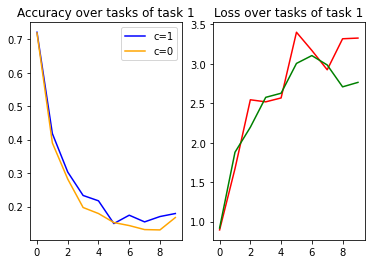

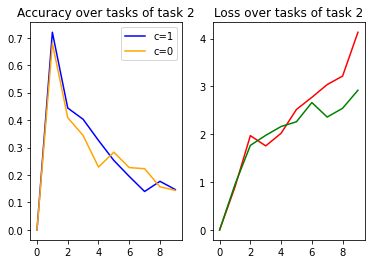

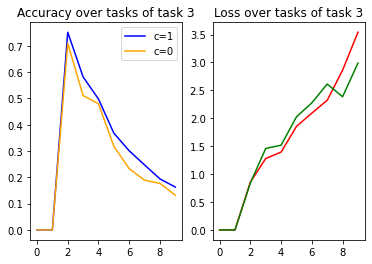

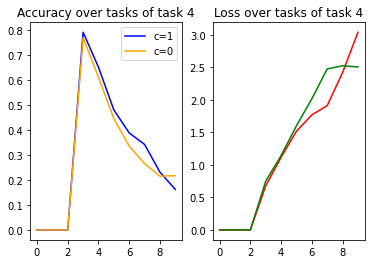

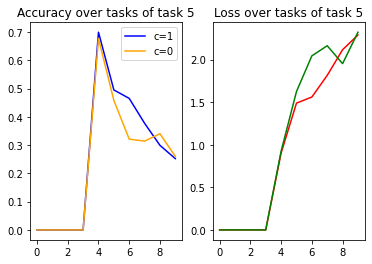

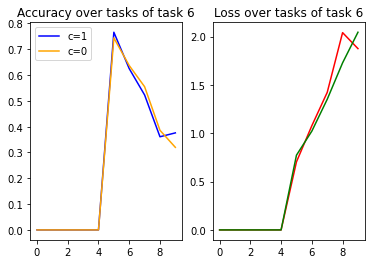

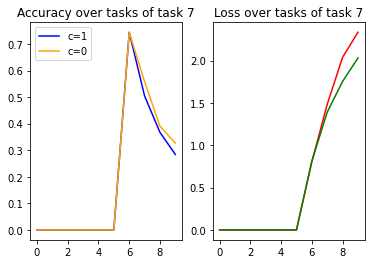

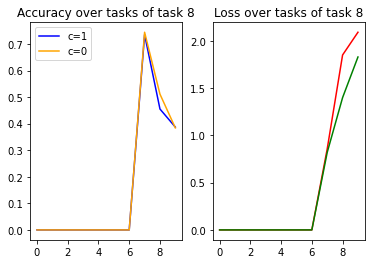

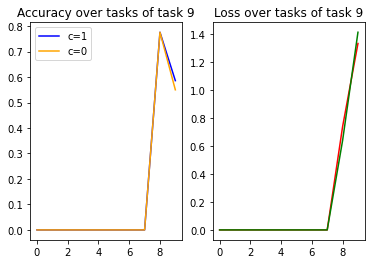

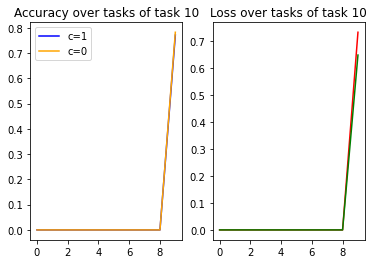

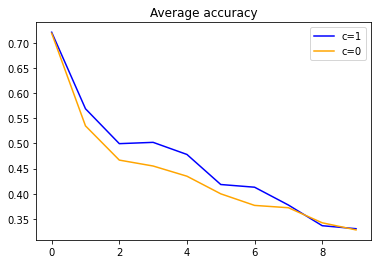

In [70]:
plot_res(
    task_cla_cf100,
    cf100_acc_w_c,
    cf100_acc_wo_c,
    cf100_loss_w_c,
    cf100_loss_wo_c
)

#Fix

In [ ]:
model = MLP(
    input_size= input_size,
    task_cla= task_cla
).to(device)

In [ ]:
x_train = data_cf100[0]['train']['x'].to(device)
y_train = data_cf100[0]['train']['y'].to(device)
x_val = data_cf100[0]['valid']['x'].to(device)
y_val = data_cf100[0]['valid']['y'].to(device)

conv_net = ConvNet(
    input_size_cf100,
    task_cla_cf100
)

conv_net.train()

r=np.arange(x_train.size(0))
np.random.shuffle(r)
r=torch.LongTensor(r).to(device)

for i in range(0, len(r), 256):
    b = r[i: i + 256]
    
    x_b = x_train[b]
    y_b = y_train[b]

    print(y_b)

    out = conv_net.forward(x_b)[0]
    print(type(out))

    print(out)
    loss = nn.CrossEntropyLoss()
    print(loss(out, y_b))
    break

tensor([4, 6, 3, 2, 1, 8, 4, 5, 8, 3, 4, 9, 6, 5, 8, 4, 3, 3, 0, 9, 0, 4, 0, 3,
        8, 7, 7, 3, 2, 2, 9, 8, 7, 2, 1, 3, 2, 0, 1, 3, 0, 3, 2, 4, 8, 6, 8, 4,
        3, 1, 5, 2, 3, 2, 8, 3, 0, 0, 4, 9, 8, 2, 0, 4, 2, 7, 9, 1, 2, 5, 1, 2,
        9, 6, 2, 9, 7, 9, 6, 3, 8, 0, 8, 5, 4, 6, 8, 8, 4, 2, 1, 9, 4, 1, 3, 4,
        2, 6, 9, 9, 4, 9, 7, 7, 6, 6, 4, 6, 4, 7, 5, 8, 4, 2, 8, 4, 2, 2, 2, 1,
        8, 0, 0, 7, 4, 8, 3, 2, 7, 0, 7, 9, 7, 1, 0, 0, 0, 8, 3, 8, 0, 0, 5, 3,
        8, 3, 3, 1, 6, 4, 0, 2, 2, 8, 3, 6, 8, 2, 4, 1, 7, 9, 1, 0, 8, 1, 3, 7,
        4, 8, 4, 3, 9, 3, 3, 7, 6, 7, 1, 2, 4, 1, 1, 3, 5, 6, 0, 5, 0, 3, 2, 3,
        0, 3, 0, 0, 9, 5, 7, 5, 9, 1, 2, 2, 7, 6, 3, 4, 7, 2, 3, 0, 3, 1, 2, 0,
        0, 9, 1, 8, 7, 9, 8, 8, 9, 2, 8, 0, 4, 3, 4, 0, 4, 4, 9, 4, 9, 5, 4, 8,
        9, 4, 2, 8, 6, 6, 2, 0, 0, 0, 8, 9, 6, 7, 8, 1])
<class 'torch.Tensor'>
tensor([[ 0.0523, -0.0681, -0.0066,  ...,  0.0521,  0.0170,  0.0434],
        [ 0.0583, -0.0539, -0.0111,  ...,  0.0405,